In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [3]:
rb_fp = pd.read_csv('rb_fantasy3.csv')
wr_fp = pd.read_csv('wr_fantasy3.csv')
te_fp = pd.read_csv('te_fantasy3.csv')
fp_df = rb_fp.append(wr_fp.append(te_fp))
fp_df

,Full Name,Position,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),Games (2014),Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021)
0,A.J. Dillon,RB,24.1,-,-,-,-,-,-,3.6636,10.9176,-,-,-,-,-,-,11,17
1,Aaron Jones,RB,27.5,-,-,-,8,14.3,19.7,18.4929,15.2667,-,-,-,10,12,16,14,15
2,Aaron Ripkowski,RB,29.4,-,2.8,4.7,1.1,-,-,-,-,-,1,10,11,-,-,-,-
3,Adrian Peterson,RB,37.2,11.3,16.3,3,7.9,11.8,9.8,7.7812,6.65,1,16,3,10,16,15,16,4
4,Ahmad Bradshaw,RB,36.2,15.4,7.1,-,-,-,-,-,-,10,6,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Zach Ertz,TE,31.5,9,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,16,15,14,14,16,15,11,17
301,Zach Gentry,TE,25.7,-,-,-,-,-,1.4,0,2.1,-,-,-,-,-,1,2,17
302,Zach Miller,TE,37.6,-,8.3,12,7,-,-,-,-,-,13,10,8,-,-,-,-
303,Zach Miller,TE,36.5,4.5,-,-,-,-,-,-,-,3,-,-,-,-,-,-,-


In [4]:
fp_df['rb?'] = np.where(fp_df['Position'] == 'RB',1,0)
fp_df['wr?'] = np.where(fp_df['Position'] == 'WR',1,0)
fp_df['te?'] = np.where(fp_df['Position'] == 'TE',1,0)
fp_df

,Full Name,Position,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021),rb?,wr?,te?
0,A.J. Dillon,RB,24.1,-,-,-,-,-,-,3.6636,...,-,-,-,-,-,11,17,1,0,0
1,Aaron Jones,RB,27.5,-,-,-,8,14.3,19.7,18.4929,...,-,-,10,12,16,14,15,1,0,0
2,Aaron Ripkowski,RB,29.4,-,2.8,4.7,1.1,-,-,-,...,1,10,11,-,-,-,-,1,0,0
3,Adrian Peterson,RB,37.2,11.3,16.3,3,7.9,11.8,9.8,7.7812,...,16,3,10,16,15,16,4,1,0,0
4,Ahmad Bradshaw,RB,36.2,15.4,7.1,-,-,-,-,-,...,6,-,-,-,-,-,-,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Zach Ertz,TE,31.5,9,11.4,13.1,14.5,17.5,14.2,7.0455,...,15,14,14,16,15,11,17,0,0,1
301,Zach Gentry,TE,25.7,-,-,-,-,-,1.4,0,...,-,-,-,-,1,2,17,0,0,1
302,Zach Miller,TE,37.6,-,8.3,12,7,-,-,-,...,13,10,8,-,-,-,-,0,0,1
303,Zach Miller,TE,36.5,4.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,0,0,1


In [5]:
fp_clean = fp_df.replace('-',np.nan).set_index('Full Name').drop(columns=['Position'])
fp_final_df = fp_clean.apply(lambda x: pd.to_numeric(x))
fp_final_df

,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),Games (2014),Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021),rb?,wr?,te?
Full Name,,,,,,,,,,,,,,,,,,,,
A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,NaN,NaN,NaN,NaN,NaN,NaN,11.0,17.0,1,0,0
Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,NaN,NaN,NaN,10.0,12.0,16.0,14.0,15.0,1,0,0
Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,NaN,1.0,10.0,11.0,NaN,NaN,NaN,NaN,1,0,0
Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,1.0,16.0,3.0,10.0,16.0,15.0,16.0,4.0,1,0,0
Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,16.0,15.0,14.0,14.0,16.0,15.0,11.0,17.0,0,0,1
Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,NaN,NaN,NaN,NaN,NaN,1.0,2.0,17.0,0,0,1
Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,NaN,13.0,10.0,8.0,NaN,NaN,NaN,NaN,0,0,1


In [6]:
fp_final_df['fpts_2014'] = fp_final_df['Fantasy Points Per Game (2014)'] * fp_final_df['Games (2014)']
fp_final_df['fpts_2015'] = fp_final_df['Fantasy Points Per Game (2015)'] * fp_final_df['Games (2015)']
fp_final_df['fpts_2016'] = fp_final_df['Fantasy Points Per Game (2016)'] * fp_final_df['Games (2016)']
fp_final_df['fpts_2017'] = fp_final_df['Fantasy Points Per Game (2017)'] * fp_final_df['Games (2017)']
fp_final_df['fpts_2018'] = fp_final_df['Fantasy Points Per Game (2018)'] * fp_final_df['Games (2018)']
fp_final_df['fpts_2019'] = fp_final_df['Fantasy Points Per Game (2019)'] * fp_final_df['Games (2019)']
fp_final_df['fpts_2020'] = fp_final_df['Fantasy Points Per Game (2020)'] * fp_final_df['Games (2020)']
fp_final_df['fpts_2021'] = fp_final_df['Fantasy Points Per Game (2021)'] * fp_final_df['Games (2021)']
fp_final_df.reset_index()

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,wr?,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,40.2996,185.5992
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,0,0,NaN,NaN,NaN,80.0,171.6,315.2,258.9006,229.0005
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,0,0,NaN,2.8,47.0,12.1,NaN,NaN,NaN,NaN
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,0,0,11.3,260.8,9.0,79.0,188.8,147.0,124.4992,26.6000
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,154.0,42.6,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,0,1,144.0,171.0,183.4,203.0,280.0,213.0,77.5005,180.6998
1294,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,0,1,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,35.7000
1295,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,0,1,NaN,107.9,120.0,56.0,NaN,NaN,NaN,NaN
1296,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
rb_dc = pd.read_csv('rb_dc.csv')
wr_dc = pd.read_csv('wr_dc.csv')
te_dc = pd.read_csv('te_dc.csv')

dc_df = rb_dc.append(wr_dc.append(te_dc))
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age
0,A.J. Dillon,RB,2.30,34.8%,19.3
1,Aaron Green,RB,Undrafted,18.7%,20.9
2,Aaron Jones,RB,5.39,47.0%,18.8
3,Aaron Ripkowski,RB,6.30,3.9%,-
4,Abram Smith,RB,Undrafted,25.5%,23
...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-
459,Zach Ertz,TE,2.03,31.8%,21.8
460,Zach Gentry,TE,5.03,15.6%,-
461,Zach Miller,TE,2.06,18.1%,20.7


In [8]:
dc_df['cdr'] = dc_df['College Dominator Rating'].str.strip('%')
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age,cdr
0,A.J. Dillon,RB,2.30,34.8%,19.3,34.8
1,Aaron Green,RB,Undrafted,18.7%,20.9,18.7
2,Aaron Jones,RB,5.39,47.0%,18.8,47.0
3,Aaron Ripkowski,RB,6.30,3.9%,-,3.9
4,Abram Smith,RB,Undrafted,25.5%,23,25.5
...,...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-,13.1
459,Zach Ertz,TE,2.03,31.8%,21.8,31.8
460,Zach Gentry,TE,5.03,15.6%,-,15.6
461,Zach Miller,TE,2.06,18.1%,20.7,18.1


In [9]:
dc_df['drafted'] = np.where(dc_df['Draft Pick'] != 'Undrafted', 1, 0)
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age,cdr,drafted
0,A.J. Dillon,RB,2.30,34.8%,19.3,34.8,1
1,Aaron Green,RB,Undrafted,18.7%,20.9,18.7,0
2,Aaron Jones,RB,5.39,47.0%,18.8,47.0,1
3,Aaron Ripkowski,RB,6.30,3.9%,-,3.9,1
4,Abram Smith,RB,Undrafted,25.5%,23,25.5,0
...,...,...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-,13.1,0
459,Zach Ertz,TE,2.03,31.8%,21.8,31.8,1
460,Zach Gentry,TE,5.03,15.6%,-,15.6,1
461,Zach Miller,TE,2.06,18.1%,20.7,18.1,1


In [10]:
dc_df_clean = dc_df[['Draft Pick','Breakout Age','cdr','drafted']].set_index(dc_df['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_final = dc_df_clean.reset_index()
dc_df_final

,Full Name,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,2.30,19.3,34.8,1
1,Aaron Green,NaN,20.9,18.7,0
2,Aaron Jones,5.39,18.8,47.0,1
3,Aaron Ripkowski,6.30,NaN,3.9,1
4,Abram Smith,NaN,23.0,25.5,0
...,...,...,...,...,...
2272,Xavier Grimble,NaN,NaN,13.1,0
2273,Zach Ertz,2.03,21.8,31.8,1
2274,Zach Gentry,5.03,NaN,15.6,1
2275,Zach Miller,2.06,20.7,18.1,1


In [11]:
full_data = fp_final_df.merge(dc_df_final,on='Full Name',how='inner')
full_data

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,47.0,12.1,NaN,NaN,NaN,NaN,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.40,18.5,46.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1
1252,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,NaN,NaN,NaN,1.4,0.0000,35.7000,5.03,NaN,15.6,1
1253,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,120.0,56.0,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1
1254,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1


In [12]:
full_data.columns

Index(['Full Name', 'Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)',
       'Fantasy Points Per Game (2017)', 'Fantasy Points Per Game (2018)',
       'Fantasy Points Per Game (2019)', 'Fantasy Points Per Game (2020)',
       'Fantasy Points Per Game (2021)', 'Games (2014)', 'Games (2015)',
       'Games (2016)', 'Games (2017)', 'Games (2018)', 'Games (2019)',
       'Games (2020)', 'Games (2021)', 'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021', 'Draft Pick', 'Breakout Age', 'cdr',
       'drafted'],
      dtype='object')

In [64]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [65]:
fp_2017 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2017)'])
fp_2017

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),rb?,wr?,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN,80.0,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,1.0,10.0,1,0,0,NaN,2.8,47.0,12.1,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,1.0,16.0,3.0,1,0,0,11.3,260.8,9.0,79.0,1.07,19.5,42.7,1
5,Akeem Hunt,29.3,NaN,2.8,2.1,0.7,NaN,7.0,8.0,1,0,0,NaN,19.6,16.8,9.8,NaN,20.5,27.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN,0.0,6.08,NaN,3.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,5.0,11.0,10.0,0,0,1,19.5,35.2,52.0,39.6,7.01,21.1,19.5,1
1249,Will Tye,30.6,NaN,8.0,5.8,3.9,NaN,13.0,16.0,0,0,1,NaN,104.0,92.8,7.8,NaN,21.8,36.1,0
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,NaN,NaN,8.0,0,0,1,NaN,NaN,34.4,14.4,NaN,NaN,13.1,0
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,16.0,15.0,14.0,0,0,1,144.0,171.0,183.4,203.0,2.03,21.8,31.8,1


In [66]:
fp_2017['y'] = np.where(fp_2017['Fantasy Points Per Game (2017)'] > 15,1,0)
fp_2017['y'].value_counts()

0    448
1     23
Name: y, dtype: int64

In [67]:
fpts_df_2017 = fp_2017[['fpts_2014','fpts_2015', 'fpts_2016']]

In [68]:
fppg_df_2017 = fp_2017[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [69]:
df_2017 = fp_2017[['y','rb?','te?']]
df_2017

,y,rb?,te?
1,0,1,0
2,0,1,0
3,0,1,0
5,0,1,0
7,0,1,0
...,...,...,...
1247,0,0,1
1249,0,0,1
1250,0,0,1
1251,0,0,1


In [70]:
df_2017['age'] = fp_2017['Age'] - 5
df_2017

,y,rb?,te?,age
1,0,1,0,22.5
2,0,1,0,24.4
3,0,1,0,32.2
5,0,1,0,24.3
7,0,1,0,23.0
...,...,...,...,...
1247,0,0,1,28.8
1249,0,0,1,25.6
1250,0,0,1,24.7
1251,0,0,1,26.5


In [71]:
df_2017['max_ppg'] = fppg_df_2017.max(axis=1)
df_2017

,y,rb?,te?,age,max_ppg
1,0,1,0,22.5,NaN
2,0,1,0,24.4,4.7
3,0,1,0,32.2,16.3
5,0,1,0,24.3,2.8
7,0,1,0,23.0,NaN
...,...,...,...,...,...
1247,0,0,1,28.8,5.2
1249,0,0,1,25.6,8.0
1250,0,0,1,24.7,4.3
1251,0,0,1,26.5,13.1


In [72]:
df_2017['last_pts'] = fppg_df_2017['Fantasy Points Per Game (2016)']
df_2017

,y,rb?,te?,age,max_ppg,last_pts
1,0,1,0,22.5,NaN,NaN
2,0,1,0,24.4,4.7,4.7
3,0,1,0,32.2,16.3,3.0
5,0,1,0,24.3,2.8,2.1
7,0,1,0,23.0,NaN,NaN
...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2
1249,0,0,1,25.6,8.0,5.8
1250,0,0,1,24.7,4.3,4.3
1251,0,0,1,26.5,13.1,13.1


In [73]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg
1,0,1,0,22.5,NaN,NaN,NaN
2,0,1,0,24.4,4.7,4.7,3.750000
3,0,1,0,32.2,16.3,3.0,10.200000
5,0,1,0,24.3,2.8,2.1,2.450000
7,0,1,0,23.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000
1249,0,0,1,25.6,8.0,5.8,6.900000
1250,0,0,1,24.7,4.3,4.3,4.300000
1251,0,0,1,26.5,13.1,13.1,11.166667


In [74]:
df_2017['hit_rate'] = fppg_df_2017[fppg_df_2017 > 15].count(axis = 1) / fppg_df_2017.count(axis=1)
df_2017

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate
1,0,1,0,22.5,NaN,NaN,NaN,NaN
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000
7,0,1,0,23.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000


In [75]:
df_2017['Draft Pick'] = fp_2017['Draft Pick']
df_2017['Breakout Age'] = fp_2017['Breakout Age']
df_2017['cdr'] = fp_2017['cdr']
df_2017

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2
...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000,7.01,21.1,19.5
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000,NaN,21.8,36.1
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000,NaN,NaN,13.1
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000,2.03,21.8,31.8


In [76]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = fp_2017['Full Name']
df_2017_id['year'] = 2017
df_2017_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000,7.01,21.1,19.5,Virgil Green,2017
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000,NaN,21.8,36.1,Will Tye,2017
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000,NaN,NaN,13.1,Xavier Grimble,2017
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000,2.03,21.8,31.8,Zach Ertz,2017


In [77]:
final_data = final_data.append(df_2017)
final_data

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2
...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000,7.01,21.1,19.5
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000,NaN,21.8,36.1
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000,NaN,NaN,13.1
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000,2.03,21.8,31.8


In [78]:
final_data_id = final_data_id.append(df_2017_id)
final_data_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,5.2,5.2,4.100000,0.000000,7.01,21.1,19.5,Virgil Green,2017
1249,0,0,1,25.6,8.0,5.8,6.900000,0.000000,NaN,21.8,36.1,Will Tye,2017
1250,0,0,1,24.7,4.3,4.3,4.300000,0.000000,NaN,NaN,13.1,Xavier Grimble,2017
1251,0,0,1,26.5,13.1,13.1,11.166667,0.000000,2.03,21.8,31.8,Zach Ertz,2017


### 2018

In [79]:
fp_2018 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2018)'])
fp_2018

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),Games (2015),Games (2016),...,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,NaN,NaN,NaN,...,0,NaN,NaN,NaN,80.0,171.6,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,1.0,16.0,3.0,...,0,11.3,260.8,9.0,79.0,188.8,1.07,19.5,42.7,1
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,15.2,6.08,NaN,3.2,1
8,Alex Collins,27.8,NaN,NaN,4.0,11.4,10.9,NaN,NaN,9.0,...,0,NaN,NaN,36.0,171.0,109.0,5.34,19.0,29.9,1
11,Alfred Blue,31.1,6.1,8.0,4.4,5.6,6.1,16.0,14.0,14.0,...,0,97.6,112.0,61.6,44.8,97.6,6.05,21.4,14.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,Vernon Davis,38.3,4.8,6.0,7.6,7.6,5.7,13.0,13.0,15.0,...,1,62.4,78.0,114.0,121.6,74.1,1.06,21.6,35.9,1
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,5.0,11.0,10.0,...,1,19.5,35.2,52.0,39.6,46.2,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,35.6,4.20,NaN,10.3,1
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,1.6,NaN,NaN,8.0,...,1,NaN,NaN,34.4,14.4,12.8,NaN,NaN,13.1,0


In [80]:
fp_2018['y'] = np.where(fp_2018['Fantasy Points Per Game (2018)'] > 15,1,0)
fp_2018['y'].value_counts()

0    456
1     35
Name: y, dtype: int64

In [81]:
fpts_df_2018 = fp_2018[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

fppg_df_2018 = fp_2018[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

df_2018 = fp_2018[['y','rb?','te?']]


df_2018['age'] = fp_2018['Age'] - 4


df_2018['max_ppg'] = fppg_df_2018.max(axis=1)


df_2018['last_pts'] = fppg_df_2018['Fantasy Points Per Game (2017)']


df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018.mean(axis=1)


df_2018['hit_rate'] = fppg_df_2018[fppg_df_2018 > 15].count(axis = 1) / fppg_df_2018.count(axis=1)


df_2018['Draft Pick'] = fp_2018['Draft Pick']
df_2018['Breakout Age'] = fp_2018['Breakout Age']
df_2018['cdr'] = fp_2018['cdr']

df_2018_id = df_2018.copy()
df_2018_id['id'] = fp_2018['Full Name']
df_2018_id['year'] = 2018
df_2018_id


final_data = final_data.append(df_2018)
final_data

final_data_id = final_data_id.append(df_2018_id)
final_data_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0,0,1,34.3,7.6,7.6,7.066667,0.000000,1.06,21.6,35.9,Vernon Davis,2018
1247,0,0,1,29.8,5.2,3.6,4.000000,0.000000,7.01,21.1,19.5,Virgil Green,2018
1248,0,0,1,21.9,NaN,NaN,NaN,NaN,4.20,NaN,10.3,Will Dissly,2018
1250,0,0,1,25.7,4.3,2.4,3.350000,0.000000,NaN,NaN,13.1,Xavier Grimble,2018


### 2019

In [82]:
fp_2019 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2019)'])
fp_2019

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Games (2014),Games (2015),...,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,NaN,NaN,...,NaN,NaN,NaN,80.0,171.6,315.2,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,1.0,16.0,...,11.3,260.8,9.0,79.0,188.8,147.0,1.07,19.5,42.7,1
6,Alec Ingold,25.9,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.6,NaN,NaN,10.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,1.2,NaN,NaN,...,NaN,NaN,NaN,0.0,15.2,9.6,6.08,NaN,3.2,1
9,Alexander Mattison,23.9,NaN,NaN,NaN,NaN,NaN,5.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,68.9,3.38,19.2,28.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,1.9,5.0,11.0,...,19.5,35.2,52.0,39.6,46.2,22.8,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,NaN,NaN,...,NaN,NaN,NaN,NaN,35.6,73.8,4.20,NaN,10.3,1
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,1.6,0.6,NaN,NaN,...,NaN,NaN,34.4,14.4,12.8,1.2,NaN,NaN,13.1,0
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,16.0,15.0,...,144.0,171.0,183.4,203.0,280.0,213.0,2.03,21.8,31.8,1


In [83]:
fp_2019['y'] = np.where(fp_2019['Fantasy Points Per Game (2019)'] > 15,1,0)
fp_2019['y'].value_counts()

0    450
1     35
Name: y, dtype: int64

In [84]:
fpts_df_2019 = fp_2019[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

fppg_df_2019 = fp_2019[['Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)']]

df_2019 = fp_2019[['y','rb?','te?']]


df_2019['age'] = fp_2019['Age'] - 3


df_2019['max_ppg'] = fppg_df_2019.max(axis=1)


df_2019['last_pts'] = fppg_df_2019['Fantasy Points Per Game (2018)']


df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019.mean(axis=1)


df_2019['hit_rate'] = fppg_df_2019[fppg_df_2019 > 15].count(axis = 1) / fppg_df_2019.count(axis=1)


df_2019['Draft Pick'] = fp_2019['Draft Pick']
df_2019['Breakout Age'] = fp_2019['Breakout Age']
df_2019['cdr'] = fp_2019['cdr']

df_2019_id = df_2019.copy()
df_2019_id['id'] = fp_2019['Full Name']
df_2019_id['year'] = 2019
df_2019_id


final_data = final_data.append(df_2019)
final_data

final_data_id = final_data_id.append(df_2019_id)
final_data_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,30.8,5.2,3.3,4.033333,0.000000,7.01,21.1,19.5,Virgil Green,2019
1248,0,0,1,22.9,8.9,8.9,8.900000,0.000000,4.20,NaN,10.3,Will Dissly,2019
1250,0,0,1,26.7,4.3,1.6,2.766667,0.000000,NaN,NaN,13.1,Xavier Grimble,2019
1251,0,0,1,28.5,17.5,17.5,15.033333,0.333333,2.03,21.8,31.8,Zach Ertz,2019


### 2020

In [85]:
fp_2020 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2020)'])
fp_2020

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Games (2014),...,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,NaN,...,NaN,NaN,NaN,NaN,NaN,40.2996,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,NaN,...,NaN,NaN,80.0,171.6,315.2,258.9006,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,1.0,...,260.8,9.0,79.0,188.8,147.0,124.4992,1.07,19.5,42.7,1
6,Alec Ingold,25.9,NaN,NaN,NaN,NaN,NaN,1.6,2.7000,NaN,...,NaN,NaN,NaN,NaN,17.6,29.7000,NaN,NaN,10.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,1.2,0.6000,NaN,...,NaN,NaN,0.0,15.2,9.6,7.2000,6.08,NaN,3.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,Vance McDonald,32.0,0.8,5.8,8.7,4.3,8.9,6.0,1.7786,4.0,...,81.2,87.0,38.7,133.5,84.0,24.9004,2.23,20.2,26.6,1
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,1.9,2.3333,5.0,...,35.2,52.0,39.6,46.2,22.8,13.9998,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,3.8188,NaN,...,NaN,NaN,NaN,35.6,73.8,61.1008,4.20,NaN,10.3,1
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,16.0,...,171.0,183.4,203.0,280.0,213.0,77.5005,2.03,21.8,31.8,1


In [86]:
fp_2020['y'] = np.where(fp_2020['Fantasy Points Per Game (2020)'] > 15,1,0)
fp_2020['y'].value_counts()

0    507
1     36
Name: y, dtype: int64

In [87]:
fpts_df_2020 = fp_2020[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

fppg_df_2020 = fp_2020[['Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

df_2020 = fp_2020[['y','rb?','te?']]


df_2020['age'] = fp_2020['Age'] - 2


df_2020['max_ppg'] = fppg_df_2020.max(axis=1)


df_2020['last_pts'] = fppg_df_2020['Fantasy Points Per Game (2019)']


df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020.mean(axis=1)


df_2020['hit_rate'] = fppg_df_2020[fppg_df_2020 > 15].count(axis = 1) / fppg_df_2020.count(axis=1)


df_2020['Draft Pick'] = fp_2020['Draft Pick']
df_2020['Breakout Age'] = fp_2020['Breakout Age']
df_2020['cdr'] = fp_2020['cdr']

df_2020_id = df_2020.copy()
df_2020_id['id'] = fp_2020['Full Name']
df_2020_id['year'] = 2020
df_2020_id

final_data = final_data.append(df_2020)
final_data

final_data_id = final_data_id.append(df_2020_id)
final_data_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,4.7,4.7,3.750000,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,16.3,3.0,10.200000,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,2.8,2.1,2.450000,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0,0,1,30.0,8.9,6.0,6.400000,0.000000,2.23,20.2,26.6,Vance McDonald,2020
1247,0,0,1,31.8,3.6,1.9,2.933333,0.000000,7.01,21.1,19.5,Virgil Green,2020
1248,0,0,1,23.9,12.3,12.3,10.600000,0.000000,4.20,NaN,10.3,Will Dissly,2020
1251,0,0,1,29.5,17.5,14.2,15.400000,0.333333,2.03,21.8,31.8,Zach Ertz,2020


### 2021

In [88]:
fp_2021 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2021)'])
fp_2021

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
8,Alex Collins,27.8,NaN,NaN,4.0,11.4,10.9,NaN,7.0333,6.2545,...,36.0,171.0,109.0,NaN,21.0999,68.7995,5.34,19.0,29.9,1
9,Alexander Mattison,23.9,NaN,NaN,NaN,NaN,NaN,5.3,6.6846,7.8688,...,NaN,NaN,NaN,68.9,86.8998,125.9008,3.38,19.2,28.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,Tyler Higbee,29.4,NaN,NaN,2.1,4.3,4.7,11.5,8.5467,9.8000,...,25.2,60.2,65.8,161.0,128.2005,147.0000,4.12,22.7,15.6,1
1243,Tyler Kroft,29.6,NaN,3.7,2.7,8.3,1.5,2.1,4.1900,4.3667,...,18.9,124.5,7.5,18.9,41.9000,39.3003,3.21,20.9,11.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,3.8188,3.3400,...,NaN,NaN,35.6,73.8,61.1008,50.1000,4.20,NaN,10.3,1
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1


In [89]:
fp_2021['y'] = np.where(fp_2021['Fantasy Points Per Game (2021)'] > 15,1,0)
fp_2021['y'].value_counts()

0    514
1     36
Name: y, dtype: int64

In [90]:
fpts_df_2021 = fp_2021[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]


fppg_df_2021 = fp_2021[['Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)']]

df_2021 = fp_2021[['y','rb?','te?']]


df_2021['age'] = fp_2021['Age'] - 1


df_2021['max_ppg'] = fppg_df_2021.max(axis=1)


df_2021['last_pts'] = fppg_df_2021['Fantasy Points Per Game (2020)']


df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021.mean(axis=1)


df_2021['hit_rate'] = fppg_df_2021[fppg_df_2021 > 15].count(axis = 1) / fppg_df_2021.count(axis=1)


df_2021['Draft Pick'] = fp_2021['Draft Pick']
df_2021['Breakout Age'] = fp_2021['Breakout Age']
df_2021['cdr'] = fp_2021['cdr']

df_2021_id = df_2021.copy()
df_2021_id['id'] = fp_2021['Full Name']
df_2021_id['year'] = 2021
df_2021_id

final_data = final_data.append(df_2021)
final_data

final_data_id = final_data_id.append(df_2021_id)
final_data_id

,y,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,4.70,4.7000,3.750000,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,16.30,3.0000,10.200000,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,2.80,2.1000,2.450000,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,0,0,1,28.4,11.50,8.5467,8.248900,0.000000,4.12,22.7,15.6,Tyler Higbee,2021
1243,0,0,1,28.6,4.19,4.1900,2.596667,0.000000,3.21,20.9,11.5,Tyler Kroft,2021
1248,0,0,1,24.9,12.30,3.8188,8.339600,0.000000,4.20,NaN,10.3,Will Dissly,2021
1251,0,0,1,30.5,17.50,7.0455,12.915167,0.333333,2.03,21.8,31.8,Zach Ertz,2021


In [91]:
final_data_id.y.value_counts()

0    2375
1     165
Name: y, dtype: int64

In [92]:
final_data.to_csv('final_data3.csv')
final_data_id.to_csv('final_data_id3.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [93]:
fp_2022 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)','Games (2021)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']]
fp_2022

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,47.0,12.1,NaN,NaN,NaN,NaN,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.40,18.5,46.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1
1252,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,NaN,NaN,NaN,1.4,0.0000,35.7000,5.03,NaN,15.6,1
1253,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,120.0,56.0,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1
1254,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1


In [94]:
fpts_df_2022 = fp_2022[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                        'fpts_2021']]


fppg_df_2022 = fp_2022[['Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

df_2022 = fp_2022[['rb?','te?']]


df_2022['age'] = fp_2022['Age']


df_2022['max_ppg'] = fppg_df_2022.max(axis=1)


df_2022['last_pts'] = fppg_df_2022['Fantasy Points Per Game (2021)']


df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022.mean(axis=1)


df_2022['hit_rate'] = fppg_df_2022[fppg_df_2022 > 15].count(axis = 1) / fppg_df_2022.count(axis=1)


df_2022['Draft Pick'] = fp_2022['Draft Pick']
df_2022['Breakout Age'] = fp_2022['Breakout Age']
df_2022['cdr'] = fp_2022['cdr']

df_2022_id = df_2022.copy()
df_2022_id['id'] = fp_2022['Full Name']
df_2022_id['year'] = 2022

df_2022

,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
0,1,0,24.1,10.9176,10.9176,7.290600,0.0,2.30,19.3,34.8
1,1,0,27.5,19.7000,15.2667,17.819867,1.0,5.39,18.8,47.0
2,1,0,29.4,NaN,NaN,NaN,NaN,6.30,NaN,3.9
3,1,0,37.2,9.8000,6.6500,8.077067,0.0,1.07,19.5,42.7
4,1,0,36.2,NaN,NaN,NaN,NaN,7.40,18.5,46.3
...,...,...,...,...,...,...,...,...,...,...
1251,0,1,31.5,14.2000,10.6294,10.624967,0.0,2.03,21.8,31.8
1252,0,1,25.7,2.1000,2.1000,1.166667,0.0,5.03,NaN,15.6
1253,0,1,37.6,NaN,NaN,NaN,NaN,2.06,20.7,18.1
1254,0,1,36.5,NaN,NaN,NaN,NaN,2.06,20.7,18.1


In [95]:
rb_dc_rookie = pd.read_csv('rb_2022_rookie.csv')
wr_dc_rookie = pd.read_csv('wr_2022_rookie.csv')
te_dc_rookie = pd.read_csv('te_2022_rookie.csv')

dc_df_rookie = rb_dc_rookie.append(wr_dc_rookie.append(te_dc_rookie))
dc_df_rookie

dc_df_rookie['cdr'] = dc_df_rookie['College Dominator Rating'].str.strip('%')
dc_df_rookie

dc_df_rookie['rb?'] = np.where(dc_df_rookie['Position']=='RB',1,0)
dc_df_rookie['te?'] = np.where(dc_df_rookie['Position']=='TE',1,0)


dc_df_rookie_clean = dc_df_rookie[['Draft Pick','Breakout Age','cdr','rb?','te?','Age']].set_index(
    dc_df_rookie['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_rookie_final = dc_df_rookie_clean.reset_index()
dc_df_rookie_final

,Full Name,Draft Pick,Breakout Age,cdr,rb?,te?,Age
0,Abram Smith,NaN,23.0,25.5,1,0,23.7
1,B.J. Smith,NaN,20.7,19.9,1,0,24.4
2,BJ Baylor,NaN,23.0,25.0,1,0,23.7
3,Breece Hall,2.04,18.3,43.9,1,0,21.0
4,Brian Robinson,3.34,22.5,24.4,1,0,23.2
...,...,...,...,...,...,...,...
144,Rodney Williams,NaN,22.4,20.8,0,1,24.1
145,Seth Green,NaN,NaN,6.9,0,1,0.0
146,Stone Smartt,NaN,NaN,4.9,0,1,0.0
147,Teagan Quitoriano,5.27,NaN,12.7,0,1,22.2


In [96]:
dc_df_rookie_final = dc_df_rookie_final.append({'Full Name':'Travis Etienne','Draft Pick':1.25,
                                                'Breakout Age':19,'cdr':25.7,'rb?':1,'te?':0,'Age':23.3
                                               },ignore_index=True)
dc_df_rookie_final

,Full Name,Draft Pick,Breakout Age,cdr,rb?,te?,Age
0,Abram Smith,NaN,23.0,25.5,1,0,23.7
1,B.J. Smith,NaN,20.7,19.9,1,0,24.4
2,BJ Baylor,NaN,23.0,25.0,1,0,23.7
3,Breece Hall,2.04,18.3,43.9,1,0,21.0
4,Brian Robinson,3.34,22.5,24.4,1,0,23.2
...,...,...,...,...,...,...,...
145,Seth Green,NaN,NaN,6.9,0,1,0.0
146,Stone Smartt,NaN,NaN,4.9,0,1,0.0
147,Teagan Quitoriano,5.27,NaN,12.7,0,1,22.2
148,Trey McBride,2.23,20.8,46.3,0,1,22.5


In [103]:
rookie_df = pd.DataFrame()
rookie_df[['id','rb?','te?','age']] = dc_df_rookie_final[['Full Name','rb?','te?','Age']]
rookie_df

,id,rb?,te?,age
0,Abram Smith,1,0,23.7
1,B.J. Smith,1,0,24.4
2,BJ Baylor,1,0,23.7
3,Breece Hall,1,0,21.0
4,Brian Robinson,1,0,23.2
...,...,...,...,...
145,Seth Green,0,1,0.0
146,Stone Smartt,0,1,0.0
147,Teagan Quitoriano,0,1,22.2
148,Trey McBride,0,1,22.5


In [104]:
df_2022.columns

Index(['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

In [105]:
rookie_df[['max_ppg', 'last_pts',
       '3_yr_trail_avg_fppg',
       'hit_rate',]] = np.nan
rookie_df

,id,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate
0,Abram Smith,1,0,23.7,NaN,NaN,NaN,NaN
1,B.J. Smith,1,0,24.4,NaN,NaN,NaN,NaN
2,BJ Baylor,1,0,23.7,NaN,NaN,NaN,NaN
3,Breece Hall,1,0,21.0,NaN,NaN,NaN,NaN
4,Brian Robinson,1,0,23.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
145,Seth Green,0,1,0.0,NaN,NaN,NaN,NaN
146,Stone Smartt,0,1,0.0,NaN,NaN,NaN,NaN
147,Teagan Quitoriano,0,1,22.2,NaN,NaN,NaN,NaN
148,Trey McBride,0,1,22.5,NaN,NaN,NaN,NaN


In [106]:
rookie_df[['Draft Pick', 'Breakout Age', 'cdr']] = dc_df_rookie_final[['Draft Pick', 'Breakout Age', 'cdr']]
rookie_df

,id,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
0,Abram Smith,1,0,23.7,NaN,NaN,NaN,NaN,NaN,23.0,25.5
1,B.J. Smith,1,0,24.4,NaN,NaN,NaN,NaN,NaN,20.7,19.9
2,BJ Baylor,1,0,23.7,NaN,NaN,NaN,NaN,NaN,23.0,25.0
3,Breece Hall,1,0,21.0,NaN,NaN,NaN,NaN,2.04,18.3,43.9
4,Brian Robinson,1,0,23.2,NaN,NaN,NaN,NaN,3.34,22.5,24.4
...,...,...,...,...,...,...,...,...,...,...,...
145,Seth Green,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9
146,Stone Smartt,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.9
147,Teagan Quitoriano,0,1,22.2,NaN,NaN,NaN,NaN,5.27,NaN,12.7
148,Trey McBride,0,1,22.5,NaN,NaN,NaN,NaN,2.23,20.8,46.3


In [200]:
df_2022_X_id = df_2022_id.append(rookie_df)
df_2022_X_id.to_csv('df_2022_X_id.csv')

In [108]:
df_2022_X = df_2022.append(rookie_df)
df_2022_X

,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id
0,1,0,24.1,10.9176,10.9176,7.290600,0.0,2.30,19.3,34.8,NaN
1,1,0,27.5,19.7000,15.2667,17.819867,1.0,5.39,18.8,47.0,NaN
2,1,0,29.4,NaN,NaN,NaN,NaN,6.30,NaN,3.9,NaN
3,1,0,37.2,9.8000,6.6500,8.077067,0.0,1.07,19.5,42.7,NaN
4,1,0,36.2,NaN,NaN,NaN,NaN,7.40,18.5,46.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...
145,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Seth Green
146,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.9,Stone Smartt
147,0,1,22.2,NaN,NaN,NaN,NaN,5.27,NaN,12.7,Teagan Quitoriano
148,0,1,22.5,NaN,NaN,NaN,NaN,2.23,20.8,46.3,Trey McBride


## XGBOOST

In [176]:
df = final_data.reset_index().drop(columns=['index'])
df.columns

Index(['y', 'rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

In [171]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split

In [172]:
def stratified_split(df, target, val_percent=0.2):
    '''
    Function to split a dataframe into train and validation sets, while preserving the ratio of the labels in the target variable
    Inputs:
    - df, the dataframe
    - target, the target variable
    - val_percent, the percentage of validation samples, default 0.2
    Outputs:
    - train_idxs, the indices of the training dataset
    - val_idxs, the indices of the validation dataset
    '''
    classes=list(df[target].unique())
    train_idxs, val_idxs = [], []
    for c in classes:
        idx=list(df[df[target]==c].index)
        np.random.shuffle(idx)
        val_size=int(len(idx)*val_percent)
        val_idxs+=idx[:val_size]
        train_idxs+=idx[val_size:]
    return train_idxs, val_idxs


train_idxs, val_idxs = stratified_split(df, 'y', val_percent=0.33)

val_idxs, test_idxs = stratified_split(df[df.index.isin(val_idxs)], 'y', val_percent=0.5)

In [173]:
def test_stratified(df, col):
    '''
    Analyzes the ratio of different classes in a categorical variable within a dataframe
    Inputs:
    - dataframe
    - categorical column to be analyzed
    Returns: None
    '''
    classes=list(df[col].unique())
    
    for c in classes:
        print(f'Proportion of records with {c}: {len(df[df[col]==c])*1./len(df):0.2} ({len(df[df[col]==c])} / {len(df)})')

In [174]:
print('---------- STRATIFIED SAMPLING REPORT ----------')
print('-------- Label proportions in FULL data --------')
test_stratified(df, 'y')
print('-------- Label proportions in TRAIN data --------')
test_stratified(df[df.index.isin(train_idxs)], 'y')
print('------ Label proportions in VALIDATION data -----')
test_stratified(df[df.index.isin(val_idxs)], 'y')
print('-------- Label proportions in TEST data ---------')
test_stratified(df[df.index.isin(test_idxs)], 'y')

---------- STRATIFIED SAMPLING REPORT ----------
-------- Label proportions in FULL data --------
Proportion of records with 0: 0.94 (2375 / 2540)
Proportion of records with 1: 0.065 (165 / 2540)
-------- Label proportions in TRAIN data --------
Proportion of records with 0: 0.93 (1592 / 1703)
Proportion of records with 1: 0.065 (111 / 1703)
------ Label proportions in VALIDATION data -----
Proportion of records with 0: 0.94 (392 / 419)
Proportion of records with 1: 0.064 (27 / 419)
-------- Label proportions in TEST data ---------
Proportion of records with 0: 0.94 (391 / 418)
Proportion of records with 1: 0.065 (27 / 418)


In [177]:
train_df = df[df.index.isin(train_idxs)]
X_train = train_df[['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']].values
Y_train = train_df[['y']].values
print('Retrieved Training Data')
val_df = df[df.index.isin(val_idxs)]
X_val = val_df[['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']].values
Y_val = val_df[['y']].values
print('Retrieved Validation Data')
test_df = df[df.index.isin(test_idxs)]
X_test = test_df[['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']].values
Y_test = test_df[['y']].values
print('Retrieved Test Data')

Retrieved Training Data
Retrieved Validation Data
Retrieved Test Data


In [178]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#store data, all in numpy arrays
training_data = {'X_train':X_train,'Y_train':Y_train,
                'X_val': X_val,'Y_val':Y_val,
                'X_test': X_test,'Y_test':Y_test}

In [182]:
import xgboost as xgb
import matplotlib.pyplot as plt

#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, training_data=training_data,epochs=300):
    print('Fitting model...')
    eval_set = [(training_data['X_val'], training_data['Y_val'])]
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0]),
                                                                           eval_set=eval_set)
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['logloss','error']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['Y_test'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['Y_test'],average='micro')))
    plot_compare(metrics,store,epochs)
    features = ['rb?', 'te?', 'age', 'max_ppg', 'last_pts', '3_yr_trail_avg_fppg',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

In [183]:
from xgboost.sklearn import XGBClassifier
#initial model
xgb1 = XGBClassifier(objective='binary:logistic',early_stopping_rounds=100,seed=24)

Fitting model...
[0]	validation_0-logloss:0.48416
[1]	validation_0-logloss:0.36952
[2]	validation_0-logloss:0.29866
[3]	validation_0-logloss:0.25559
[4]	validation_0-logloss:0.22825
[5]	validation_0-logloss:0.20891
[6]	validation_0-logloss:0.19669
[7]	validation_0-logloss:0.19106
[8]	validation_0-logloss:0.18683
[9]	validation_0-logloss:0.18308
[10]	validation_0-logloss:0.18323
[11]	validation_0-logloss:0.18395
[12]	validation_0-logloss:0.18580
[13]	validation_0-logloss:0.18662
[14]	validation_0-logloss:0.18567
[15]	validation_0-logloss:0.18619
[16]	validation_0-logloss:0.18679
[17]	validation_0-logloss:0.18851
[18]	validation_0-logloss:0.19008
[19]	validation_0-logloss:0.19085
[20]	validation_0-logloss:0.19459
[21]	validation_0-logloss:0.19766
[22]	validation_0-logloss:0.19766
[23]	validation_0-logloss:0.19833
[24]	validation_0-logloss:0.19235
[25]	validation_0-logloss:0.19651
[26]	validation_0-logloss:0.19624
[27]	validation_0-logloss:0.19573
[28]	validation_0-logloss:0.19747
[29]	va

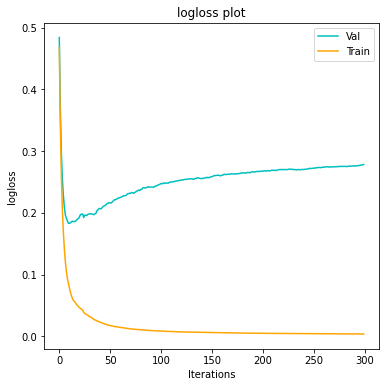

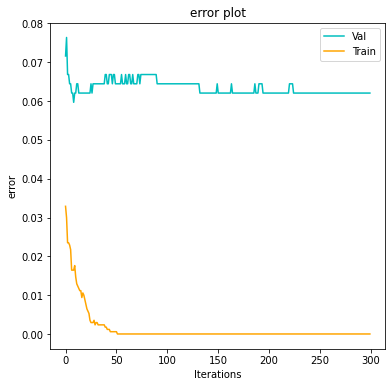

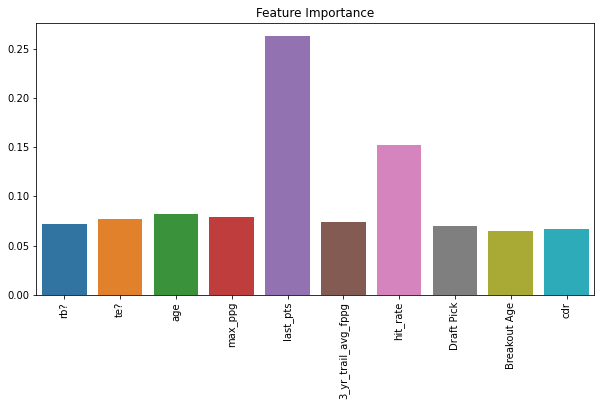

In [184]:
fitXgb(xgb1, training_data)

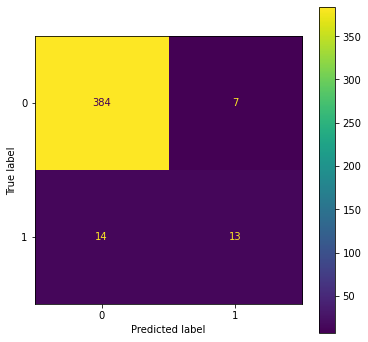

In [185]:
plot_confusion_matrix(xgb1,X_test,
                     Y_test,
                     values_format='d')

In [186]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [187]:
eval_set = [(X_val, Y_val)]

In [188]:
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_grid,scoring='f1_micro'
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, Y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-logloss:0.61315
[1]	validation_0-logloss:0.54754
[2]	validation_0-logloss:0.49409
[3]	validation_0-logloss:0.44802
[4]	validation_0-logloss:0.40987
[5]	validation_0-logloss:0.37776
[0]	validation_0-logloss:0.61447
[1]	validation_0-logloss:0.54992
[2]	validation_0-logloss:0.49621
[3]	validation_0-logloss:0.45046
[4]	validation_0-logloss:0.41232
[5]	validation_0-logloss:0.37999
[6]	validation_0-logloss:0.35274
[7]	validation_0-logloss:0.32944
[8]	validation_0-logloss:0.30805
[9]	validation_0-logloss:0.28983
[6]	validation_0-logloss:0.34935
[10]	validation_0-logloss:0.27409
[7]	validation_0-logloss:0.32542
[11]	validation_0-logloss:0.26006
[8]	validation_0-logloss:0.30402
[12]	validation_0-logloss:0.24777
[13]	validation_0-logloss:0.23715
[9]	validation_0-logloss:0.28677
[10]	validation_0-logloss:0.27062
[11]	validation_0-logloss:0.25752
[12]	validation_0-logloss:0.24543
[0]	validation_0-logloss:0.61937
[0]	va

[45]	validation_0-logloss:0.19493
[76]	validation_0-logloss:0.17622
[61]	validation_0-logloss:0.18465
[74]	validation_0-logloss:0.16750
[47]	validation_0-logloss:0.17778
[77]	validation_0-logloss:0.17631
[46]	validation_0-logloss:0.19537
[75]	validation_0-logloss:0.16698
[48]	validation_0-logloss:0.17800
[47]	validation_0-logloss:0.19505
[78]	validation_0-logloss:0.17613
[49]	validation_0-logloss:0.17835
[79]	validation_0-logloss:0.17647
[42]	validation_0-logloss:0.21622
[51]	validation_0-logloss:0.19932
[50]	validation_0-logloss:0.17779
[43]	validation_0-logloss:0.21625
[60]	validation_0-logloss:0.17164
[52]	validation_0-logloss:0.19840
[51]	validation_0-logloss:0.17791
[61]	validation_0-logloss:0.17211
[44]	validation_0-logloss:0.21627
[53]	validation_0-logloss:0.19754
[53]	validation_0-logloss:0.18355
[62]	validation_0-logloss:0.17225
[45]	validation_0-logloss:0.21609
[54]	validation_0-logloss:0.19705
[54]	validation_0-logloss:0.18245
[76]	validation_0-logloss:0.16754
[62]	validatio

[85]	validation_0-logloss:0.19647
[56]	validation_0-logloss:0.17935
[79]	validation_0-logloss:0.18581
[77]	validation_0-logloss:0.18309
[57]	validation_0-logloss:0.17955
[80]	validation_0-logloss:0.18574
[78]	validation_0-logloss:0.18225
[81]	validation_0-logloss:0.18584
[79]	validation_0-logloss:0.18222
[80]	validation_0-logloss:0.18299
[70]	validation_0-logloss:0.22006
[71]	validation_0-logloss:0.22012
[82]	validation_0-logloss:0.18566
[72]	validation_0-logloss:0.21999
[81]	validation_0-logloss:0.18291
[83]	validation_0-logloss:0.18559
[73]	validation_0-logloss:0.22006
[82]	validation_0-logloss:0.18309
[84]	validation_0-logloss:0.18574
[74]	validation_0-logloss:0.21975
[83]	validation_0-logloss:0.18322
[75]	validation_0-logloss:0.21977
[85]	validation_0-logloss:0.18510
[76]	validation_0-logloss:0.21992
[77]	validation_0-logloss:0.21972
[84]	validation_0-logloss:0.18247
[78]	validation_0-logloss:0.22019
[79]	validation_0-logloss:0.22020
[98]	validation_0-logloss:0.18419
[74]	validatio

[5]	validation_0-logloss:0.39430
[6]	validation_0-logloss:0.36794
[7]	validation_0-logloss:0.34385
[8]	validation_0-logloss:0.32283
[9]	validation_0-logloss:0.30605
[27]	validation_0-logloss:0.18188
[95]	validation_0-logloss:0.17850
[28]	validation_0-logloss:0.18103
[5]	validation_0-logloss:0.39734
[96]	validation_0-logloss:0.17928
[29]	validation_0-logloss:0.17982
[6]	validation_0-logloss:0.36957
[97]	validation_0-logloss:0.17986
[98]	validation_0-logloss:0.17953
[4]	validation_0-logloss:0.43090
[7]	validation_0-logloss:0.34701
[28]	validation_0-logloss:0.18688
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.0s
[0]	validation_0-logloss:0.62087
[5]	validation_0-logloss:0.39957
[29]	validation_0-logloss:0.18598
[1]	validation_0-logloss:0.56041
[30]	validation_0-logloss:0.18465
[30]	validation_0-logloss:0.17946
[2]	validation_0-logloss:0.51143
[31]	validation_0-logloss:0.17847
[32]	validation_0-logloss:0.17807
[99]	validation_0-loglo

[28]	validation_0-logloss:0.21320
[59]	validation_0-logloss:0.19317
[29]	validation_0-logloss:0.21166
[60]	validation_0-logloss:0.19289
[24]	validation_0-logloss:0.20845
[24]	validation_0-logloss:0.23478
[33]	validation_0-logloss:0.20487
[25]	validation_0-logloss:0.23376
[8]	validation_0-logloss:0.31018
[34]	validation_0-logloss:0.20408
[25]	validation_0-logloss:0.20656
[26]	validation_0-logloss:0.23086
[35]	validation_0-logloss:0.20324
[9]	validation_0-logloss:0.29206
[26]	validation_0-logloss:0.20445
[10]	validation_0-logloss:0.27687
[27]	validation_0-logloss:0.22842
[11]	validation_0-logloss:0.26327
[28]	validation_0-logloss:0.22816
[12]	validation_0-logloss:0.25022
[30]	validation_0-logloss:0.20975
[13]	validation_0-logloss:0.23882
[29]	validation_0-logloss:0.22633
[36]	validation_0-logloss:0.17909
[30]	validation_0-logloss:0.22467
[14]	validation_0-logloss:0.22866
[31]	validation_0-logloss:0.20880
[37]	validation_0-logloss:0.17824
[37]	validation_0-logloss:0.18957
[61]	validation_

[82]	validation_0-logloss:0.18976
[76]	validation_0-logloss:0.20990
[66]	validation_0-logloss:0.19107
[77]	validation_0-logloss:0.20976
[83]	validation_0-logloss:0.18986
[78]	validation_0-logloss:0.20978
[67]	validation_0-logloss:0.19116
[68]	validation_0-logloss:0.19094
[77]	validation_0-logloss:0.18690
[78]	validation_0-logloss:0.18727
[72]	validation_0-logloss:0.19808
[48]	validation_0-logloss:0.17511
[66]	validation_0-logloss:0.22601
[79]	validation_0-logloss:0.21113
[73]	validation_0-logloss:0.19790
[49]	validation_0-logloss:0.17473
[67]	validation_0-logloss:0.22607
[80]	validation_0-logloss:0.21048
[50]	validation_0-logloss:0.17453
[74]	validation_0-logloss:0.19759
[68]	validation_0-logloss:0.22752
[81]	validation_0-logloss:0.21122
[79]	validation_0-logloss:0.18715
[69]	validation_0-logloss:0.22770
[70]	validation_0-logloss:0.22784
[84]	validation_0-logloss:0.19114
[71]	validation_0-logloss:0.22825
[85]	validation_0-logloss:0.19180
[72]	validation_0-logloss:0.22730
[86]	validatio

[37]	validation_0-logloss:0.17342
[38]	validation_0-logloss:0.17384
[94]	validation_0-logloss:0.17618
[95]	validation_0-logloss:0.17525
[2]	validation_0-logloss:0.50675
[6]	validation_0-logloss:0.37120
[3]	validation_0-logloss:0.46464
[4]	validation_0-logloss:0.42774
[5]	validation_0-logloss:0.39715
[7]	validation_0-logloss:0.34750
[6]	validation_0-logloss:0.37001
[8]	validation_0-logloss:0.32747
[3]	validation_0-logloss:0.47015
[7]	validation_0-logloss:0.34788
[4]	validation_0-logloss:0.43367
[33]	validation_0-logloss:0.18150
[5]	validation_0-logloss:0.40239
[96]	validation_0-logloss:0.17506
[34]	validation_0-logloss:0.18098
[97]	validation_0-logloss:0.17535
[35]	validation_0-logloss:0.18041
[9]	validation_0-logloss:0.30861
[98]	validation_0-logloss:0.17521
[99]	validation_0-logloss:0.17505
[10]	validation_0-logloss:0.29467
[39]	validation_0-logloss:0.17409
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-logloss:0

[86]	validation_0-logloss:0.18509
[87]	validation_0-logloss:0.18496
[42]	validation_0-logloss:0.19592
[88]	validation_0-logloss:0.18489
[89]	validation_0-logloss:0.18503
[48]	validation_0-logloss:0.18752
[39]	validation_0-logloss:0.20477
[49]	validation_0-logloss:0.18722
[22]	validation_0-logloss:0.19301
[40]	validation_0-logloss:0.20414
[50]	validation_0-logloss:0.18689
[41]	validation_0-logloss:0.20348
[23]	validation_0-logloss:0.19029
[40]	validation_0-logloss:0.21595
[24]	validation_0-logloss:0.18793
[41]	validation_0-logloss:0.21544
[52]	validation_0-logloss:0.17912
[51]	validation_0-logloss:0.20305
[84]	validation_0-logloss:0.19313
[42]	validation_0-logloss:0.21493
[53]	validation_0-logloss:0.17870
[43]	validation_0-logloss:0.21477
[43]	validation_0-logloss:0.19542
[85]	validation_0-logloss:0.19357
[51]	validation_0-logloss:0.18675
[54]	validation_0-logloss:0.17892
[44]	validation_0-logloss:0.19467
[86]	validation_0-logloss:0.19442
[52]	validation_0-logloss:0.18654
[45]	validatio

[96]	validation_0-logloss:0.21252
[97]	validation_0-logloss:0.21345
[98]	validation_0-logloss:0.21350
[82]	validation_0-logloss:0.21937
[89]	validation_0-logloss:0.18628
[99]	validation_0-logloss:0.21376
[83]	validation_0-logloss:0.21923
[90]	validation_0-logloss:0.18636
[84]	validation_0-logloss:0.22003
[81]	validation_0-logloss:0.19426
[91]	validation_0-logloss:0.18606
[85]	validation_0-logloss:0.22018
[82]	validation_0-logloss:0.19388
[86]	validation_0-logloss:0.21935
[87]	validation_0-logloss:0.21938
[83]	validation_0-logloss:0.19274
[88]	validation_0-logloss:0.22002
[84]	validation_0-logloss:0.19276
[7]	validation_0-logloss:0.33935
[5]	validation_0-logloss:0.39401
[8]	validation_0-logloss:0.31890
[6]	validation_0-logloss:0.36701
[7]	validation_0-logloss:0.34375
[9]	validation_0-logloss:0.30074
[83]	validation_0-logloss:0.19167
[8]	validation_0-logloss:0.32324
[61]	validation_0-logloss:0.16908
[10]	validation_0-logloss:0.28530
[84]	validation_0-logloss:0.19253
[62]	validation_0-log

[22]	validation_0-logloss:0.22244
[12]	validation_0-logloss:0.29454
[11]	validation_0-logloss:0.26278
[23]	validation_0-logloss:0.21930
[12]	validation_0-logloss:0.25034
[13]	validation_0-logloss:0.28460
[24]	validation_0-logloss:0.21623
[13]	validation_0-logloss:0.23958
[14]	validation_0-logloss:0.27574
[14]	validation_0-logloss:0.23054
[15]	validation_0-logloss:0.26701
[15]	validation_0-logloss:0.22248
[16]	validation_0-logloss:0.26024
[16]	validation_0-logloss:0.21493
[17]	validation_0-logloss:0.20883
[17]	validation_0-logloss:0.25331
[18]	validation_0-logloss:0.20337
[18]	validation_0-logloss:0.24814
[19]	validation_0-logloss:0.24341
[20]	validation_0-logloss:0.23795
[21]	validation_0-logloss:0.23331
[49]	validation_0-logloss:0.18274
[7]	validation_0-logloss:0.37105
[50]	validation_0-logloss:0.18312
[8]	validation_0-logloss:0.35233
[51]	validation_0-logloss:0.18289
[16]	validation_0-logloss:0.24657
[7]	validation_0-logloss:0.37484
[9]	validation_0-logloss:0.33554
[4]	validation_0-l

[47]	validation_0-logloss:0.18977
[35]	validation_0-logloss:0.21903
[36]	validation_0-logloss:0.21820
[33]	validation_0-logloss:0.20982
[29]	validation_0-logloss:0.23341
[37]	validation_0-logloss:0.21755
[34]	validation_0-logloss:0.20877
[30]	validation_0-logloss:0.23211
[38]	validation_0-logloss:0.21691
[9]	validation_0-logloss:0.29115
[78]	validation_0-logloss:0.18907
[35]	validation_0-logloss:0.20765
[79]	validation_0-logloss:0.18933
[10]	validation_0-logloss:0.27394
[80]	validation_0-logloss:0.18926
[44]	validation_0-logloss:0.17266
[44]	validation_0-logloss:0.18785
[81]	validation_0-logloss:0.18930
[45]	validation_0-logloss:0.18793
[82]	validation_0-logloss:0.18937
[46]	validation_0-logloss:0.18822
[83]	validation_0-logloss:0.18941
[45]	validation_0-logloss:0.17275
[84]	validation_0-logloss:0.18972
[46]	validation_0-logloss:0.17290
[85]	validation_0-logloss:0.19006
[86]	validation_0-logloss:0.19074
[47]	validation_0-logloss:0.17285
[87]	validation_0-logloss:0.19050
[40]	validation

[64]	validation_0-logloss:0.20081
[65]	validation_0-logloss:0.20626
[60]	validation_0-logloss:0.21426
[65]	validation_0-logloss:0.20080
[61]	validation_0-logloss:0.21402
[62]	validation_0-logloss:0.21426
[76]	validation_0-logloss:0.18204
[33]	validation_0-logloss:0.17535
[63]	validation_0-logloss:0.21364
[77]	validation_0-logloss:0.18225
[83]	validation_0-logloss:0.16998
[34]	validation_0-logloss:0.17630
[78]	validation_0-logloss:0.18194
[84]	validation_0-logloss:0.16995
[76]	validation_0-logloss:0.18684
[71]	validation_0-logloss:0.20145
[35]	validation_0-logloss:0.17548
[72]	validation_0-logloss:0.20155
[77]	validation_0-logloss:0.18656
[85]	validation_0-logloss:0.16966
[73]	validation_0-logloss:0.20120
[78]	validation_0-logloss:0.18620
[66]	validation_0-logloss:0.20644
[86]	validation_0-logloss:0.16953
[67]	validation_0-logloss:0.20639
[66]	validation_0-logloss:0.20107
[68]	validation_0-logloss:0.20570
[67]	validation_0-logloss:0.20154
[64]	validation_0-logloss:0.21355
[68]	validatio

[95]	validation_0-logloss:0.21695
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-logloss:0.61709
[96]	validation_0-logloss:0.21692
[97]	validation_0-logloss:0.20344
[97]	validation_0-logloss:0.21599
[1]	validation_0-logloss:0.55490
[98]	validation_0-logloss:0.20361
[99]	validation_0-logloss:0.20383
[98]	validation_0-logloss:0.21589
[22]	validation_0-logloss:0.19575
[63]	validation_0-logloss:0.17886
[64]	validation_0-logloss:0.17931
[65]	validation_0-logloss:0.17979
[23]	validation_0-logloss:0.19401
[24]	validation_0-logloss:0.19165
[26]	validation_0-logloss:0.18275
[27]	validation_0-logloss:0.18087
[28]	validation_0-logloss:0.18059
[2]	validation_0-logloss:0.50340
[99]	validation_0-logloss:0.21636
[66]	validation_0-logloss:0.18011
[67]	validation_0-logloss:0.17999
[3]	validation_0-logloss:0.45963
[25]	validation_0-logloss:0.18978
[4]	validation_0-logloss:0.42337
[5]	validation_0-logloss:0.39170
[26]	validation_0

[22]	validation_0-logloss:0.21441
[18]	validation_0-logloss:0.23797
[23]	validation_0-logloss:0.21208
[56]	validation_0-logloss:0.19388
[19]	validation_0-logloss:0.23329
[57]	validation_0-logloss:0.19523
[12]	validation_0-logloss:0.25147
[58]	validation_0-logloss:0.19542
[13]	validation_0-logloss:0.24006
[15]	validation_0-logloss:0.24899
[24]	validation_0-logloss:0.19948
[14]	validation_0-logloss:0.23016
[16]	validation_0-logloss:0.24194
[25]	validation_0-logloss:0.19741
[63]	validation_0-logloss:0.18452
[64]	validation_0-logloss:0.18545
[33]	validation_0-logloss:0.20142
[26]	validation_0-logloss:0.19608
[65]	validation_0-logloss:0.18702
[24]	validation_0-logloss:0.21024
[34]	validation_0-logloss:0.20237
[15]	validation_0-logloss:0.26586
[25]	validation_0-logloss:0.20809
[35]	validation_0-logloss:0.20262
[20]	validation_0-logloss:0.23059
[16]	validation_0-logloss:0.25853
[59]	validation_0-logloss:0.19623
[15]	validation_0-logloss:0.22243
[21]	validation_0-logloss:0.22765
[17]	validatio

[55]	validation_0-logloss:0.19424
[64]	validation_0-logloss:0.20566
[90]	validation_0-logloss:0.21649
[56]	validation_0-logloss:0.19418
[65]	validation_0-logloss:0.20599
[44]	validation_0-logloss:0.17647
[45]	validation_0-logloss:0.17598
[57]	validation_0-logloss:0.19668
[46]	validation_0-logloss:0.17609
[91]	validation_0-logloss:0.21699
[58]	validation_0-logloss:0.19649
[92]	validation_0-logloss:0.21597
[47]	validation_0-logloss:0.21911
[66]	validation_0-logloss:0.20651
[59]	validation_0-logloss:0.19702
[93]	validation_0-logloss:0.21685
[67]	validation_0-logloss:0.20616
[60]	validation_0-logloss:0.19767
[48]	validation_0-logloss:0.21929
[94]	validation_0-logloss:0.21721
[43]	validation_0-logloss:0.21158
[68]	validation_0-logloss:0.20634
[61]	validation_0-logloss:0.19838
[69]	validation_0-logloss:0.20519
[44]	validation_0-logloss:0.21109
[44]	validation_0-logloss:0.20116
[49]	validation_0-logloss:0.21917
[70]	validation_0-logloss:0.20564
[45]	validation_0-logloss:0.21262
[99]	validatio

[87]	validation_0-logloss:0.22206
[73]	validation_0-logloss:0.17617
[93]	validation_0-logloss:0.21118
[74]	validation_0-logloss:0.17663
[76]	validation_0-logloss:0.22398
[94]	validation_0-logloss:0.21077
[77]	validation_0-logloss:0.22389
[73]	validation_0-logloss:0.21434
[74]	validation_0-logloss:0.21475
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-logloss:0.61784
[71]	validation_0-logloss:0.22396
[85]	validation_0-logloss:0.21533
[72]	validation_0-logloss:0.22414
[1]	validation_0-logloss:0.55704
[44]	validation_0-logloss:0.18320
[86]	validation_0-logloss:0.21567
[73]	validation_0-logloss:0.22431
[45]	validation_0-logloss:0.18281
[2]	validation_0-logloss:0.50571
[46]	validation_0-logloss:0.18245
[87]	validation_0-logloss:0.21607
[47]	validation_0-logloss:0.18298
[11]	validation_0-logloss:0.26792
[48]	validation_0-logloss:0.18454
[12]	validation_0-logloss:0.25621
[49]	validation_0-logloss:0.18504
[88]	validation_

[26]	validation_0-logloss:0.20429
[27]	validation_0-logloss:0.20289
[40]	validation_0-logloss:0.18491
[41]	validation_0-logloss:0.18639
[5]	validation_0-logloss:0.39547
[28]	validation_0-logloss:0.20165
[29]	validation_0-logloss:0.20012
[1]	validation_0-logloss:0.56025
[2]	validation_0-logloss:0.51015
[6]	validation_0-logloss:0.36838
[79]	validation_0-logloss:0.19682
[80]	validation_0-logloss:0.19701
[42]	validation_0-logloss:0.18595
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.9s
[0]	validation_0-logloss:0.62014
[7]	validation_0-logloss:0.34538
[43]	validation_0-logloss:0.18594
[3]	validation_0-logloss:0.46835
[8]	validation_0-logloss:0.32623
[4]	validation_0-logloss:0.43151
[44]	validation_0-logloss:0.18709
[9]	validation_0-logloss:0.30851
[45]	validation_0-logloss:0.18785
[10]	validation_0-logloss:0.29292
[46]	validation_0-logloss:0.18835
[11]	validation_0-logloss:0.27958
[81]	validation_0-logloss:0.19780
[30]	validation_0-loglo

[22]	validation_0-logloss:0.21991
[20]	validation_0-logloss:0.20453
[30]	validation_0-logloss:0.21635
[19]	validation_0-logloss:0.24484
[21]	validation_0-logloss:0.20086
[23]	validation_0-logloss:0.21689
[37]	validation_0-logloss:0.19771
[42]	validation_0-logloss:0.19208
[38]	validation_0-logloss:0.19797
[39]	validation_0-logloss:0.19852
[43]	validation_0-logloss:0.19159
[64]	validation_0-logloss:0.19252
[20]	validation_0-logloss:0.24041
[65]	validation_0-logloss:0.19184
[44]	validation_0-logloss:0.19167
[23]	validation_0-logloss:0.19098
[66]	validation_0-logloss:0.19150
[4]	validation_0-logloss:0.42548
[24]	validation_0-logloss:0.18850
[82]	validation_0-logloss:0.21018
[25]	validation_0-logloss:0.18645
[83]	validation_0-logloss:0.21029
[31]	validation_0-logloss:0.21635
[5]	validation_0-logloss:0.39411
[84]	validation_0-logloss:0.21090
[22]	validation_0-logloss:0.19695
[32]	validation_0-logloss:0.21553
[24]	validation_0-logloss:0.21496
[6]	validation_0-logloss:0.36681
[21]	validation_0

[69]	validation_0-logloss:0.21077
[44]	validation_0-logloss:0.18029
[62]	validation_0-logloss:0.20556
[5]	validation_0-logloss:0.40705
[45]	validation_0-logloss:0.18061
[63]	validation_0-logloss:0.20588
[6]	validation_0-logloss:0.38150
[64]	validation_0-logloss:0.20554
[7]	validation_0-logloss:0.35938
[60]	validation_0-logloss:0.16853
[82]	validation_0-logloss:0.21153
[61]	validation_0-logloss:0.16877
[59]	validation_0-logloss:0.22150
[83]	validation_0-logloss:0.21234
[59]	validation_0-logloss:0.17718
[85]	validation_0-logloss:0.21307
[84]	validation_0-logloss:0.21201
[60]	validation_0-logloss:0.22238
[60]	validation_0-logloss:0.17770
[86]	validation_0-logloss:0.21381
[61]	validation_0-logloss:0.22225
[85]	validation_0-logloss:0.21207
[86]	validation_0-logloss:0.21211
[62]	validation_0-logloss:0.22361
[87]	validation_0-logloss:0.21452
[61]	validation_0-logloss:0.17775
[87]	validation_0-logloss:0.21192
[63]	validation_0-logloss:0.22392
[70]	validation_0-logloss:0.21140
[64]	validation_0

[5]	validation_0-logloss:0.41997
[43]	validation_0-logloss:0.19343
[25]	validation_0-logloss:0.21113
[99]	validation_0-logloss:0.23721
[26]	validation_0-logloss:0.20868
[6]	validation_0-logloss:0.39539
[44]	validation_0-logloss:0.19318
[27]	validation_0-logloss:0.20657
[45]	validation_0-logloss:0.19214
[28]	validation_0-logloss:0.20517
[46]	validation_0-logloss:0.19180
[29]	validation_0-logloss:0.20350
[47]	validation_0-logloss:0.19138
[30]	validation_0-logloss:0.20236
[48]	validation_0-logloss:0.19085
[6]	validation_0-logloss:0.39072
[31]	validation_0-logloss:0.20118
[49]	validation_0-logloss:0.19067
[84]	validation_0-logloss:0.19198
[7]	validation_0-logloss:0.36848
[98]	validation_0-logloss:0.18353
[99]	validation_0-logloss:0.18384
[8]	validation_0-logloss:0.34903
[85]	validation_0-logloss:0.19180
[86]	validation_0-logloss:0.19196
[7]	validation_0-logloss:0.37348
[8]	validation_0-logloss:0.35528
[9]	validation_0-logloss:0.33175
[9]	validation_0-logloss:0.33754
[10]	validation_0-loglo

[42]	validation_0-logloss:0.44455
[50]	validation_0-logloss:0.20464
[75]	validation_0-logloss:0.19356
[43]	validation_0-logloss:0.44065
[34]	validation_0-logloss:0.20958
[51]	validation_0-logloss:0.20250
[35]	validation_0-logloss:0.20944
[52]	validation_0-logloss:0.20216
[51]	validation_0-logloss:0.20428
[18]	validation_0-logloss:0.56860
[19]	validation_0-logloss:0.56312
[20]	validation_0-logloss:0.55773
[32]	validation_0-logloss:0.22591
[21]	validation_0-logloss:0.55249
[33]	validation_0-logloss:0.22620
[88]	validation_0-logloss:0.18235
[39]	validation_0-logloss:0.45424
[34]	validation_0-logloss:0.22519
[89]	validation_0-logloss:0.18204
[40]	validation_0-logloss:0.45014
[44]	validation_0-logloss:0.43685
[46]	validation_0-logloss:0.42962
[41]	validation_0-logloss:0.44604
[45]	validation_0-logloss:0.43303
[42]	validation_0-logloss:0.44203
[47]	validation_0-logloss:0.42598
[46]	validation_0-logloss:0.42934
[36]	validation_0-logloss:0.20899
[76]	validation_0-logloss:0.19376
[47]	validatio

[66]	validation_0-logloss:0.20252
[61]	validation_0-logloss:0.39873
[82]	validation_0-logloss:0.32686
[81]	validation_0-logloss:0.20418
[62]	validation_0-logloss:0.39597
[86]	validation_0-logloss:0.32006
[83]	validation_0-logloss:0.32465
[63]	validation_0-logloss:0.39320
[82]	validation_0-logloss:0.20419
[87]	validation_0-logloss:0.31799
[84]	validation_0-logloss:0.32246
[83]	validation_0-logloss:0.20422
[88]	validation_0-logloss:0.31598
[84]	validation_0-logloss:0.20411
[89]	validation_0-logloss:0.31399
[85]	validation_0-logloss:0.20444
[78]	validation_0-logloss:0.19613
[61]	validation_0-logloss:0.21254
[79]	validation_0-logloss:0.19520
[62]	validation_0-logloss:0.21210
[81]	validation_0-logloss:0.32592
[82]	validation_0-logloss:0.32367
[64]	validation_0-logloss:0.39053
[5]	validation_0-logloss:0.64795
[83]	validation_0-logloss:0.32148
[65]	validation_0-logloss:0.38783
[6]	validation_0-logloss:0.64091
[84]	validation_0-logloss:0.31933
[66]	validation_0-logloss:0.38514
[85]	validation_

[95]	validation_0-logloss:0.21456
[96]	validation_0-logloss:0.20671
[25]	validation_0-logloss:0.53959
[26]	validation_0-logloss:0.53492
[97]	validation_0-logloss:0.20710
[96]	validation_0-logloss:0.21521
[27]	validation_0-logloss:0.53047
[98]	validation_0-logloss:0.20738
[31]	validation_0-logloss:0.50908
[32]	validation_0-logloss:0.50500
[33]	validation_0-logloss:0.50075
[34]	validation_0-logloss:0.49661
[49]	validation_0-logloss:0.43180
[22]	validation_0-logloss:0.55893
[22]	validation_0-logloss:0.55082
[23]	validation_0-logloss:0.55416
[50]	validation_0-logloss:0.42855
[51]	validation_0-logloss:0.42528
[52]	validation_0-logloss:0.42210
[23]	validation_0-logloss:0.54598
[24]	validation_0-logloss:0.54954
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-logloss:0.68493
[24]	validation_0-logloss:0.54110
[97]	validation_0-logloss:0.21523
[1]	validation_0-logloss:0.67687
[28]	validation_0-logloss:0.52598
[2]	validation

[58]	validation_0-logloss:0.41403
[60]	validation_0-logloss:0.42378
[37]	validation_0-logloss:0.46534
[88]	validation_0-logloss:0.32887
[59]	validation_0-logloss:0.41119
[8]	validation_0-logloss:0.62938
[60]	validation_0-logloss:0.40833
[61]	validation_0-logloss:0.40556
[9]	validation_0-logloss:0.62296
[89]	validation_0-logloss:0.32694
[10]	validation_0-logloss:0.61666
[90]	validation_0-logloss:0.32497
[11]	validation_0-logloss:0.61047
[9]	validation_0-logloss:0.62134
[91]	validation_0-logloss:0.32306
[92]	validation_0-logloss:0.32120
[10]	validation_0-logloss:0.61488
[71]	validation_0-logloss:0.37883
[38]	validation_0-logloss:0.46279
[31]	validation_0-logloss:0.49369
[11]	validation_0-logloss:0.60855
[72]	validation_0-logloss:0.37637
[32]	validation_0-logloss:0.48905
[39]	validation_0-logloss:0.45867
[12]	validation_0-logloss:0.60235
[33]	validation_0-logloss:0.48449
[73]	validation_0-logloss:0.37405
[40]	validation_0-logloss:0.45454
[65]	validation_0-logloss:0.40161
[41]	validation_0

[65]	validation_0-logloss:0.37230
[97]	validation_0-logloss:0.33689
[69]	validation_0-logloss:0.35790
[90]	validation_0-logloss:0.34028
[98]	validation_0-logloss:0.33523
[91]	validation_0-logloss:0.33847
[66]	validation_0-logloss:0.36957
[99]	validation_0-logloss:0.33376
[92]	validation_0-logloss:0.33669
[70]	validation_0-logloss:0.35528
[93]	validation_0-logloss:0.35389
[71]	validation_0-logloss:0.35274
[94]	validation_0-logloss:0.35211
[95]	validation_0-logloss:0.35048
[43]	validation_0-logloss:0.45906
[40]	validation_0-logloss:0.46646
[44]	validation_0-logloss:0.45544
[41]	validation_0-logloss:0.46261
[45]	validation_0-logloss:0.45198
[46]	validation_0-logloss:0.44852
[42]	validation_0-logloss:0.45889
[74]	validation_0-logloss:0.34723
[43]	validation_0-logloss:0.45527
[44]	validation_0-logloss:0.45166
[75]	validation_0-logloss:0.34485
[93]	validation_0-logloss:0.33492
[67]	validation_0-logloss:0.36693
[45]	validation_0-logloss:0.44804
[76]	validation_0-logloss:0.34245
[46]	validatio

[83]	validation_0-logloss:0.34294
[7]	validation_0-logloss:0.64045
[84]	validation_0-logloss:0.34083
[21]	validation_0-logloss:0.56005
[85]	validation_0-logloss:0.33875
[8]	validation_0-logloss:0.63447
[86]	validation_0-logloss:0.33669
[22]	validation_0-logloss:0.55513
[9]	validation_0-logloss:0.62853
[87]	validation_0-logloss:0.33467
[88]	validation_0-logloss:0.33269
[34]	validation_0-logloss:0.49786
[89]	validation_0-logloss:0.33077
[5]	validation_0-logloss:0.64811
[35]	validation_0-logloss:0.49381
[85]	validation_0-logloss:0.34459
[6]	validation_0-logloss:0.64110
[36]	validation_0-logloss:0.48982
[37]	validation_0-logloss:0.48592
[7]	validation_0-logloss:0.63419
[86]	validation_0-logloss:0.34262
[11]	validation_0-logloss:0.61223
[8]	validation_0-logloss:0.62743
[87]	validation_0-logloss:0.34070
[12]	validation_0-logloss:0.60627
[13]	validation_0-logloss:0.60038
[23]	validation_0-logloss:0.55037
[24]	validation_0-logloss:0.54562
[10]	validation_0-logloss:0.62278
[38]	validation_0-log

[21]	validation_0-logloss:0.54825
[22]	validation_0-logloss:0.54295
[23]	validation_0-logloss:0.53769
[70]	validation_0-logloss:0.38330
[20]	validation_0-logloss:0.56353
[21]	validation_0-logloss:0.55845
[71]	validation_0-logloss:0.38089
[22]	validation_0-logloss:0.55339
[53]	validation_0-logloss:0.43671
[48]	validation_0-logloss:0.43199
[45]	validation_0-logloss:0.46970
[54]	validation_0-logloss:0.43388
[46]	validation_0-logloss:0.46647
[47]	validation_0-logloss:0.46332
[49]	validation_0-logloss:0.42850
[55]	validation_0-logloss:0.43106
[50]	validation_0-logloss:0.42506
[48]	validation_0-logloss:0.46014
[25]	validation_0-logloss:0.52968
[49]	validation_0-logloss:0.45705
[47]	validation_0-logloss:0.45002
[24]	validation_0-logloss:0.53256
[50]	validation_0-logloss:0.45396
[26]	validation_0-logloss:0.52474
[48]	validation_0-logloss:0.44657
[23]	validation_0-logloss:0.54850
[27]	validation_0-logloss:0.51996
[25]	validation_0-logloss:0.52747
[49]	validation_0-logloss:0.44328
[26]	validatio

[51]	validation_0-logloss:0.43776
[52]	validation_0-logloss:0.43457
[53]	validation_0-logloss:0.43149
[54]	validation_0-logloss:0.42847
[55]	validation_0-logloss:0.42541
[81]	validation_0-logloss:0.36820
[82]	validation_0-logloss:0.36622
[17]	validation_0-logloss:0.58115
[54]	validation_0-logloss:0.41455
[74]	validation_0-logloss:0.35665
[55]	validation_0-logloss:0.41139
[18]	validation_0-logloss:0.57597
[56]	validation_0-logloss:0.40834
[75]	validation_0-logloss:0.35424
[19]	validation_0-logloss:0.57079
[83]	validation_0-logloss:0.36434
[57]	validation_0-logloss:0.40532
[58]	validation_0-logloss:0.40235
[76]	validation_0-logloss:0.35191
[84]	validation_0-logloss:0.36232
[71]	validation_0-logloss:0.38181
[72]	validation_0-logloss:0.37943
[74]	validation_0-logloss:0.39217
[53]	validation_0-logloss:0.41420
[73]	validation_0-logloss:0.37709
[85]	validation_0-logloss:0.36046
[75]	validation_0-logloss:0.39002
[86]	validation_0-logloss:0.35856
[74]	validation_0-logloss:0.37476
[25]	validatio

[85]	validation_0-logloss:0.33544
[79]	validation_0-logloss:0.36463
[86]	validation_0-logloss:0.33343
[6]	validation_0-logloss:0.64629
[96]	validation_0-logloss:0.33180
[80]	validation_0-logloss:0.36242
[87]	validation_0-logloss:0.33144
[81]	validation_0-logloss:0.36040
[97]	validation_0-logloss:0.33012
[7]	validation_0-logloss:0.64008
[88]	validation_0-logloss:0.32945
[98]	validation_0-logloss:0.32847
[89]	validation_0-logloss:0.32751
[51]	validation_0-logloss:0.43791
[99]	validation_0-logloss:0.32682
[90]	validation_0-logloss:0.32554
[52]	validation_0-logloss:0.43491
[91]	validation_0-logloss:0.32367
[53]	validation_0-logloss:0.43180
[48]	validation_0-logloss:0.45384
[54]	validation_0-logloss:0.42869
[81]	validation_0-logloss:0.33904
[49]	validation_0-logloss:0.45067
[55]	validation_0-logloss:0.42578
[82]	validation_0-logloss:0.35835
[83]	validation_0-logloss:0.35633
[84]	validation_0-logloss:0.35430
[8]	validation_0-logloss:0.63399
[9]	validation_0-logloss:0.62801
[10]	validation_0-

[67]	validation_0-logloss:0.40873
[28]	validation_0-logloss:0.50500
[40]	validation_0-logloss:0.48521
[11]	validation_0-logloss:0.60777
[41]	validation_0-logloss:0.48172
[29]	validation_0-logloss:0.50012
[12]	validation_0-logloss:0.60155
[38]	validation_0-logloss:0.50335
[10]	validation_0-logloss:0.61365
[30]	validation_0-logloss:0.49532
[42]	validation_0-logloss:0.47823
[39]	validation_0-logloss:0.49989
[11]	validation_0-logloss:0.60723
[43]	validation_0-logloss:0.47483
[40]	validation_0-logloss:0.49646
[27]	validation_0-logloss:0.51306
[41]	validation_0-logloss:0.49307
[12]	validation_0-logloss:0.60089
[20]	validation_0-logloss:0.54855
[28]	validation_0-logloss:0.50806
[13]	validation_0-logloss:0.59474
[21]	validation_0-logloss:0.54294
[29]	validation_0-logloss:0.50316
[14]	validation_0-logloss:0.58859
[22]	validation_0-logloss:0.53743
[15]	validation_0-logloss:0.58269
[23]	validation_0-logloss:0.53202
[68]	validation_0-logloss:0.40626
[13]	validation_0-logloss:0.59541
[69]	validatio

[62]	validation_0-logloss:0.37631
[45]	validation_0-logloss:0.44502
[63]	validation_0-logloss:0.37345
[46]	validation_0-logloss:0.44147
[61]	validation_0-logloss:0.38185
[47]	validation_0-logloss:0.43801
[81]	validation_0-logloss:0.39091
[62]	validation_0-logloss:0.37896
[82]	validation_0-logloss:0.38901
[63]	validation_0-logloss:0.37613
[81]	validation_0-logloss:0.37446
[83]	validation_0-logloss:0.38716
[82]	validation_0-logloss:0.37250
[84]	validation_0-logloss:0.38538
[55]	validation_0-logloss:0.39937
[45]	validation_0-logloss:0.44585
[83]	validation_0-logloss:0.37049
[56]	validation_0-logloss:0.39625
[46]	validation_0-logloss:0.44236
[84]	validation_0-logloss:0.36852
[57]	validation_0-logloss:0.39317
[47]	validation_0-logloss:0.43889
[25]	validation_0-logloss:0.53207
[64]	validation_0-logloss:0.37331
[26]	validation_0-logloss:0.52729
[65]	validation_0-logloss:0.37053
[27]	validation_0-logloss:0.52257
[64]	validation_0-logloss:0.37079
[66]	validation_0-logloss:0.36772
[85]	validatio

[95]	validation_0-logloss:0.30174
[4]	validation_0-logloss:0.65691
[23]	validation_0-logloss:0.54573
[94]	validation_0-logloss:0.30449
[92]	validation_0-logloss:0.30912
[61]	validation_0-logloss:0.39910
[55]	validation_0-logloss:0.42127
[95]	validation_0-logloss:0.30262
[93]	validation_0-logloss:0.30730
[62]	validation_0-logloss:0.39623
[56]	validation_0-logloss:0.41831
[96]	validation_0-logloss:0.30089
[94]	validation_0-logloss:0.30544
[63]	validation_0-logloss:0.39348
[57]	validation_0-logloss:0.41525
[95]	validation_0-logloss:0.30359
[78]	validation_0-logloss:0.35075
[2]	validation_0-logloss:0.66892
[80]	validation_0-logloss:0.34932
[96]	validation_0-logloss:0.30007
[79]	validation_0-logloss:0.34847
[3]	validation_0-logloss:0.66117
[81]	validation_0-logloss:0.34726
[82]	validation_0-logloss:0.34528
[97]	validation_0-logloss:0.29831
[80]	validation_0-logloss:0.34633
[4]	validation_0-logloss:0.65358
[98]	validation_0-logloss:0.29669
[24]	validation_0-logloss:0.54084
[5]	validation_0-l

[47]	validation_0-logloss:0.42835
[48]	validation_0-logloss:0.42476
[19]	validation_0-logloss:0.55375
[49]	validation_0-logloss:0.42123
[20]	validation_0-logloss:0.54810
[50]	validation_0-logloss:0.41784
[13]	validation_0-logloss:0.59617
[21]	validation_0-logloss:0.54245
[51]	validation_0-logloss:0.41440
[22]	validation_0-logloss:0.53699
[52]	validation_0-logloss:0.41113
[23]	validation_0-logloss:0.53156
[15]	validation_0-logloss:0.57889
[16]	validation_0-logloss:0.57280
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.7s
[0]	validation_0-logloss:0.68534
[17]	validation_0-logloss:0.56681
[18]	validation_0-logloss:0.56100
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.7s
[0]	validation_0-logloss:0.68552
[19]	validation_0-logloss:0.55524
[14]	validation_0-logloss:0.59018
[1]	validation_0-logloss:0.67803
[95]	validation_0-logloss:0.33218
[15]	validation_0-logloss:0.58432
[47]	validati

[81]	validation_0-logloss:0.36711
[55]	validation_0-logloss:0.40192
[22]	validation_0-logloss:0.55169
[96]	validation_0-logloss:0.32624
[56]	validation_0-logloss:0.39880
[23]	validation_0-logloss:0.54682
[82]	validation_0-logloss:0.36516
[97]	validation_0-logloss:0.32443
[57]	validation_0-logloss:0.39572
[83]	validation_0-logloss:0.36321
[90]	validation_0-logloss:0.31407
[37]	validation_0-logloss:0.48210
[98]	validation_0-logloss:0.32265
[84]	validation_0-logloss:0.36139
[91]	validation_0-logloss:0.31214
[36]	validation_0-logloss:0.48109
[38]	validation_0-logloss:0.47816
[85]	validation_0-logloss:0.35958
[92]	validation_0-logloss:0.31021
[37]	validation_0-logloss:0.47709
[39]	validation_0-logloss:0.47429
[40]	validation_0-logloss:0.47050
[38]	validation_0-logloss:0.47317
[11]	validation_0-logloss:0.61286
[55]	validation_0-logloss:0.41452
[63]	validation_0-logloss:0.37264
[12]	validation_0-logloss:0.60696
[64]	validation_0-logloss:0.36984
[56]	validation_0-logloss:0.41150
[58]	validatio

[38]	validation_0-logloss:0.48324
[39]	validation_0-logloss:0.47946
[68]	validation_0-logloss:0.37886
[3]	validation_0-logloss:0.66443
[51]	validation_0-logloss:0.43787
[69]	validation_0-logloss:0.37633
[4]	validation_0-logloss:0.65761
[52]	validation_0-logloss:0.43466
[70]	validation_0-logloss:0.37397
[85]	validation_0-logloss:0.32542
[5]	validation_0-logloss:0.65091
[53]	validation_0-logloss:0.43160
[65]	validation_0-logloss:0.39123
[66]	validation_0-logloss:0.38861
[96]	validation_0-logloss:0.29862
[80]	validation_0-logloss:0.35145
[97]	validation_0-logloss:0.29685
[81]	validation_0-logloss:0.34938
[40]	validation_0-logloss:0.47570
[82]	validation_0-logloss:0.34737
[86]	validation_0-logloss:0.32338
[87]	validation_0-logloss:0.32136
[41]	validation_0-logloss:0.47205
[88]	validation_0-logloss:0.31937
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-logloss:0.68525
[89]	validation_0-logloss:0.31742
[67]	validatio

[23]	validation_0-logloss:0.53797
[89]	validation_0-logloss:0.33869
[90]	validation_0-logloss:0.33682
[24]	validation_0-logloss:0.53283
[27]	validation_0-logloss:0.51827
[35]	validation_0-logloss:0.49778
[28]	validation_0-logloss:0.51347
[36]	validation_0-logloss:0.49395
[37]	validation_0-logloss:0.49014
[78]	validation_0-logloss:0.36752
[79]	validation_0-logloss:0.36551
[80]	validation_0-logloss:0.36333
[98]	validation_0-logloss:0.31502
[25]	validation_0-logloss:0.52778
[2]	validation_0-logloss:0.67015
[99]	validation_0-logloss:0.31337
[26]	validation_0-logloss:0.52282
[29]	validation_0-logloss:0.50873
[3]	validation_0-logloss:0.66277
[4]	validation_0-logloss:0.65553
[5]	validation_0-logloss:0.64842
[91]	validation_0-logloss:0.33506
[92]	validation_0-logloss:0.33319
[27]	validation_0-logloss:0.51793
[93]	validation_0-logloss:0.33149
[30]	validation_0-logloss:0.50412
[94]	validation_0-logloss:0.32969
[31]	validation_0-logloss:0.49954
[32]	validation_0-logloss:0.49504
[68]	validation_0-

[25]	validation_0-logloss:0.53834
[18]	validation_0-logloss:0.57317
[19]	validation_0-logloss:0.56790
[20]	validation_0-logloss:0.56273
[21]	validation_0-logloss:0.55767
[9]	validation_0-logloss:0.62707
[70]	validation_0-logloss:0.39236
[66]	validation_0-logloss:0.37685
[22]	validation_0-logloss:0.55268
[23]	validation_0-logloss:0.54775
[24]	validation_0-logloss:0.54291
[9]	validation_0-logloss:0.62742
[10]	validation_0-logloss:0.62149
[11]	validation_0-logloss:0.61567
[60]	validation_0-logloss:0.39333
[26]	validation_0-logloss:0.53366
[12]	validation_0-logloss:0.60995
[27]	validation_0-logloss:0.52896
[61]	validation_0-logloss:0.39042
[13]	validation_0-logloss:0.60433
[10]	validation_0-logloss:0.62103
[28]	validation_0-logloss:0.52443
[14]	validation_0-logloss:0.59881
[71]	validation_0-logloss:0.39005
[11]	validation_0-logloss:0.61521
[29]	validation_0-logloss:0.51988
[67]	validation_0-logloss:0.37425
[72]	validation_0-logloss:0.38783
[43]	validation_0-logloss:0.45241
[12]	validation_

[94]	validation_0-logloss:0.31309
[74]	validation_0-logloss:0.36013
[11]	validation_0-logloss:0.61931
[75]	validation_0-logloss:0.35782
[76]	validation_0-logloss:0.35547
[42]	validation_0-logloss:0.47505
[12]	validation_0-logloss:0.61388
[43]	validation_0-logloss:0.47164
[41]	validation_0-logloss:0.48167
[13]	validation_0-logloss:0.60851
[44]	validation_0-logloss:0.46823
[50]	validation_0-logloss:0.44230
[42]	validation_0-logloss:0.47816
[26]	validation_0-logloss:0.54174
[60]	validation_0-logloss:0.40937
[43]	validation_0-logloss:0.47488
[27]	validation_0-logloss:0.53735
[61]	validation_0-logloss:0.40659
[51]	validation_0-logloss:0.43914
[28]	validation_0-logloss:0.53300
[52]	validation_0-logloss:0.43605
[62]	validation_0-logloss:0.40380
[95]	validation_0-logloss:0.31123
[29]	validation_0-logloss:0.52876
[96]	validation_0-logloss:0.30942
[30]	validation_0-logloss:0.52461
[97]	validation_0-logloss:0.30767
[31]	validation_0-logloss:0.52050
[77]	validation_0-logloss:0.35316
[14]	validatio

[83]	validation_0-logloss:0.35848
[60]	validation_0-logloss:0.42311
[80]	validation_0-logloss:0.37258
[84]	validation_0-logloss:0.35654
[81]	validation_0-logloss:0.37057
[75]	validation_0-logloss:0.38873
[11]	validation_0-logloss:0.60455
[85]	validation_0-logloss:0.35455
[86]	validation_0-logloss:0.35244
[76]	validation_0-logloss:0.38655
[12]	validation_0-logloss:0.59797
[13]	validation_0-logloss:0.59152
[77]	validation_0-logloss:0.38449
[15]	validation_0-logloss:0.57740
[16]	validation_0-logloss:0.57124
[17]	validation_0-logloss:0.56516
[20]	validation_0-logloss:0.54943
[50]	validation_0-logloss:0.46112
[21]	validation_0-logloss:0.54378
[51]	validation_0-logloss:0.45813
[99]	validation_0-logloss:0.32550
[52]	validation_0-logloss:0.45532
[61]	validation_0-logloss:0.42035
[62]	validation_0-logloss:0.41763
[82]	validation_0-logloss:0.36857
[87]	validation_0-logloss:0.35055
[63]	validation_0-logloss:0.41510
[83]	validation_0-logloss:0.36662
[88]	validation_0-logloss:0.34855
[84]	validatio

[53]	validation_0-logloss:0.40567
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   2.8s
[0]	validation_0-logloss:0.68517
[16]	validation_0-logloss:0.57640
[46]	validation_0-logloss:0.42898
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.8s
[0]	validation_0-logloss:0.68555
[47]	validation_0-logloss:0.42539
[91]	validation_0-logloss:0.36840
[17]	validation_0-logloss:0.57064
[52]	validation_0-logloss:0.41008
[92]	validation_0-logloss:0.36670
[6]	validation_0-logloss:0.64176
[53]	validation_0-logloss:0.40677
[93]	validation_0-logloss:0.36512
[94]	validation_0-logloss:0.36346
[7]	validation_0-logloss:0.63500
[95]	validation_0-logloss:0.36185
[54]	validation_0-logloss:0.40366
[96]	validation_0-logloss:0.36023
[8]	validation_0-logloss:0.62830
[55]	validation_0-logloss:0.40051
[54]	validation_0-logloss:0.40248
[32]	validation_0-logloss:0.49432
[1]	validation_0-logloss:0.67740
[56]	valid

[81]	validation_0-logloss:0.33014
[5]	validation_0-logloss:0.64626
[24]	validation_0-logloss:0.54074
[12]	validation_0-logloss:0.60438
[6]	validation_0-logloss:0.63897
[7]	validation_0-logloss:0.63182
[25]	validation_0-logloss:0.53606
[13]	validation_0-logloss:0.59841
[78]	validation_0-logloss:0.34021
[72]	validation_0-logloss:0.35059
[79]	validation_0-logloss:0.33792
[73]	validation_0-logloss:0.34803
[80]	validation_0-logloss:0.33572
[37]	validation_0-logloss:0.47904
[58]	validation_0-logloss:0.40030
[45]	validation_0-logloss:0.44310
[59]	validation_0-logloss:0.39730
[38]	validation_0-logloss:0.47520
[60]	validation_0-logloss:0.39448
[39]	validation_0-logloss:0.47137
[26]	validation_0-logloss:0.52541
[46]	validation_0-logloss:0.43959
[8]	validation_0-logloss:0.62486
[14]	validation_0-logloss:0.59257
[27]	validation_0-logloss:0.52064
[9]	validation_0-logloss:0.61799
[15]	validation_0-logloss:0.58691
[28]	validation_0-logloss:0.51606
[10]	validation_0-logloss:0.61128
[26]	validation_0-l

[70]	validation_0-logloss:0.37030
[53]	validation_0-logloss:0.42168
[71]	validation_0-logloss:0.36800
[42]	validation_0-logloss:0.46563
[72]	validation_0-logloss:0.36570
[67]	validation_0-logloss:0.38185
[87]	validation_0-logloss:0.33142
[43]	validation_0-logloss:0.46212
[68]	validation_0-logloss:0.37929
[88]	validation_0-logloss:0.32957
[44]	validation_0-logloss:0.45870
[69]	validation_0-logloss:0.37676
[54]	validation_0-logloss:0.41859
[70]	validation_0-logloss:0.37427
[55]	validation_0-logloss:0.41565
[71]	validation_0-logloss:0.37176
[56]	validation_0-logloss:0.41274
[72]	validation_0-logloss:0.36940
[73]	validation_0-logloss:0.36693
[74]	validation_0-logloss:0.36456
[55]	validation_0-logloss:0.41888
[44]	validation_0-logloss:0.43898
[56]	validation_0-logloss:0.41593
[45]	validation_0-logloss:0.43515
[73]	validation_0-logloss:0.36349
[74]	validation_0-logloss:0.36121
[89]	validation_0-logloss:0.32776
[45]	validation_0-logloss:0.45535
[90]	validation_0-logloss:0.32590
[46]	validatio

[99]	validation_0-logloss:0.31625
[97]	validation_0-logloss:0.31477
[98]	validation_0-logloss:0.31322
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   3.2s
[0]	validation_0-logloss:0.68539
[75]	validation_0-logloss:0.34459
[22]	validation_0-logloss:0.53943
[76]	validation_0-logloss:0.34226
[81]	validation_0-logloss:0.35289
[23]	validation_0-logloss:0.53408
[83]	validation_0-logloss:0.34835
[19]	validation_0-logloss:0.56106
[82]	validation_0-logloss:0.35110
[84]	validation_0-logloss:0.34630
[20]	validation_0-logloss:0.55568
[21]	validation_0-logloss:0.55033
[72]	validation_0-logloss:0.38090
[73]	validation_0-logloss:0.37872
[25]	validation_0-logloss:0.52119
[26]	validation_0-logloss:0.51609
[99]	validation_0-logloss:0.31152
[1]	validation_0-logloss:0.67773
[77]	validation_0-logloss:0.33987
[2]	validation_0-logloss:0.67022
[83]	validation_0-logloss:0.34907
[78]	validation_0-logloss:0.33757
[85]	validation_0-logloss:0.34426
[24]	validation

[51]	validation_0-logloss:0.42630
[52]	validation_0-logloss:0.42308
[53]	validation_0-logloss:0.41995
[55]	validation_0-logloss:0.39828
[56]	validation_0-logloss:0.39503
[57]	validation_0-logloss:0.39190
[54]	validation_0-logloss:0.40629
[55]	validation_0-logloss:0.40316
[9]	validation_0-logloss:0.62308
[15]	validation_0-logloss:0.58653
[56]	validation_0-logloss:0.39999
[10]	validation_0-logloss:0.61675
[16]	validation_0-logloss:0.58087
[32]	validation_0-logloss:0.49805
[33]	validation_0-logloss:0.49363
[34]	validation_0-logloss:0.48922
[54]	validation_0-logloss:0.41682
[58]	validation_0-logloss:0.38885
[55]	validation_0-logloss:0.41373
[59]	validation_0-logloss:0.38585
[11]	validation_0-logloss:0.61053
[17]	validation_0-logloss:0.57528
[57]	validation_0-logloss:0.39696
[12]	validation_0-logloss:0.60444
[58]	validation_0-logloss:0.39395
[13]	validation_0-logloss:0.59850
[35]	validation_0-logloss:0.48497
[18]	validation_0-logloss:0.56976
[56]	validation_0-logloss:0.41070
[19]	validation

[87]	validation_0-logloss:0.31808
[40]	validation_0-logloss:0.47130
[88]	validation_0-logloss:0.31614
[41]	validation_0-logloss:0.46761
[42]	validation_0-logloss:0.46394
[87]	validation_0-logloss:0.32333
[43]	validation_0-logloss:0.46035
[44]	validation_0-logloss:0.45684
[22]	validation_0-logloss:0.54317
[81]	validation_0-logloss:0.34667
[88]	validation_0-logloss:0.32128
[23]	validation_0-logloss:0.53795
[82]	validation_0-logloss:0.34450
[24]	validation_0-logloss:0.53281
[46]	validation_0-logloss:0.44803
[34]	validation_0-logloss:0.48635
[24]	validation_0-logloss:0.54343
[47]	validation_0-logloss:0.44451
[35]	validation_0-logloss:0.48206
[25]	validation_0-logloss:0.53876
[36]	validation_0-logloss:0.47785
[48]	validation_0-logloss:0.44114
[64]	validation_0-logloss:0.38740
[89]	validation_0-logloss:0.31424
[65]	validation_0-logloss:0.38483
[90]	validation_0-logloss:0.31233
[66]	validation_0-logloss:0.38213
[89]	validation_0-logloss:0.31934
[67]	validation_0-logloss:0.37963
[68]	validatio

[92]	validation_0-logloss:0.32572
[71]	validation_0-logloss:0.36407
[57]	validation_0-logloss:0.40226
[58]	validation_0-logloss:0.39926
[72]	validation_0-logloss:0.36159
[77]	validation_0-logloss:0.35949
[73]	validation_0-logloss:0.35919
[78]	validation_0-logloss:0.35720
[79]	validation_0-logloss:0.35498
[72]	validation_0-logloss:0.37572
[56]	validation_0-logloss:0.42302
[6]	validation_0-logloss:0.64146
[93]	validation_0-logloss:0.32386
[7]	validation_0-logloss:0.63461
[57]	validation_0-logloss:0.42013
[55]	validation_0-logloss:0.42385
[94]	validation_0-logloss:0.32202
[56]	validation_0-logloss:0.42076
[95]	validation_0-logloss:0.32017
[74]	validation_0-logloss:0.35679
[73]	validation_0-logloss:0.37329
[6]	validation_0-logloss:0.64407
[59]	validation_0-logloss:0.39626
[75]	validation_0-logloss:0.35444
[7]	validation_0-logloss:0.63759
[74]	validation_0-logloss:0.37101
[8]	validation_0-logloss:0.63118
[80]	validation_0-logloss:0.35282
[76]	validation_0-logloss:0.35209
[60]	validation_0-l

[92]	validation_0-logloss:0.31731
[39]	validation_0-logloss:0.47816
[42]	validation_0-logloss:0.45626
[99]	validation_0-logloss:0.32335
[40]	validation_0-logloss:0.47436
[41]	validation_0-logloss:0.47067
[28]	validation_0-logloss:0.52634
[88]	validation_0-logloss:0.34860
[29]	validation_0-logloss:0.52194
[89]	validation_0-logloss:0.34678
[90]	validation_0-logloss:0.34507
[30]	validation_0-logloss:0.51762
[7]	validation_0-logloss:0.63922
[31]	validation_0-logloss:0.51338
[8]	validation_0-logloss:0.63295
[32]	validation_0-logloss:0.50921
[9]	validation_0-logloss:0.62689
[93]	validation_0-logloss:0.31542
[43]	validation_0-logloss:0.45249
[83]	validation_0-logloss:0.35324
[44]	validation_0-logloss:0.44879
[45]	validation_0-logloss:0.44516
[84]	validation_0-logloss:0.35124
[94]	validation_0-logloss:0.31356
[42]	validation_0-logloss:0.46697
[95]	validation_0-logloss:0.31176
[43]	validation_0-logloss:0.46338
[44]	validation_0-logloss:0.45980
[91]	validation_0-logloss:0.34349
[CV] END gamma=0,

[21]	validation_0-logloss:0.56539
[55]	validation_0-logloss:0.42998
[28]	validation_0-logloss:0.53089
[34]	validation_0-logloss:0.50455
[56]	validation_0-logloss:0.42703
[35]	validation_0-logloss:0.50065
[73]	validation_0-logloss:0.37637
[36]	validation_0-logloss:0.49688
[74]	validation_0-logloss:0.37409
[12]	validation_0-logloss:0.36854
[75]	validation_0-logloss:0.37184
[13]	validation_0-logloss:0.35538
[2]	validation_0-logloss:0.58080
[22]	validation_0-logloss:0.56063
[29]	validation_0-logloss:0.52662
[3]	validation_0-logloss:0.55061
[14]	validation_0-logloss:0.34319
[23]	validation_0-logloss:0.55597
[4]	validation_0-logloss:0.52273
[30]	validation_0-logloss:0.52245
[15]	validation_0-logloss:0.33162
[5]	validation_0-logloss:0.49685
[76]	validation_0-logloss:0.35518
[24]	validation_0-logloss:0.55137
[15]	validation_0-logloss:0.59765
[31]	validation_0-logloss:0.51835
[77]	validation_0-logloss:0.35288
[57]	validation_0-logloss:0.42422
[16]	validation_0-logloss:0.59254
[78]	validation_0-

[65]	validation_0-logloss:0.40654
[66]	validation_0-logloss:0.40399
[67]	validation_0-logloss:0.40156
[34]	validation_0-logloss:0.21466
[47]	validation_0-logloss:0.18014
[62]	validation_0-logloss:0.41803
[85]	validation_0-logloss:0.35722
[35]	validation_0-logloss:0.21131
[48]	validation_0-logloss:0.17889
[36]	validation_0-logloss:0.20819
[63]	validation_0-logloss:0.41544
[49]	validation_0-logloss:0.17744
[37]	validation_0-logloss:0.20596
[50]	validation_0-logloss:0.17648
[64]	validation_0-logloss:0.41295
[52]	validation_0-logloss:0.44700
[86]	validation_0-logloss:0.35517
[53]	validation_0-logloss:0.44410
[87]	validation_0-logloss:0.35318
[88]	validation_0-logloss:0.35122
[54]	validation_0-logloss:0.44105
[59]	validation_0-logloss:0.17811
[60]	validation_0-logloss:0.17804
[46]	validation_0-logloss:0.47206
[61]	validation_0-logloss:0.17731
[47]	validation_0-logloss:0.46895
[62]	validation_0-logloss:0.17657
[48]	validation_0-logloss:0.46589
[51]	validation_0-logloss:0.17560
[68]	validatio

[93]	validation_0-logloss:0.17211
[83]	validation_0-logloss:0.16412
[20]	validation_0-logloss:0.29937
[85]	validation_0-logloss:0.36708
[94]	validation_0-logloss:0.17225
[21]	validation_0-logloss:0.29217
[95]	validation_0-logloss:0.17223
[86]	validation_0-logloss:0.36529
[87]	validation_0-logloss:0.36339
[70]	validation_0-logloss:0.40805
[71]	validation_0-logloss:0.40577
[76]	validation_0-logloss:0.38604
[72]	validation_0-logloss:0.40353
[77]	validation_0-logloss:0.38392
[26]	validation_0-logloss:0.26932
[73]	validation_0-logloss:0.40133
[96]	validation_0-logloss:0.17254
[27]	validation_0-logloss:0.26443
[72]	validation_0-logloss:0.17602
[74]	validation_0-logloss:0.39919
[28]	validation_0-logloss:0.26004
[73]	validation_0-logloss:0.17602
[92]	validation_0-logloss:0.34898
[29]	validation_0-logloss:0.25635
[74]	validation_0-logloss:0.17583
[30]	validation_0-logloss:0.25220
[84]	validation_0-logloss:0.16408
[75]	validation_0-logloss:0.17587
[31]	validation_0-logloss:0.24847
[85]	validatio

[64]	validation_0-logloss:0.19614
[32]	validation_0-logloss:0.24944
[65]	validation_0-logloss:0.19573
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.4s
[0]	validation_0-logloss:0.65817
[8]	validation_0-logloss:0.46083
[9]	validation_0-logloss:0.44488
[10]	validation_0-logloss:0.42864
[11]	validation_0-logloss:0.41500
[12]	validation_0-logloss:0.40228
[58]	validation_0-logloss:0.18694
[99]	validation_0-logloss:0.35241
[1]	validation_0-logloss:0.62232
[13]	validation_0-logloss:0.38968
[14]	validation_0-logloss:0.37876
[2]	validation_0-logloss:0.59193
[15]	validation_0-logloss:0.36837
[59]	validation_0-logloss:0.18592
[3]	validation_0-logloss:0.56436
[60]	validation_0-logloss:0.18490
[4]	validation_0-logloss:0.53896
[66]	validation_0-logloss:0.19553
[61]	validation_0-logloss:0.18415
[33]	validation_0-logloss:0.24651
[67]	validation_0-logloss:0.19487
[34]	validation_0-logloss:0.24300
[68]	validation_0-logloss:0.19421
[35]	validation_0-l

[35]	validation_0-logloss:0.26255
[68]	validation_0-logloss:0.19870
[45]	validation_0-logloss:0.23661
[36]	validation_0-logloss:0.25951
[32]	validation_0-logloss:0.21932
[46]	validation_0-logloss:0.23492
[37]	validation_0-logloss:0.25684
[96]	validation_0-logloss:0.17386
[33]	validation_0-logloss:0.21567
[47]	validation_0-logloss:0.23380
[97]	validation_0-logloss:0.17391
[17]	validation_0-logloss:0.31468
[34]	validation_0-logloss:0.21245
[69]	validation_0-logloss:0.19854
[18]	validation_0-logloss:0.30522
[98]	validation_0-logloss:0.17353
[36]	validation_0-logloss:0.23782
[19]	validation_0-logloss:0.29635
[99]	validation_0-logloss:0.17352
[37]	validation_0-logloss:0.23484
[20]	validation_0-logloss:0.28805
[70]	validation_0-logloss:0.19842
[38]	validation_0-logloss:0.23209
[21]	validation_0-logloss:0.28023
[71]	validation_0-logloss:0.19793
[39]	validation_0-logloss:0.23013
[22]	validation_0-logloss:0.27287
[72]	validation_0-logloss:0.19768
[23]	validation_0-logloss:0.26599
[73]	validatio

[80]	validation_0-logloss:0.17196
[60]	validation_0-logloss:0.20172
[69]	validation_0-logloss:0.17425
[88]	validation_0-logloss:0.20545
[86]	validation_0-logloss:0.21495
[70]	validation_0-logloss:0.17397
[87]	validation_0-logloss:0.21493
[71]	validation_0-logloss:0.17398
[89]	validation_0-logloss:0.20530
[88]	validation_0-logloss:0.21480
[90]	validation_0-logloss:0.20507
[72]	validation_0-logloss:0.17414
[89]	validation_0-logloss:0.21461
[91]	validation_0-logloss:0.20492
[82]	validation_0-logloss:0.19115
[81]	validation_0-logloss:0.17172
[23]	validation_0-logloss:0.28174
[61]	validation_0-logloss:0.20075
[83]	validation_0-logloss:0.19097
[82]	validation_0-logloss:0.17163
[69]	validation_0-logloss:0.16850
[24]	validation_0-logloss:0.27568
[84]	validation_0-logloss:0.19095
[83]	validation_0-logloss:0.17133
[70]	validation_0-logloss:0.16812
[25]	validation_0-logloss:0.26938
[84]	validation_0-logloss:0.17107
[71]	validation_0-logloss:0.16789
[26]	validation_0-logloss:0.26337
[72]	validatio

[54]	validation_0-logloss:0.20810
[55]	validation_0-logloss:0.20705
[25]	validation_0-logloss:0.29824
[26]	validation_0-logloss:0.29315
[27]	validation_0-logloss:0.28891
[28]	validation_0-logloss:0.28471
[60]	validation_0-logloss:0.18795
[56]	validation_0-logloss:0.20630
[57]	validation_0-logloss:0.20539
[61]	validation_0-logloss:0.18723
[58]	validation_0-logloss:0.20466
[62]	validation_0-logloss:0.18629
[63]	validation_0-logloss:0.18574
[59]	validation_0-logloss:0.20389
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-logloss:0.65668
[1]	validation_0-logloss:0.62362
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-logloss:0.65457
[1]	validation_0-logloss:0.61960
[2]	validation_0-logloss:0.58776
[29]	validation_0-logloss:0.28072
[64]	validation_0-logloss:0.18488
[2]	validation_0-logloss:0.59307
[30]	validation_0-logloss:0.27657
[60]	validation_

[29]	validation_0-logloss:0.24111
[22]	validation_0-logloss:0.30431
[38]	validation_0-logloss:0.23357
[30]	validation_0-logloss:0.23712
[23]	validation_0-logloss:0.29819
[39]	validation_0-logloss:0.23103
[96]	validation_0-logloss:0.19632
[24]	validation_0-logloss:0.29198
[64]	validation_0-logloss:0.21929
[25]	validation_0-logloss:0.28621
[12]	validation_0-logloss:0.39840
[97]	validation_0-logloss:0.19638
[65]	validation_0-logloss:0.21899
[26]	validation_0-logloss:0.28121
[98]	validation_0-logloss:0.19632
[66]	validation_0-logloss:0.21842
[27]	validation_0-logloss:0.27619
[13]	validation_0-logloss:0.38593
[67]	validation_0-logloss:0.21786
[99]	validation_0-logloss:0.19619
[28]	validation_0-logloss:0.27180
[24]	validation_0-logloss:0.27185
[14]	validation_0-logloss:0.37434
[36]	validation_0-logloss:0.26067
[25]	validation_0-logloss:0.26597
[15]	validation_0-logloss:0.36391
[37]	validation_0-logloss:0.25825
[26]	validation_0-logloss:0.26084
[16]	validation_0-logloss:0.35355
[38]	validatio

[4]	validation_0-logloss:0.54854
[46]	validation_0-logloss:0.21330
[5]	validation_0-logloss:0.52693
[6]	validation_0-logloss:0.50706
[7]	validation_0-logloss:0.48238
[64]	validation_0-logloss:0.17952
[8]	validation_0-logloss:0.46424
[65]	validation_0-logloss:0.17897
[9]	validation_0-logloss:0.44798
[66]	validation_0-logloss:0.17830
[67]	validation_0-logloss:0.17801
[7]	validation_0-logloss:0.48820
[68]	validation_0-logloss:0.17750
[69]	validation_0-logloss:0.17694
[8]	validation_0-logloss:0.47087
[76]	validation_0-logloss:0.19486
[70]	validation_0-logloss:0.17677
[9]	validation_0-logloss:0.45516
[10]	validation_0-logloss:0.44048
[77]	validation_0-logloss:0.19418
[61]	validation_0-logloss:0.20771
[78]	validation_0-logloss:0.19337
[62]	validation_0-logloss:0.20712
[66]	validation_0-logloss:0.18050
[63]	validation_0-logloss:0.20645
[79]	validation_0-logloss:0.19312
[75]	validation_0-logloss:0.21601
[47]	validation_0-logloss:0.21186
[76]	validation_0-logloss:0.21560
[64]	validation_0-loglo

[37]	validation_0-logloss:0.26407
[39]	validation_0-logloss:0.24059
[40]	validation_0-logloss:0.23835
[90]	validation_0-logloss:0.19407
[7]	validation_0-logloss:0.48627
[91]	validation_0-logloss:0.19405
[8]	validation_0-logloss:0.46882
[92]	validation_0-logloss:0.19383
[93]	validation_0-logloss:0.19361
[9]	validation_0-logloss:0.45307
[10]	validation_0-logloss:0.43700
[11]	validation_0-logloss:0.42271
[12]	validation_0-logloss:0.41054
[13]	validation_0-logloss:0.39846
[76]	validation_0-logloss:0.18978
[77]	validation_0-logloss:0.18962
[98]	validation_0-logloss:0.17419
[78]	validation_0-logloss:0.18944
[99]	validation_0-logloss:0.17412
[79]	validation_0-logloss:0.18916
[38]	validation_0-logloss:0.26198
[39]	validation_0-logloss:0.25956
[40]	validation_0-logloss:0.25769
[41]	validation_0-logloss:0.23577
[41]	validation_0-logloss:0.25582
[42]	validation_0-logloss:0.23336
[43]	validation_0-logloss:0.23136
[94]	validation_0-logloss:0.19338
[95]	validation_0-logloss:0.19295
[96]	validation_0

[23]	validation_0-logloss:0.26432
[7]	validation_0-logloss:0.46503
[12]	validation_0-logloss:0.37062
[12]	validation_0-logloss:0.38571
[13]	validation_0-logloss:0.35748
[19]	validation_0-logloss:0.29388
[82]	validation_0-logloss:0.20106
[83]	validation_0-logloss:0.20088
[20]	validation_0-logloss:0.28520
[38]	validation_0-logloss:0.27044
[84]	validation_0-logloss:0.20056
[21]	validation_0-logloss:0.27760
[85]	validation_0-logloss:0.20038
[22]	validation_0-logloss:0.27072
[39]	validation_0-logloss:0.26777
[51]	validation_0-logloss:0.22302
[14]	validation_0-logloss:0.34526
[40]	validation_0-logloss:0.26587
[23]	validation_0-logloss:0.26379
[52]	validation_0-logloss:0.22143
[15]	validation_0-logloss:0.33391
[41]	validation_0-logloss:0.26339
[24]	validation_0-logloss:0.25733
[16]	validation_0-logloss:0.32307
[53]	validation_0-logloss:0.22052
[78]	validation_0-logloss:0.22044
[25]	validation_0-logloss:0.25172
[54]	validation_0-logloss:0.21966
[17]	validation_0-logloss:0.31308
[26]	validation

[40]	validation_0-logloss:0.20580
[44]	validation_0-logloss:0.19199
[69]	validation_0-logloss:0.23450
[45]	validation_0-logloss:0.19068
[41]	validation_0-logloss:0.20391
[42]	validation_0-logloss:0.20206
[46]	validation_0-logloss:0.18844
[70]	validation_0-logloss:0.23409
[47]	validation_0-logloss:0.18734
[43]	validation_0-logloss:0.20110
[71]	validation_0-logloss:0.23341
[48]	validation_0-logloss:0.18571
[44]	validation_0-logloss:0.19951
[49]	validation_0-logloss:0.18485
[45]	validation_0-logloss:0.19810
[81]	validation_0-logloss:0.20597
[50]	validation_0-logloss:0.18348
[22]	validation_0-logloss:0.29605
[82]	validation_0-logloss:0.20568
[51]	validation_0-logloss:0.18216
[23]	validation_0-logloss:0.28953
[83]	validation_0-logloss:0.20505
[24]	validation_0-logloss:0.28409
[84]	validation_0-logloss:0.20486
[32]	validation_0-logloss:0.23694
[33]	validation_0-logloss:0.23354
[34]	validation_0-logloss:0.23099
[48]	validation_0-logloss:0.18680
[49]	validation_0-logloss:0.18607
[41]	validatio

[58]	validation_0-logloss:0.20387
[73]	validation_0-logloss:0.18392
[59]	validation_0-logloss:0.20336
[74]	validation_0-logloss:0.18365
[60]	validation_0-logloss:0.20284
[75]	validation_0-logloss:0.18358
[76]	validation_0-logloss:0.18413
[60]	validation_0-logloss:0.18820
[16]	validation_0-logloss:0.34654
[17]	validation_0-logloss:0.33674
[78]	validation_0-logloss:0.17526
[70]	validation_0-logloss:0.19127
[79]	validation_0-logloss:0.17572
[18]	validation_0-logloss:0.32778
[71]	validation_0-logloss:0.19094
[28]	validation_0-logloss:0.27182
[80]	validation_0-logloss:0.17564
[29]	validation_0-logloss:0.26852
[72]	validation_0-logloss:0.19045
[84]	validation_0-logloss:0.17502
[61]	validation_0-logloss:0.18755
[30]	validation_0-logloss:0.26424
[81]	validation_0-logloss:0.17575
[85]	validation_0-logloss:0.17472
[62]	validation_0-logloss:0.18657
[82]	validation_0-logloss:0.17601
[31]	validation_0-logloss:0.26131
[86]	validation_0-logloss:0.17437
[83]	validation_0-logloss:0.17579
[32]	validatio

[86]	validation_0-logloss:0.20007
[54]	validation_0-logloss:0.21513
[87]	validation_0-logloss:0.20010
[88]	validation_0-logloss:0.20030
[55]	validation_0-logloss:0.21385
[25]	validation_0-logloss:0.29902
[87]	validation_0-logloss:0.17843
[88]	validation_0-logloss:0.17838
[19]	validation_0-logloss:0.29603
[20]	validation_0-logloss:0.28795
[89]	validation_0-logloss:0.17835
[21]	validation_0-logloss:0.28031
[90]	validation_0-logloss:0.17871
[91]	validation_0-logloss:0.17829
[22]	validation_0-logloss:0.27330
[92]	validation_0-logloss:0.17841
[23]	validation_0-logloss:0.26600
[93]	validation_0-logloss:0.17808
[24]	validation_0-logloss:0.25906
[94]	validation_0-logloss:0.17851
[25]	validation_0-logloss:0.25311
[95]	validation_0-logloss:0.17877
[26]	validation_0-logloss:0.24712
[96]	validation_0-logloss:0.17903
[27]	validation_0-logloss:0.24159
[97]	validation_0-logloss:0.17873
[28]	validation_0-logloss:0.23638
[98]	validation_0-logloss:0.17884
[99]	validation_0-logloss:0.17856
[44]	validatio

[41]	validation_0-logloss:0.19574
[15]	validation_0-logloss:0.36351
[91]	validation_0-logloss:0.18601
[36]	validation_0-logloss:0.21393
[42]	validation_0-logloss:0.19335
[16]	validation_0-logloss:0.35279
[43]	validation_0-logloss:0.19134
[44]	validation_0-logloss:0.18932
[45]	validation_0-logloss:0.18744
[24]	validation_0-logloss:0.27418
[20]	validation_0-logloss:0.31275
[25]	validation_0-logloss:0.26840
[21]	validation_0-logloss:0.30519
[22]	validation_0-logloss:0.29823
[26]	validation_0-logloss:0.26337
[23]	validation_0-logloss:0.29142
[71]	validation_0-logloss:0.17431
[32]	validation_0-logloss:0.24411
[71]	validation_0-logloss:0.21982
[92]	validation_0-logloss:0.18605
[72]	validation_0-logloss:0.17409
[72]	validation_0-logloss:0.21942
[93]	validation_0-logloss:0.18642
[33]	validation_0-logloss:0.24083
[73]	validation_0-logloss:0.21913
[73]	validation_0-logloss:0.17385
[94]	validation_0-logloss:0.18587
[34]	validation_0-logloss:0.23690
[74]	validation_0-logloss:0.17411
[95]	validatio

[9]	validation_0-logloss:0.44679
[67]	validation_0-logloss:0.19122
[10]	validation_0-logloss:0.43162
[68]	validation_0-logloss:0.19075
[77]	validation_0-logloss:0.17193
[69]	validation_0-logloss:0.19033
[78]	validation_0-logloss:0.17226
[79]	validation_0-logloss:0.17251
[17]	validation_0-logloss:0.34222
[18]	validation_0-logloss:0.33375
[60]	validation_0-logloss:0.18962
[19]	validation_0-logloss:0.32503
[61]	validation_0-logloss:0.18870
[62]	validation_0-logloss:0.18800
[57]	validation_0-logloss:0.20692
[63]	validation_0-logloss:0.18707
[58]	validation_0-logloss:0.20629
[11]	validation_0-logloss:0.41733
[59]	validation_0-logloss:0.20578
[12]	validation_0-logloss:0.40450
[60]	validation_0-logloss:0.20518
[75]	validation_0-logloss:0.18124
[13]	validation_0-logloss:0.39237
[70]	validation_0-logloss:0.18997
[71]	validation_0-logloss:0.18948
[76]	validation_0-logloss:0.18160
[80]	validation_0-logloss:0.17243
[72]	validation_0-logloss:0.18917
[77]	validation_0-logloss:0.18148
[81]	validation

[49]	validation_0-logloss:0.23397
[53]	validation_0-logloss:0.20834
[98]	validation_0-logloss:0.20129
[54]	validation_0-logloss:0.20772
[55]	validation_0-logloss:0.20666
[99]	validation_0-logloss:0.20112
[33]	validation_0-logloss:0.22312
[29]	validation_0-logloss:0.24187
[34]	validation_0-logloss:0.21962
[30]	validation_0-logloss:0.23763
[35]	validation_0-logloss:0.21619
[31]	validation_0-logloss:0.23369
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-logloss:0.65484
[90]	validation_0-logloss:0.20199
[1]	validation_0-logloss:0.62002
[91]	validation_0-logloss:0.20179
[2]	validation_0-logloss:0.58837
[3]	validation_0-logloss:0.55941
[92]	validation_0-logloss:0.20160
[4]	validation_0-logloss:0.53287
[93]	validation_0-logloss:0.20173
[50]	validation_0-logloss:0.23312
[5]	validation_0-logloss:0.50852
[56]	validation_0-logloss:0.20616
[51]	validation_0-logloss:0.23224
[57]	validation_0-logloss:0.20536
[94]	validation_

[21]	validation_0-logloss:0.31127
[15]	validation_0-logloss:0.37814
[69]	validation_0-logloss:0.17685
[22]	validation_0-logloss:0.30410
[87]	validation_0-logloss:0.22096
[23]	validation_0-logloss:0.29751
[19]	validation_0-logloss:0.33488
[88]	validation_0-logloss:0.22085
[7]	validation_0-logloss:0.48775
[66]	validation_0-logloss:0.17957
[20]	validation_0-logloss:0.32714
[89]	validation_0-logloss:0.22091
[8]	validation_0-logloss:0.46993
[21]	validation_0-logloss:0.31981
[67]	validation_0-logloss:0.17937
[90]	validation_0-logloss:0.22073
[40]	validation_0-logloss:0.21124
[32]	validation_0-logloss:0.25373
[9]	validation_0-logloss:0.45399
[68]	validation_0-logloss:0.17901
[41]	validation_0-logloss:0.20935
[42]	validation_0-logloss:0.20727
[33]	validation_0-logloss:0.25032
[34]	validation_0-logloss:0.24746
[35]	validation_0-logloss:0.24457
[16]	validation_0-logloss:0.36872
[96]	validation_0-logloss:0.19057
[36]	validation_0-logloss:0.24118
[37]	validation_0-logloss:0.23852
[70]	validation_0

[70]	validation_0-logloss:0.18294
[6]	validation_0-logloss:0.51196
[1]	validation_0-logloss:0.61676
[71]	validation_0-logloss:0.18280
[94]	validation_0-logloss:0.17540
[98]	validation_0-logloss:0.17195
[95]	validation_0-logloss:0.17544
[99]	validation_0-logloss:0.17196
[96]	validation_0-logloss:0.17554
[50]	validation_0-logloss:0.22068
[50]	validation_0-logloss:0.20974
[51]	validation_0-logloss:0.21951
[51]	validation_0-logloss:0.20835
[52]	validation_0-logloss:0.21821
[52]	validation_0-logloss:0.20705
[43]	validation_0-logloss:0.24699
[53]	validation_0-logloss:0.21706
[53]	validation_0-logloss:0.20600
[44]	validation_0-logloss:0.24503
[54]	validation_0-logloss:0.21595
[54]	validation_0-logloss:0.20504
[62]	validation_0-logloss:0.20250
[55]	validation_0-logloss:0.20369
[45]	validation_0-logloss:0.24361
[55]	validation_0-logloss:0.21488
[7]	validation_0-logloss:0.49361
[72]	validation_0-logloss:0.18246
[63]	validation_0-logloss:0.20157
[8]	validation_0-logloss:0.47687
[64]	validation_0-

[7]	validation_0-logloss:0.45326
[23]	validation_0-logloss:0.26430
[91]	validation_0-logloss:0.19039
[98]	validation_0-logloss:0.18171
[24]	validation_0-logloss:0.25787
[99]	validation_0-logloss:0.18157
[25]	validation_0-logloss:0.25176
[26]	validation_0-logloss:0.24647
[8]	validation_0-logloss:0.43320
[78]	validation_0-logloss:0.20517
[9]	validation_0-logloss:0.41571
[79]	validation_0-logloss:0.20526
[65]	validation_0-logloss:0.21093
[80]	validation_0-logloss:0.20507
[80]	validation_0-logloss:0.19018
[5]	validation_0-logloss:0.50035
[66]	validation_0-logloss:0.21050
[81]	validation_0-logloss:0.19008
[6]	validation_0-logloss:0.47707
[67]	validation_0-logloss:0.21021
[82]	validation_0-logloss:0.18993
[73]	validation_0-logloss:0.21978
[39]	validation_0-logloss:0.26397
[74]	validation_0-logloss:0.21916
[40]	validation_0-logloss:0.26160
[92]	validation_0-logloss:0.19021
[75]	validation_0-logloss:0.21885
[41]	validation_0-logloss:0.25918
[93]	validation_0-logloss:0.19010
[10]	validation_0-l

[8]	validation_0-logloss:0.44440
[40]	validation_0-logloss:0.20410
[9]	validation_0-logloss:0.42704
[2]	validation_0-logloss:0.58882
[58]	validation_0-logloss:0.18410
[3]	validation_0-logloss:0.55992
[59]	validation_0-logloss:0.18337
[75]	validation_0-logloss:0.22605
[39]	validation_0-logloss:0.20568
[60]	validation_0-logloss:0.18299
[40]	validation_0-logloss:0.20310
[76]	validation_0-logloss:0.22541
[77]	validation_0-logloss:0.22497
[41]	validation_0-logloss:0.20116
[10]	validation_0-logloss:0.41047
[15]	validation_0-logloss:0.34402
[11]	validation_0-logloss:0.39616
[16]	validation_0-logloss:0.33335
[17]	validation_0-logloss:0.32412
[12]	validation_0-logloss:0.38244
[4]	validation_0-logloss:0.53406
[61]	validation_0-logloss:0.18214
[5]	validation_0-logloss:0.51073
[62]	validation_0-logloss:0.18200
[6]	validation_0-logloss:0.48844
[78]	validation_0-logloss:0.22443
[79]	validation_0-logloss:0.22398
[80]	validation_0-logloss:0.22371
[81]	validation_0-logloss:0.22341
[41]	validation_0-log

[68]	validation_0-logloss:0.18402
[68]	validation_0-logloss:0.18394
[24]	validation_0-logloss:0.28357
[69]	validation_0-logloss:0.18323
[41]	validation_0-logloss:0.21808
[90]	validation_0-logloss:0.18043
[25]	validation_0-logloss:0.27811
[91]	validation_0-logloss:0.18042
[42]	validation_0-logloss:0.21648
[92]	validation_0-logloss:0.18050
[43]	validation_0-logloss:0.21522
[24]	validation_0-logloss:0.28727
[25]	validation_0-logloss:0.28164
[32]	validation_0-logloss:0.24686
[19]	validation_0-logloss:0.32807
[37]	validation_0-logloss:0.22254
[33]	validation_0-logloss:0.24334
[69]	validation_0-logloss:0.18357
[20]	validation_0-logloss:0.32054
[38]	validation_0-logloss:0.21972
[70]	validation_0-logloss:0.18384
[34]	validation_0-logloss:0.24040
[71]	validation_0-logloss:0.18368
[21]	validation_0-logloss:0.31391
[70]	validation_0-logloss:0.18377
[26]	validation_0-logloss:0.27328
[26]	validation_0-logloss:0.27632
[93]	validation_0-logloss:0.18081
[27]	validation_0-logloss:0.26849
[94]	validatio

[50]	validation_0-logloss:0.22041
[27]	validation_0-logloss:0.24137
[51]	validation_0-logloss:0.21984
[28]	validation_0-logloss:0.23610
[52]	validation_0-logloss:0.21976
[70]	validation_0-logloss:0.20273
[64]	validation_0-logloss:0.19124
[7]	validation_0-logloss:0.45419
[65]	validation_0-logloss:0.19120
[46]	validation_0-logloss:0.22626
[66]	validation_0-logloss:0.19144
[47]	validation_0-logloss:0.22569
[67]	validation_0-logloss:0.19159
[48]	validation_0-logloss:0.22426
[8]	validation_0-logloss:0.43479
[63]	validation_0-logloss:0.19812
[52]	validation_0-logloss:0.21046
[29]	validation_0-logloss:0.23162
[9]	validation_0-logloss:0.41626
[30]	validation_0-logloss:0.22711
[53]	validation_0-logloss:0.20965
[71]	validation_0-logloss:0.20284
[64]	validation_0-logloss:0.19754
[31]	validation_0-logloss:0.22321
[54]	validation_0-logloss:0.20874
[72]	validation_0-logloss:0.20278
[65]	validation_0-logloss:0.19689
[73]	validation_0-logloss:0.20279
[53]	validation_0-logloss:0.21935
[55]	validation_0

[17]	validation_0-logloss:0.32845
[81]	validation_0-logloss:0.21372
[96]	validation_0-logloss:0.19207
[78]	validation_0-logloss:0.21389
[97]	validation_0-logloss:0.19224
[82]	validation_0-logloss:0.21419
[79]	validation_0-logloss:0.21405
[83]	validation_0-logloss:0.21383
[16]	validation_0-logloss:0.32743
[84]	validation_0-logloss:0.21373
[40]	validation_0-logloss:0.20301
[17]	validation_0-logloss:0.31762
[83]	validation_0-logloss:0.20589
[41]	validation_0-logloss:0.20085
[18]	validation_0-logloss:0.30869
[84]	validation_0-logloss:0.20554
[42]	validation_0-logloss:0.19878
[97]	validation_0-logloss:0.20273
[98]	validation_0-logloss:0.19232
[60]	validation_0-logloss:0.17903
[98]	validation_0-logloss:0.20286
[61]	validation_0-logloss:0.17870
[99]	validation_0-logloss:0.19243
[99]	validation_0-logloss:0.20286
[18]	validation_0-logloss:0.31901
[80]	validation_0-logloss:0.21478
[62]	validation_0-logloss:0.17859
[81]	validation_0-logloss:0.21489
[63]	validation_0-logloss:0.17829
[19]	validatio

[50]	validation_0-logloss:0.19403
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.4s
[0]	validation_0-logloss:0.65632
[45]	validation_0-logloss:0.21262
[73]	validation_0-logloss:0.18111
[46]	validation_0-logloss:0.21116
[17]	validation_0-logloss:0.32906
[74]	validation_0-logloss:0.18140
[18]	validation_0-logloss:0.31955
[93]	validation_0-logloss:0.17715
[19]	validation_0-logloss:0.31071
[94]	validation_0-logloss:0.17724
[75]	validation_0-logloss:0.18165
[95]	validation_0-logloss:0.17736
[13]	validation_0-logloss:0.38162
[13]	validation_0-logloss:0.37690
[76]	validation_0-logloss:0.18204
[14]	validation_0-logloss:0.36937
[51]	validation_0-logloss:0.19311
[14]	validation_0-logloss:0.36465
[15]	validation_0-logloss:0.35921
[52]	validation_0-logloss:0.19259
[15]	validation_0-logloss:0.35340
[16]	validation_0-logloss:0.34956
[1]	validation_0-logloss:0.62308
[53]	validation_0-logloss:0.19214
[17]	validation_0-logloss:0.33949
[2]	validation

[83]	validation_0-logloss:0.18758
[41]	validation_0-logloss:0.23346
[32]	validation_0-logloss:0.22794
[84]	validation_0-logloss:0.18771
[27]	validation_0-logloss:0.27347
[75]	validation_0-logloss:0.19315
[28]	validation_0-logloss:0.26868
[76]	validation_0-logloss:0.19292
[29]	validation_0-logloss:0.26378
[77]	validation_0-logloss:0.19272
[33]	validation_0-logloss:0.22414
[47]	validation_0-logloss:0.20466
[34]	validation_0-logloss:0.22058
[46]	validation_0-logloss:0.21110
[48]	validation_0-logloss:0.20311
[47]	validation_0-logloss:0.21002
[11]	validation_0-logloss:0.39383
[29]	validation_0-logloss:0.27545
[49]	validation_0-logloss:0.20167
[48]	validation_0-logloss:0.20885
[12]	validation_0-logloss:0.37962
[30]	validation_0-logloss:0.27196
[42]	validation_0-logloss:0.23151
[85]	validation_0-logloss:0.18846
[13]	validation_0-logloss:0.36631
[31]	validation_0-logloss:0.26817
[43]	validation_0-logloss:0.22992
[86]	validation_0-logloss:0.18862
[78]	validation_0-logloss:0.19249
[87]	validatio

[3]	validation_0-logloss:0.56610
[83]	validation_0-logloss:0.18900
[62]	validation_0-logloss:0.21515
[60]	validation_0-logloss:0.20710
[63]	validation_0-logloss:0.21409
[79]	validation_0-logloss:0.19280
[80]	validation_0-logloss:0.19291
[81]	validation_0-logloss:0.19304
[46]	validation_0-logloss:0.19587
[47]	validation_0-logloss:0.19456
[72]	validation_0-logloss:0.21168
[82]	validation_0-logloss:0.19324
[83]	validation_0-logloss:0.19341
[68]	validation_0-logloss:0.17706
[73]	validation_0-logloss:0.21160
[84]	validation_0-logloss:0.19371
[28]	validation_0-logloss:0.25104
[69]	validation_0-logloss:0.17693
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.65716
[29]	validation_0-logloss:0.24624
[61]	validation_0-logloss:0.20666
[70]	validation_0-logloss:0.17672
[30]	validation_0-logloss:0.24166
[4]	validation_0-logloss:0.54083
[62]	validation_0-logloss:0.20638
[84]	validation_0-logloss:0.18857
[5]	validatio

[99]	validation_0-logloss:0.17096
[95]	validation_0-logloss:0.20146
[96]	validation_0-logloss:0.20224
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.65786
[97]	validation_0-logloss:0.20202
[99]	validation_0-logloss:0.20834
[37]	validation_0-logloss:0.23983
[38]	validation_0-logloss:0.23742
[30]	validation_0-logloss:0.26368
[31]	validation_0-logloss:0.25942
[79]	validation_0-logloss:0.17551
[80]	validation_0-logloss:0.17555
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.65809
[81]	validation_0-logloss:0.17555
[1]	validation_0-logloss:0.62572
[98]	validation_0-logloss:0.20282
[2]	validation_0-logloss:0.59661
[99]	validation_0-logloss:0.20270
[65]	validation_0-logloss:0.18157
[39]	validation_0-logloss:0.23488
[66]	validation_0-logloss:0.18102
[40]	validation_0-logloss:0.23273
[1]	validation_0-logloss:0.62622
[32]	valida

[15]	validation_0-logloss:0.21828
[24]	validation_0-logloss:0.18481
[27]	validation_0-logloss:0.29131
[16]	validation_0-logloss:0.21171
[17]	validation_0-logloss:0.20583
[20]	validation_0-logloss:0.33406
[18]	validation_0-logloss:0.20044
[14]	validation_0-logloss:0.39666
[21]	validation_0-logloss:0.32615
[15]	validation_0-logloss:0.38635
[16]	validation_0-logloss:0.37613
[67]	validation_0-logloss:0.20117
[95]	validation_0-logloss:0.17988
[68]	validation_0-logloss:0.20039
[96]	validation_0-logloss:0.18015
[28]	validation_0-logloss:0.28633
[61]	validation_0-logloss:0.20149
[33]	validation_0-logloss:0.25863
[19]	validation_0-logloss:0.19482
[29]	validation_0-logloss:0.28209
[62]	validation_0-logloss:0.20075
[34]	validation_0-logloss:0.25534
[20]	validation_0-logloss:0.18987
[30]	validation_0-logloss:0.27762
[63]	validation_0-logloss:0.19998
[35]	validation_0-logloss:0.25188
[22]	validation_0-logloss:0.31905
[21]	validation_0-logloss:0.18681
[31]	validation_0-logloss:0.27423
[22]	validatio

[99]	validation_0-logloss:0.19065
[66]	validation_0-logloss:0.16713
[52]	validation_0-logloss:0.22294
[70]	validation_0-logloss:0.17484
[53]	validation_0-logloss:0.22178
[71]	validation_0-logloss:0.17516
[72]	validation_0-logloss:0.17545
[54]	validation_0-logloss:0.22043
[36]	validation_0-logloss:0.17665
[93]	validation_0-logloss:0.19062
[45]	validation_0-logloss:0.24648
[94]	validation_0-logloss:0.19070
[46]	validation_0-logloss:0.24478
[95]	validation_0-logloss:0.19065
[47]	validation_0-logloss:0.24287
[15]	validation_0-logloss:0.24729
[37]	validation_0-logloss:0.17638
[64]	validation_0-logloss:0.20845
[16]	validation_0-logloss:0.24076
[38]	validation_0-logloss:0.17583
[17]	validation_0-logloss:0.23491
[39]	validation_0-logloss:0.17593
[59]	validation_0-logloss:0.22374
[18]	validation_0-logloss:0.22993
[65]	validation_0-logloss:0.20828
[73]	validation_0-logloss:0.17552
[67]	validation_0-logloss:0.16707
[60]	validation_0-logloss:0.22272
[74]	validation_0-logloss:0.17660
[66]	validatio

[5]	validation_0-logloss:0.40650
[19]	validation_0-logloss:0.21147
[12]	validation_0-logloss:0.27939
[89]	validation_0-logloss:0.18772
[20]	validation_0-logloss:0.20781
[6]	validation_0-logloss:0.38035
[90]	validation_0-logloss:0.18895
[13]	validation_0-logloss:0.26943
[91]	validation_0-logloss:0.18922
[14]	validation_0-logloss:0.25978
[62]	validation_0-logloss:0.18292
[15]	validation_0-logloss:0.25068
[63]	validation_0-logloss:0.18294
[64]	validation_0-logloss:0.18290
[65]	validation_0-logloss:0.18306
[78]	validation_0-logloss:0.22073
[12]	validation_0-logloss:0.29269
[13]	validation_0-logloss:0.28358
[79]	validation_0-logloss:0.22018
[14]	validation_0-logloss:0.27513
[84]	validation_0-logloss:0.20559
[90]	validation_0-logloss:0.20734
[15]	validation_0-logloss:0.26766
[96]	validation_0-logloss:0.20604
[7]	validation_0-logloss:0.35734
[91]	validation_0-logloss:0.20713
[85]	validation_0-logloss:0.20552
[97]	validation_0-logloss:0.20578
[8]	validation_0-logloss:0.33799
[92]	validation_0-

[2]	validation_0-logloss:0.49804
[63]	validation_0-logloss:0.19723
[3]	validation_0-logloss:0.45318
[4]	validation_0-logloss:0.41603
[27]	validation_0-logloss:0.22844
[63]	validation_0-logloss:0.17093
[64]	validation_0-logloss:0.17048
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.4s
[0]	validation_0-logloss:0.62011
[65]	validation_0-logloss:0.17049
[28]	validation_0-logloss:0.22648
[66]	validation_0-logloss:0.17012
[17]	validation_0-logloss:0.20842
[29]	validation_0-logloss:0.22414
[67]	validation_0-logloss:0.17002
[18]	validation_0-logloss:0.20327
[58]	validation_0-logloss:0.19497
[30]	validation_0-logloss:0.22281
[68]	validation_0-logloss:0.16975
[19]	validation_0-logloss:0.19901
[69]	validation_0-logloss:0.17002
[59]	validation_0-logloss:0.19491
[70]	validation_0-logloss:0.17096
[71]	validation_0-logloss:0.17159
[60]	validation_0-logloss:0.19481
[72]	validation_0-logloss:0.17109
[73]	validation_0-logloss:0.17184
[61]	validati

[51]	validation_0-logloss:0.17445
[44]	validation_0-logloss:0.19277
[2]	validation_0-logloss:0.51817
[52]	validation_0-logloss:0.17481
[45]	validation_0-logloss:0.19229
[3]	validation_0-logloss:0.47833
[64]	validation_0-logloss:0.16831
[36]	validation_0-logloss:0.18278
[65]	validation_0-logloss:0.16870
[37]	validation_0-logloss:0.18275
[38]	validation_0-logloss:0.18192
[66]	validation_0-logloss:0.16846
[46]	validation_0-logloss:0.19136
[67]	validation_0-logloss:0.16811
[47]	validation_0-logloss:0.19102
[6]	validation_0-logloss:0.38119
[7]	validation_0-logloss:0.35890
[8]	validation_0-logloss:0.33939
[9]	validation_0-logloss:0.32192
[59]	validation_0-logloss:0.17370
[4]	validation_0-logloss:0.44404
[53]	validation_0-logloss:0.17510
[60]	validation_0-logloss:0.17366
[48]	validation_0-logloss:0.19090
[5]	validation_0-logloss:0.41489
[54]	validation_0-logloss:0.17541
[61]	validation_0-logloss:0.17423
[6]	validation_0-logloss:0.38894
[49]	validation_0-logloss:0.19082
[62]	validation_0-loglo

[92]	validation_0-logloss:0.18494
[2]	validation_0-logloss:0.50237
[93]	validation_0-logloss:0.18478
[94]	validation_0-logloss:0.18486
[3]	validation_0-logloss:0.45899
[27]	validation_0-logloss:0.20721
[4]	validation_0-logloss:0.42166
[28]	validation_0-logloss:0.20514
[49]	validation_0-logloss:0.20578
[29]	validation_0-logloss:0.20304
[50]	validation_0-logloss:0.20539
[30]	validation_0-logloss:0.20117
[4]	validation_0-logloss:0.42296
[51]	validation_0-logloss:0.20463
[5]	validation_0-logloss:0.39131
[83]	validation_0-logloss:0.18037
[6]	validation_0-logloss:0.36366
[84]	validation_0-logloss:0.17990
[7]	validation_0-logloss:0.33980
[85]	validation_0-logloss:0.18065
[86]	validation_0-logloss:0.18102
[24]	validation_0-logloss:0.23613
[56]	validation_0-logloss:0.19555
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.9s
[0]	validation_0-logloss:0.61834
[25]	validation_0-logloss:0.23351
[57]	validation_0-logloss:0.19519
[26]	validation_

[52]	validation_0-logloss:0.17283
[98]	validation_0-logloss:0.19756
[53]	validation_0-logloss:0.17285
[99]	validation_0-logloss:0.19781
[54]	validation_0-logloss:0.17271
[26]	validation_0-logloss:0.20432
[25]	validation_0-logloss:0.21908
[26]	validation_0-logloss:0.21704
[27]	validation_0-logloss:0.20187
[28]	validation_0-logloss:0.19918
[75]	validation_0-logloss:0.21414
[76]	validation_0-logloss:0.21426
[29]	validation_0-logloss:0.19765
[32]	validation_0-logloss:0.20574
[77]	validation_0-logloss:0.21459
[33]	validation_0-logloss:0.20440
[78]	validation_0-logloss:0.21522
[34]	validation_0-logloss:0.20354
[78]	validation_0-logloss:0.18948
[35]	validation_0-logloss:0.20276
[79]	validation_0-logloss:0.18915
[80]	validation_0-logloss:0.18950
[51]	validation_0-logloss:0.17396
[49]	validation_0-logloss:0.17858
[81]	validation_0-logloss:0.18923
[52]	validation_0-logloss:0.17375
[50]	validation_0-logloss:0.17895
[55]	validation_0-logloss:0.17234
[53]	validation_0-logloss:0.17380
[51]	validatio

[68]	validation_0-logloss:0.18172
[93]	validation_0-logloss:0.16988
[93]	validation_0-logloss:0.18007
[25]	validation_0-logloss:0.24038
[69]	validation_0-logloss:0.18148
[94]	validation_0-logloss:0.16991
[26]	validation_0-logloss:0.23856
[70]	validation_0-logloss:0.18127
[95]	validation_0-logloss:0.16993
[27]	validation_0-logloss:0.23624
[28]	validation_0-logloss:0.23448
[95]	validation_0-logloss:0.18237
[8]	validation_0-logloss:0.31069
[96]	validation_0-logloss:0.18291
[9]	validation_0-logloss:0.29151
[97]	validation_0-logloss:0.18297
[10]	validation_0-logloss:0.27566
[98]	validation_0-logloss:0.18307
[69]	validation_0-logloss:0.19814
[12]	validation_0-logloss:0.31946
[70]	validation_0-logloss:0.19767
[18]	validation_0-logloss:0.24923
[75]	validation_0-logloss:0.18723
[71]	validation_0-logloss:0.19745
[13]	validation_0-logloss:0.30955
[76]	validation_0-logloss:0.18707
[72]	validation_0-logloss:0.19770
[19]	validation_0-logloss:0.24373
[14]	validation_0-logloss:0.29988
[77]	validation_

[13]	validation_0-logloss:0.24318
[45]	validation_0-logloss:0.17939
[73]	validation_0-logloss:0.20640
[4]	validation_0-logloss:0.42507
[46]	validation_0-logloss:0.17948
[14]	validation_0-logloss:0.23492
[47]	validation_0-logloss:0.17950
[15]	validation_0-logloss:0.22736
[5]	validation_0-logloss:0.39436
[6]	validation_0-logloss:0.36802
[74]	validation_0-logloss:0.20630
[75]	validation_0-logloss:0.20575
[25]	validation_0-logloss:0.18521
[76]	validation_0-logloss:0.20554
[77]	validation_0-logloss:0.20548
[78]	validation_0-logloss:0.20535
[14]	validation_0-logloss:0.25016
[79]	validation_0-logloss:0.20485
[26]	validation_0-logloss:0.18411
[15]	validation_0-logloss:0.24287
[80]	validation_0-logloss:0.20472
[27]	validation_0-logloss:0.18322
[81]	validation_0-logloss:0.20480
[16]	validation_0-logloss:0.23553
[59]	validation_0-logloss:0.22140
[64]	validation_0-logloss:0.19675
[16]	validation_0-logloss:0.22028
[60]	validation_0-logloss:0.22139
[65]	validation_0-logloss:0.19673
[61]	validation_0

[11]	validation_0-logloss:0.28713
[65]	validation_0-logloss:0.18763
[36]	validation_0-logloss:0.20240
[40]	validation_0-logloss:0.17656
[12]	validation_0-logloss:0.27551
[66]	validation_0-logloss:0.18793
[1]	validation_0-logloss:0.56330
[37]	validation_0-logloss:0.20171
[41]	validation_0-logloss:0.17642
[67]	validation_0-logloss:0.18751
[2]	validation_0-logloss:0.51430
[42]	validation_0-logloss:0.17624
[31]	validation_0-logloss:0.20984
[68]	validation_0-logloss:0.18776
[54]	validation_0-logloss:0.18887
[56]	validation_0-logloss:0.19116
[55]	validation_0-logloss:0.18886
[57]	validation_0-logloss:0.19108
[56]	validation_0-logloss:0.18839
[58]	validation_0-logloss:0.19225
[89]	validation_0-logloss:0.18180
[90]	validation_0-logloss:0.18155
[13]	validation_0-logloss:0.26639
[91]	validation_0-logloss:0.18118
[14]	validation_0-logloss:0.25577
[38]	validation_0-logloss:0.20316
[32]	validation_0-logloss:0.20947
[43]	validation_0-logloss:0.17495
[39]	validation_0-logloss:0.20272
[44]	validation_

[6]	validation_0-logloss:0.35084
[91]	validation_0-logloss:0.18972
[68]	validation_0-logloss:0.20042
[95]	validation_0-logloss:0.20278
[7]	validation_0-logloss:0.32700
[69]	validation_0-logloss:0.20054
[96]	validation_0-logloss:0.20304
[45]	validation_0-logloss:0.18687
[46]	validation_0-logloss:0.18694
[47]	validation_0-logloss:0.18621
[36]	validation_0-logloss:0.22200
[77]	validation_0-logloss:0.21427
[81]	validation_0-logloss:0.18395
[78]	validation_0-logloss:0.21415
[82]	validation_0-logloss:0.18457
[79]	validation_0-logloss:0.21386
[83]	validation_0-logloss:0.18592
[80]	validation_0-logloss:0.21408
[8]	validation_0-logloss:0.30676
[24]	validation_0-logloss:0.18378
[9]	validation_0-logloss:0.28945
[97]	validation_0-logloss:0.20320
[92]	validation_0-logloss:0.19148
[37]	validation_0-logloss:0.22141
[10]	validation_0-logloss:0.27329
[93]	validation_0-logloss:0.19081
[98]	validation_0-logloss:0.20333
[25]	validation_0-logloss:0.18198
[38]	validation_0-logloss:0.22272
[94]	validation_0-

[55]	validation_0-logloss:0.17116
[56]	validation_0-logloss:0.17143
[57]	validation_0-logloss:0.17174
[9]	validation_0-logloss:0.31105
[58]	validation_0-logloss:0.17160
[10]	validation_0-logloss:0.29609
[38]	validation_0-logloss:0.17469
[6]	validation_0-logloss:0.37120
[39]	validation_0-logloss:0.17520
[7]	validation_0-logloss:0.34750
[40]	validation_0-logloss:0.17584
[19]	validation_0-logloss:0.20592
[8]	validation_0-logloss:0.32737
[20]	validation_0-logloss:0.20132
[21]	validation_0-logloss:0.19787
[80]	validation_0-logloss:0.19753
[81]	validation_0-logloss:0.19745
[82]	validation_0-logloss:0.19659
[73]	validation_0-logloss:0.23062
[11]	validation_0-logloss:0.28297
[74]	validation_0-logloss:0.23075
[75]	validation_0-logloss:0.23112
[12]	validation_0-logloss:0.27170
[59]	validation_0-logloss:0.17208
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.62049
[60]	validation_0-logloss:0.17211
[41]	validation

[41]	validation_0-logloss:0.19060
[23]	validation_0-logloss:0.22688
[72]	validation_0-logloss:0.17853
[42]	validation_0-logloss:0.18967
[24]	validation_0-logloss:0.22320
[43]	validation_0-logloss:0.18912
[44]	validation_0-logloss:0.18870
[25]	validation_0-logloss:0.22113
[45]	validation_0-logloss:0.18848
[26]	validation_0-logloss:0.21915
[46]	validation_0-logloss:0.18812
[73]	validation_0-logloss:0.17872
[27]	validation_0-logloss:0.21715
[28]	validation_0-logloss:0.21535
[74]	validation_0-logloss:0.17931
[29]	validation_0-logloss:0.21313
[36]	validation_0-logloss:0.18393
[30]	validation_0-logloss:0.21222
[37]	validation_0-logloss:0.18426
[13]	validation_0-logloss:0.27207
[28]	validation_0-logloss:0.20734
[31]	validation_0-logloss:0.21126
[38]	validation_0-logloss:0.18325
[14]	validation_0-logloss:0.26301
[32]	validation_0-logloss:0.21037
[29]	validation_0-logloss:0.20685
[15]	validation_0-logloss:0.25447
[33]	validation_0-logloss:0.20971
[51]	validation_0-logloss:0.18661
[30]	validatio

[59]	validation_0-logloss:0.19731
[31]	validation_0-logloss:0.21917
[74]	validation_0-logloss:0.18380
[32]	validation_0-logloss:0.21817
[48]	validation_0-logloss:0.19406
[49]	validation_0-logloss:0.19430
[60]	validation_0-logloss:0.19765
[50]	validation_0-logloss:0.19487
[61]	validation_0-logloss:0.19778
[67]	validation_0-logloss:0.20597
[26]	validation_0-logloss:0.18323
[68]	validation_0-logloss:0.20670
[27]	validation_0-logloss:0.18184
[69]	validation_0-logloss:0.20691
[70]	validation_0-logloss:0.20707
[28]	validation_0-logloss:0.18040
[79]	validation_0-logloss:0.18648
[89]	validation_0-logloss:0.19460
[90]	validation_0-logloss:0.19504
[80]	validation_0-logloss:0.18604
[10]	validation_0-logloss:0.28526
[91]	validation_0-logloss:0.19486
[81]	validation_0-logloss:0.18656
[11]	validation_0-logloss:0.27189
[62]	validation_0-logloss:0.19767
[12]	validation_0-logloss:0.25947
[75]	validation_0-logloss:0.18363
[51]	validation_0-logloss:0.19434
[63]	validation_0-logloss:0.19746
[52]	validatio

[3]	validation_0-logloss:0.47336
[43]	validation_0-logloss:0.17591
[95]	validation_0-logloss:0.19408
[62]	validation_0-logloss:0.16887
[4]	validation_0-logloss:0.43797
[96]	validation_0-logloss:0.19358
[5]	validation_0-logloss:0.40694
[6]	validation_0-logloss:0.38119
[65]	validation_0-logloss:0.21748
[27]	validation_0-logloss:0.18885
[66]	validation_0-logloss:0.21775
[28]	validation_0-logloss:0.18743
[67]	validation_0-logloss:0.21768
[29]	validation_0-logloss:0.18602
[68]	validation_0-logloss:0.21773
[30]	validation_0-logloss:0.18485
[86]	validation_0-logloss:0.19433
[31]	validation_0-logloss:0.18356
[69]	validation_0-logloss:0.21805
[32]	validation_0-logloss:0.18263
[87]	validation_0-logloss:0.19458
[70]	validation_0-logloss:0.21852
[33]	validation_0-logloss:0.18183
[88]	validation_0-logloss:0.19502
[71]	validation_0-logloss:0.21818
[44]	validation_0-logloss:0.17575
[89]	validation_0-logloss:0.19463
[45]	validation_0-logloss:0.17564
[46]	validation_0-logloss:0.17586
[63]	validation_0-

[94]	validation_0-logloss:0.16703
[9]	validation_0-logloss:0.33554
[78]	validation_0-logloss:0.18074
[95]	validation_0-logloss:0.16691
[10]	validation_0-logloss:0.31971
[23]	validation_0-logloss:0.22700
[11]	validation_0-logloss:0.30590
[24]	validation_0-logloss:0.22404
[37]	validation_0-logloss:0.19603
[12]	validation_0-logloss:0.29416
[38]	validation_0-logloss:0.19472
[16]	validation_0-logloss:0.26853
[39]	validation_0-logloss:0.19412
[17]	validation_0-logloss:0.26315
[1]	validation_0-logloss:0.57465
[18]	validation_0-logloss:0.25807
[63]	validation_0-logloss:0.18427
[96]	validation_0-logloss:0.16658
[2]	validation_0-logloss:0.52944
[64]	validation_0-logloss:0.18458
[97]	validation_0-logloss:0.16687
[65]	validation_0-logloss:0.18488
[3]	validation_0-logloss:0.49039
[98]	validation_0-logloss:0.16681
[4]	validation_0-logloss:0.45791
[99]	validation_0-logloss:0.16668
[79]	validation_0-logloss:0.18098
[5]	validation_0-logloss:0.43085
[80]	validation_0-logloss:0.18140
[6]	validation_0-log

[69]	validation_0-logloss:0.18654
[53]	validation_0-logloss:0.20660
[58]	validation_0-logloss:0.20142
[70]	validation_0-logloss:0.18662
[46]	validation_0-logloss:0.20275
[54]	validation_0-logloss:0.20565
[71]	validation_0-logloss:0.18627
[72]	validation_0-logloss:0.18641
[47]	validation_0-logloss:0.20271
[73]	validation_0-logloss:0.18630
[48]	validation_0-logloss:0.20224
[74]	validation_0-logloss:0.18652
[73]	validation_0-logloss:0.18392
[75]	validation_0-logloss:0.18621
[74]	validation_0-logloss:0.18402
[76]	validation_0-logloss:0.18596
[75]	validation_0-logloss:0.18406
[15]	validation_0-logloss:0.22059
[77]	validation_0-logloss:0.18571
[76]	validation_0-logloss:0.18373
[10]	validation_0-logloss:0.27482
[78]	validation_0-logloss:0.18571
[16]	validation_0-logloss:0.21315
[77]	validation_0-logloss:0.18342
[79]	validation_0-logloss:0.18633
[11]	validation_0-logloss:0.26204
[78]	validation_0-logloss:0.18354
[59]	validation_0-logloss:0.20145
[60]	validation_0-logloss:0.20112
[12]	validatio

[31]	validation_0-logloss:0.18422
[77]	validation_0-logloss:0.21352
[46]	validation_0-logloss:0.17678
[78]	validation_0-logloss:0.21373
[47]	validation_0-logloss:0.17728
[48]	validation_0-logloss:0.17728
[89]	validation_0-logloss:0.20047
[79]	validation_0-logloss:0.21292
[90]	validation_0-logloss:0.20054
[91]	validation_0-logloss:0.20057
[98]	validation_0-logloss:0.20718
[99]	validation_0-logloss:0.20722
[40]	validation_0-logloss:0.18371
[32]	validation_0-logloss:0.18386
[16]	validation_0-logloss:0.23782
[86]	validation_0-logloss:0.20146
[41]	validation_0-logloss:0.18441
[33]	validation_0-logloss:0.18335
[87]	validation_0-logloss:0.20135
[42]	validation_0-logloss:0.18477
[88]	validation_0-logloss:0.20145
[17]	validation_0-logloss:0.23152
[49]	validation_0-logloss:0.17814
[80]	validation_0-logloss:0.21223
[81]	validation_0-logloss:0.21184
[50]	validation_0-logloss:0.17833
[92]	validation_0-logloss:0.20013
[82]	validation_0-logloss:0.21220
[51]	validation_0-logloss:0.17882
[34]	validatio

[78]	validation_0-logloss:0.21082
[84]	validation_0-logloss:0.18657
[13]	validation_0-logloss:0.26997
[23]	validation_0-logloss:0.20675
[68]	validation_0-logloss:0.20312
[79]	validation_0-logloss:0.21147
[14]	validation_0-logloss:0.26164
[46]	validation_0-logloss:0.20321
[23]	validation_0-logloss:0.21110
[47]	validation_0-logloss:0.20360
[24]	validation_0-logloss:0.20882
[3]	validation_0-logloss:0.47249
[48]	validation_0-logloss:0.20339
[4]	validation_0-logloss:0.43894
[49]	validation_0-logloss:0.20313
[7]	validation_0-logloss:0.35238
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   1.1s
[0]	validation_0-logloss:0.61489
[50]	validation_0-logloss:0.20333
[1]	validation_0-logloss:0.55153
[51]	validation_0-logloss:0.20396
[8]	validation_0-logloss:0.33226
[52]	validation_0-logloss:0.20401
[53]	validation_0-logloss:0.20452
[85]	validation_0-logloss:0.18653
[54]	validation_0-logloss:0.20452
[86]	validation_0-logloss:0.18713
[55]	validati

[32]	validation_0-logloss:0.17847
[59]	validation_0-logloss:0.21068
[60]	validation_0-logloss:0.21160
[33]	validation_0-logloss:0.17874
[36]	validation_0-logloss:0.20220
[57]	validation_0-logloss:0.19712
[58]	validation_0-logloss:0.19735
[37]	validation_0-logloss:0.20318
[59]	validation_0-logloss:0.19791
[38]	validation_0-logloss:0.20286
[46]	validation_0-logloss:0.21373
[2]	validation_0-logloss:0.49528
[47]	validation_0-logloss:0.21249
[3]	validation_0-logloss:0.45076
[48]	validation_0-logloss:0.21250
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-logloss:0.61513
[4]	validation_0-logloss:0.41225
[83]	validation_0-logloss:0.21095
[1]	validation_0-logloss:0.55155
[84]	validation_0-logloss:0.21057
[2]	validation_0-logloss:0.49852
[61]	validation_0-logloss:0.21316
[34]	validation_0-logloss:0.17785
[85]	validation_0-logloss:0.21126
[62]	validation_0-logloss:0.21354
[35]	validation_0-logloss:0.17721
[63]	validation_

[67]	validation_0-logloss:0.17955
[74]	validation_0-logloss:0.21898
[80]	validation_0-logloss:0.21284
[68]	validation_0-logloss:0.17968
[75]	validation_0-logloss:0.21842
[69]	validation_0-logloss:0.17967
[76]	validation_0-logloss:0.22008
[70]	validation_0-logloss:0.17978
[71]	validation_0-logloss:0.22886
[71]	validation_0-logloss:0.17966
[72]	validation_0-logloss:0.22918
[32]	validation_0-logloss:0.19043
[19]	validation_0-logloss:0.22312
[95]	validation_0-logloss:0.22315
[33]	validation_0-logloss:0.18974
[35]	validation_0-logloss:0.17814
[96]	validation_0-logloss:0.22367
[20]	validation_0-logloss:0.21977
[36]	validation_0-logloss:0.17845
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.61957
[97]	validation_0-logloss:0.22504
[21]	validation_0-logloss:0.21621
[37]	validation_0-logloss:0.17864
[98]	validation_0-logloss:0.22573
[96]	validation_0-logloss:0.23096
[1]	validation_0-logloss:0.55805
[81]	validat

[52]	validation_0-logloss:0.18989
[13]	validation_0-logloss:0.26272
[14]	validation_0-logloss:0.25392
[31]	validation_0-logloss:0.19271
[32]	validation_0-logloss:0.19206
[33]	validation_0-logloss:0.19143
[73]	validation_0-logloss:0.18911
[74]	validation_0-logloss:0.18971
[70]	validation_0-logloss:0.20556
[11]	validation_0-logloss:0.29450
[71]	validation_0-logloss:0.20609
[12]	validation_0-logloss:0.28242
[72]	validation_0-logloss:0.20571
[13]	validation_0-logloss:0.27332
[53]	validation_0-logloss:0.18960
[15]	validation_0-logloss:0.24676
[54]	validation_0-logloss:0.18947
[16]	validation_0-logloss:0.23931
[55]	validation_0-logloss:0.18934
[75]	validation_0-logloss:0.18981
[76]	validation_0-logloss:0.19101
[77]	validation_0-logloss:0.19122
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.4s
[0]	validation_0-logloss:0.62160
[73]	validation_0-logloss:0.20596
[34]	validation_0-logloss:0.19175
[1]	validation_0-logloss:0.56397
[74]	validat

[30]	validation_0-logloss:0.21464
[49]	validation_0-logloss:0.21173
[29]	validation_0-logloss:0.18178
[31]	validation_0-logloss:0.21460
[50]	validation_0-logloss:0.21139
[30]	validation_0-logloss:0.18102
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-logloss:0.61847
[51]	validation_0-logloss:0.21117
[31]	validation_0-logloss:0.18008
[53]	validation_0-logloss:0.19761
[92]	validation_0-logloss:0.19012
[54]	validation_0-logloss:0.19797
[93]	validation_0-logloss:0.18992
[55]	validation_0-logloss:0.19789
[1]	validation_0-logloss:0.55700
[94]	validation_0-logloss:0.18956
[74]	validation_0-logloss:0.20010
[2]	validation_0-logloss:0.50572
[3]	validation_0-logloss:0.46231
[75]	validation_0-logloss:0.20146
[32]	validation_0-logloss:0.17732
[76]	validation_0-logloss:0.20219
[35]	validation_0-logloss:0.20716
[32]	validation_0-logloss:0.21422
[33]	validation_0-logloss:0.17709
[36]	validation_0-logloss:0.20685
[33]	validat

[65]	validation_0-logloss:0.21745
[64]	validation_0-logloss:0.17774
[34]	validation_0-logloss:0.18268
[7]	validation_0-logloss:0.36463
[35]	validation_0-logloss:0.18202
[8]	validation_0-logloss:0.34474
[36]	validation_0-logloss:0.18177
[37]	validation_0-logloss:0.18174
[9]	validation_0-logloss:0.32699
[27]	validation_0-logloss:0.20897
[82]	validation_0-logloss:0.20910
[67]	validation_0-logloss:0.21221
[28]	validation_0-logloss:0.20744
[68]	validation_0-logloss:0.21243
[69]	validation_0-logloss:0.21263
[87]	validation_0-logloss:0.20900
[70]	validation_0-logloss:0.21304
[83]	validation_0-logloss:0.20889
[88]	validation_0-logloss:0.20934
[71]	validation_0-logloss:0.21376
[72]	validation_0-logloss:0.21444
[89]	validation_0-logloss:0.20968
[84]	validation_0-logloss:0.20921
[73]	validation_0-logloss:0.21510
[65]	validation_0-logloss:0.17805
[74]	validation_0-logloss:0.21475
[85]	validation_0-logloss:0.20952
[66]	validation_0-logloss:0.17842
[65]	validation_0-logloss:0.16787
[75]	validation_0

[58]	validation_0-logloss:0.18555
[99]	validation_0-logloss:0.22458
[96]	validation_0-logloss:0.16451
[59]	validation_0-logloss:0.18571
[97]	validation_0-logloss:0.16467
[60]	validation_0-logloss:0.18537
[98]	validation_0-logloss:0.16449
[39]	validation_0-logloss:0.19350
[3]	validation_0-logloss:0.48280
[40]	validation_0-logloss:0.19376
[4]	validation_0-logloss:0.45034
[41]	validation_0-logloss:0.19309
[99]	validation_0-logloss:0.18407
[5]	validation_0-logloss:0.42102
[24]	validation_0-logloss:0.22150
[25]	validation_0-logloss:0.21869
[70]	validation_0-logloss:0.18611
[42]	validation_0-logloss:0.19315
[43]	validation_0-logloss:0.19258
[44]	validation_0-logloss:0.19200
[71]	validation_0-logloss:0.18623
[99]	validation_0-logloss:0.16465
[61]	validation_0-logloss:0.18504
[72]	validation_0-logloss:0.18643
[6]	validation_0-logloss:0.39695
[62]	validation_0-logloss:0.18469
[73]	validation_0-logloss:0.18676
[7]	validation_0-logloss:0.37501
[26]	validation_0-logloss:0.21648
[27]	validation_0-l

[33]	validation_0-logloss:0.21935
[28]	validation_0-logloss:0.21547
[58]	validation_0-logloss:0.20387
[34]	validation_0-logloss:0.21833
[20]	validation_0-logloss:0.25460
[29]	validation_0-logloss:0.21362
[74]	validation_0-logloss:0.19225
[21]	validation_0-logloss:0.25089
[75]	validation_0-logloss:0.19210
[22]	validation_0-logloss:0.24673
[23]	validation_0-logloss:0.53019
[76]	validation_0-logloss:0.19272
[24]	validation_0-logloss:0.52477
[24]	validation_0-logloss:0.52697
[25]	validation_0-logloss:0.51952
[25]	validation_0-logloss:0.52170
[26]	validation_0-logloss:0.51428
[23]	validation_0-logloss:0.53142
[26]	validation_0-logloss:0.51657
[59]	validation_0-logloss:0.20406
[24]	validation_0-logloss:0.52609
[25]	validation_0-logloss:0.52085
[60]	validation_0-logloss:0.20400
[26]	validation_0-logloss:0.51569
[61]	validation_0-logloss:0.20370
[35]	validation_0-logloss:0.21772
[36]	validation_0-logloss:0.21682
[23]	validation_0-logloss:0.24342
[30]	validation_0-logloss:0.21198
[37]	validatio

[73]	validation_0-logloss:0.34475
[90]	validation_0-logloss:0.20727
[74]	validation_0-logloss:0.34231
[91]	validation_0-logloss:0.20747
[75]	validation_0-logloss:0.33984
[76]	validation_0-logloss:0.33742
[77]	validation_0-logloss:0.33507
[71]	validation_0-logloss:0.35259
[72]	validation_0-logloss:0.35013
[73]	validation_0-logloss:0.34773
[71]	validation_0-logloss:0.35385
[72]	validation_0-logloss:0.35134
[61]	validation_0-logloss:0.20229
[11]	validation_0-logloss:0.60774
[33]	validation_0-logloss:0.49609
[73]	validation_0-logloss:0.34885
[62]	validation_0-logloss:0.20185
[34]	validation_0-logloss:0.49184
[12]	validation_0-logloss:0.60148
[74]	validation_0-logloss:0.34651
[35]	validation_0-logloss:0.48773
[13]	validation_0-logloss:0.59532
[63]	validation_0-logloss:0.20186
[36]	validation_0-logloss:0.48356
[14]	validation_0-logloss:0.58923
[92]	validation_0-logloss:0.20769
[55]	validation_0-logloss:0.21561
[74]	validation_0-logloss:0.34534
[69]	validation_0-logloss:0.19830
[93]	validatio

[10]	validation_0-logloss:0.61891
[11]	validation_0-logloss:0.61646
[87]	validation_0-logloss:0.21576
[10]	validation_0-logloss:0.61116
[11]	validation_0-logloss:0.61287
[12]	validation_0-logloss:0.61082
[88]	validation_0-logloss:0.21591
[11]	validation_0-logloss:0.60452
[12]	validation_0-logloss:0.60705
[98]	validation_0-logloss:0.19366
[93]	validation_0-logloss:0.20628
[12]	validation_0-logloss:0.59803
[37]	validation_0-logloss:0.48451
[99]	validation_0-logloss:0.19314
[94]	validation_0-logloss:0.20646
[38]	validation_0-logloss:0.48054
[95]	validation_0-logloss:0.20691
[39]	validation_0-logloss:0.47680
[56]	validation_0-logloss:0.40933
[40]	validation_0-logloss:0.47294
[57]	validation_0-logloss:0.40619
[58]	validation_0-logloss:0.40309
[80]	validation_0-logloss:0.35211
[59]	validation_0-logloss:0.40004
[81]	validation_0-logloss:0.35000
[13]	validation_0-logloss:0.60515
[82]	validation_0-logloss:0.34786
[13]	validation_0-logloss:0.60125
[13]	validation_0-logloss:0.59163
[14]	validatio

[52]	validation_0-logloss:0.43206
[98]	validation_0-logloss:0.31066
[53]	validation_0-logloss:0.42900
[99]	validation_0-logloss:0.30897
[54]	validation_0-logloss:0.42603
[81]	validation_0-logloss:0.35621
[82]	validation_0-logloss:0.35411
[83]	validation_0-logloss:0.35205
[56]	validation_0-logloss:0.43471
[1]	validation_0-logloss:0.67765
[57]	validation_0-logloss:0.43196
[58]	validation_0-logloss:0.42920
[2]	validation_0-logloss:0.67011
[59]	validation_0-logloss:0.42642
[3]	validation_0-logloss:0.66274
[13]	validation_0-logloss:0.59833
[55]	validation_0-logloss:0.42869
[14]	validation_0-logloss:0.58544
[14]	validation_0-logloss:0.59248
[15]	validation_0-logloss:0.57929
[56]	validation_0-logloss:0.42563
[15]	validation_0-logloss:0.58674
[18]	validation_0-logloss:0.56031
[16]	validation_0-logloss:0.57319
[57]	validation_0-logloss:0.42290
[19]	validation_0-logloss:0.55450
[17]	validation_0-logloss:0.56719
[58]	validation_0-logloss:0.42018
[20]	validation_0-logloss:0.54879
[16]	validation_0

[20]	validation_0-logloss:0.56508
[62]	validation_0-logloss:0.38072
[58]	validation_0-logloss:0.41007
[21]	validation_0-logloss:0.56005
[59]	validation_0-logloss:0.40720
[22]	validation_0-logloss:0.55513
[61]	validation_0-logloss:0.38011
[23]	validation_0-logloss:0.55037
[37]	validation_0-logloss:0.48592
[62]	validation_0-logloss:0.37721
[63]	validation_0-logloss:0.37435
[38]	validation_0-logloss:0.48206
[64]	validation_0-logloss:0.37149
[39]	validation_0-logloss:0.47825
[40]	validation_0-logloss:0.47450
[41]	validation_0-logloss:0.47073
[42]	validation_0-logloss:0.46701
[96]	validation_0-logloss:0.32992
[97]	validation_0-logloss:0.32826
[46]	validation_0-logloss:0.44447
[47]	validation_0-logloss:0.44102
[48]	validation_0-logloss:0.43767
[98]	validation_0-logloss:0.32662
[49]	validation_0-logloss:0.43427
[99]	validation_0-logloss:0.32500
[63]	validation_0-logloss:0.37792
[64]	validation_0-logloss:0.37511
[65]	validation_0-logloss:0.37240
[60]	validation_0-logloss:0.40430
[66]	validatio

[18]	validation_0-logloss:0.56476
[62]	validation_0-logloss:0.41163
[19]	validation_0-logloss:0.55916
[86]	validation_0-logloss:0.34822
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   0.9s
[0]	validation_0-logloss:0.68532
[63]	validation_0-logloss:0.40910
[20]	validation_0-logloss:0.55364
[1]	validation_0-logloss:0.67764
[87]	validation_0-logloss:0.34624
[64]	validation_0-logloss:0.40655
[88]	validation_0-logloss:0.34423
[65]	validation_0-logloss:0.40400
[89]	validation_0-logloss:0.34229
[22]	validation_0-logloss:0.54398
[23]	validation_0-logloss:0.53873
[26]	validation_0-logloss:0.54175
[24]	validation_0-logloss:0.53356
[27]	validation_0-logloss:0.53738
[25]	validation_0-logloss:0.52851
[28]	validation_0-logloss:0.53309
[91]	validation_0-logloss:0.32689
[24]	validation_0-logloss:0.54264
[92]	validation_0-logloss:0.32498
[25]	validation_0-logloss:0.53786
[66]	validation_0-logloss:0.40151
[2]	validation_0-logloss:0.67011
[90]	valid

[18]	validation_0-logloss:0.57391
[96]	validation_0-logloss:0.34130
[97]	validation_0-logloss:0.33978
[56]	validation_0-logloss:0.40559
[12]	validation_0-logloss:0.60660
[57]	validation_0-logloss:0.40248
[58]	validation_0-logloss:0.39942
[13]	validation_0-logloss:0.60072
[59]	validation_0-logloss:0.39649
[14]	validation_0-logloss:0.59502
[15]	validation_0-logloss:0.58934
[60]	validation_0-logloss:0.42578
[98]	validation_0-logloss:0.33816
[61]	validation_0-logloss:0.42317
[99]	validation_0-logloss:0.33659
[19]	validation_0-logloss:0.56867
[56]	validation_0-logloss:0.42150
[62]	validation_0-logloss:0.42061
[63]	validation_0-logloss:0.41796
[5]	validation_0-logloss:0.65162
[43]	validation_0-logloss:0.45220
[57]	validation_0-logloss:0.41866
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-logloss:0.68606
[54]	validation_0-logloss:0.41094
[6]	validation_0-logloss:0.64521
[1]	validation_0-logloss:0.67911
[55]	valida

[94]	validation_0-logloss:0.31459
[92]	validation_0-logloss:0.33877
[95]	validation_0-logloss:0.31279
[33]	validation_0-logloss:0.51264
[47]	validation_0-logloss:0.45108
[53]	validation_0-logloss:0.43146
[34]	validation_0-logloss:0.50881
[35]	validation_0-logloss:0.50503
[54]	validation_0-logloss:0.42844
[55]	validation_0-logloss:0.42538
[36]	validation_0-logloss:0.50132
[56]	validation_0-logloss:0.42245
[41]	validation_0-logloss:0.47711
[9]	validation_0-logloss:0.62759
[57]	validation_0-logloss:0.41947
[10]	validation_0-logloss:0.62170
[58]	validation_0-logloss:0.41660
[59]	validation_0-logloss:0.41371
[42]	validation_0-logloss:0.47359
[11]	validation_0-logloss:0.61595
[43]	validation_0-logloss:0.47021
[83]	validation_0-logloss:0.33960
[48]	validation_0-logloss:0.44770
[89]	validation_0-logloss:0.32230
[98]	validation_0-logloss:0.34836
[49]	validation_0-logloss:0.44429
[90]	validation_0-logloss:0.32036
[84]	validation_0-logloss:0.33747
[50]	validation_0-logloss:0.44115
[91]	validation

[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-logloss:0.68522
[87]	validation_0-logloss:0.35732
[20]	validation_0-logloss:0.57596
[91]	validation_0-logloss:0.34221
[21]	validation_0-logloss:0.57135
[1]	validation_0-logloss:0.67741
[78]	validation_0-logloss:0.38436
[92]	validation_0-logloss:0.34037
[22]	validation_0-logloss:0.56682
[2]	validation_0-logloss:0.66981
[79]	validation_0-logloss:0.38230
[23]	validation_0-logloss:0.56233
[80]	validation_0-logloss:0.38035
[24]	validation_0-logloss:0.55795
[93]	validation_0-logloss:0.33860
[7]	validation_0-logloss:0.63058
[25]	validation_0-logloss:0.55361
[81]	validation_0-logloss:0.37843
[94]	validation_0-logloss:0.33683
[8]	validation_0-logloss:0.62347
[26]	validation_0-logloss:0.54936
[54]	validation_0-logloss:0.44007
[27]	validation_0-logloss:0.54519
[9]	validation_0-logloss:0.61640
[82]	validation_0-logloss:0.37636
[28]	validation_0-logloss:0.54106
[55]	validat

[45]	validation_0-logloss:0.43182
[47]	validation_0-logloss:0.42626
[34]	validation_0-logloss:0.48884
[1]	validation_0-logloss:0.67815
[48]	validation_0-logloss:0.42267
[35]	validation_0-logloss:0.48469
[46]	validation_0-logloss:0.42819
[2]	validation_0-logloss:0.67085
[36]	validation_0-logloss:0.48053
[49]	validation_0-logloss:0.41920
[47]	validation_0-logloss:0.42455
[7]	validation_0-logloss:0.63596
[8]	validation_0-logloss:0.62945
[9]	validation_0-logloss:0.62297
[51]	validation_0-logloss:0.41372
[18]	validation_0-logloss:0.56564
[14]	validation_0-logloss:0.59091
[19]	validation_0-logloss:0.56023
[52]	validation_0-logloss:0.41029
[15]	validation_0-logloss:0.58499
[20]	validation_0-logloss:0.55474
[53]	validation_0-logloss:0.40687
[16]	validation_0-logloss:0.57933
[21]	validation_0-logloss:0.54953
[22]	validation_0-logloss:0.54418
[3]	validation_0-logloss:0.66370
[23]	validation_0-logloss:0.53914
[37]	validation_0-logloss:0.47653
[76]	validation_0-logloss:0.40093
[38]	validation_0-lo

[79]	validation_0-logloss:0.33596
[14]	validation_0-logloss:0.59444
[39]	validation_0-logloss:0.47540
[80]	validation_0-logloss:0.33372
[15]	validation_0-logloss:0.58877
[16]	validation_0-logloss:0.58320
[46]	validation_0-logloss:0.44591
[47]	validation_0-logloss:0.44244
[48]	validation_0-logloss:0.43905
[66]	validation_0-logloss:0.38203
[49]	validation_0-logloss:0.43571
[31]	validation_0-logloss:0.50887
[81]	validation_0-logloss:0.33124
[50]	validation_0-logloss:0.43239
[32]	validation_0-logloss:0.50440
[51]	validation_0-logloss:0.42912
[82]	validation_0-logloss:0.32889
[52]	validation_0-logloss:0.42594
[33]	validation_0-logloss:0.50015
[53]	validation_0-logloss:0.42281
[83]	validation_0-logloss:0.32658
[67]	validation_0-logloss:0.37953
[34]	validation_0-logloss:0.49582
[78]	validation_0-logloss:0.33559
[68]	validation_0-logloss:0.37703
[50]	validation_0-logloss:0.42803
[35]	validation_0-logloss:0.49171
[40]	validation_0-logloss:0.47152
[79]	validation_0-logloss:0.33339
[51]	validatio

[41]	validation_0-logloss:0.47262
[42]	validation_0-logloss:0.46905
[24]	validation_0-logloss:0.52771
[43]	validation_0-logloss:0.46563
[64]	validation_0-logloss:0.39624
[65]	validation_0-logloss:0.39375
[66]	validation_0-logloss:0.39127
[67]	validation_0-logloss:0.38862
[92]	validation_0-logloss:0.32618
[68]	validation_0-logloss:0.38623
[78]	validation_0-logloss:0.35756
[93]	validation_0-logloss:0.32443
[79]	validation_0-logloss:0.35553
[94]	validation_0-logloss:0.32273
[80]	validation_0-logloss:0.35357
[25]	validation_0-logloss:0.52247
[60]	validation_0-logloss:0.40645
[26]	validation_0-logloss:0.51747
[44]	validation_0-logloss:0.46215
[45]	validation_0-logloss:0.45884
[61]	validation_0-logloss:0.40367
[46]	validation_0-logloss:0.45558
[79]	validation_0-logloss:0.34859
[62]	validation_0-logloss:0.40104
[47]	validation_0-logloss:0.45226
[80]	validation_0-logloss:0.34645
[27]	validation_0-logloss:0.51242
[81]	validation_0-logloss:0.35161
[95]	validation_0-logloss:0.32088
[81]	validatio

[31]	validation_0-logloss:0.49125
[84]	validation_0-logloss:0.36143
[26]	validation_0-logloss:0.52597
[85]	validation_0-logloss:0.35957
[32]	validation_0-logloss:0.48648
[64]	validation_0-logloss:0.37480
[27]	validation_0-logloss:0.52122
[65]	validation_0-logloss:0.37210
[12]	validation_0-logloss:0.60188
[32]	validation_0-logloss:0.48923
[13]	validation_0-logloss:0.59576
[14]	validation_0-logloss:0.58973
[2]	validation_0-logloss:0.67089
[33]	validation_0-logloss:0.48479
[97]	validation_0-logloss:0.32452
[15]	validation_0-logloss:0.58378
[34]	validation_0-logloss:0.48037
[98]	validation_0-logloss:0.32281
[16]	validation_0-logloss:0.57796
[99]	validation_0-logloss:0.32114
[3]	validation_0-logloss:0.66382
[17]	validation_0-logloss:0.57226
[28]	validation_0-logloss:0.51637
[4]	validation_0-logloss:0.65679
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.6s
[0]	validation_0-logloss:0.68552
[66]	validation_0-logloss:0.36936
[33]	validati

[27]	validation_0-logloss:0.52805
[9]	validation_0-logloss:0.62524
[53]	validation_0-logloss:0.42037
[66]	validation_0-logloss:0.36990
[10]	validation_0-logloss:0.61910
[54]	validation_0-logloss:0.41718
[28]	validation_0-logloss:0.52354
[11]	validation_0-logloss:0.61322
[67]	validation_0-logloss:0.36727
[12]	validation_0-logloss:0.60731
[11]	validation_0-logloss:0.61287
[68]	validation_0-logloss:0.36463
[13]	validation_0-logloss:0.60159
[42]	validation_0-logloss:0.45812
[12]	validation_0-logloss:0.60690
[69]	validation_0-logloss:0.36205
[14]	validation_0-logloss:0.59597
[15]	validation_0-logloss:0.59038
[70]	validation_0-logloss:0.35953
[13]	validation_0-logloss:0.60107
[94]	validation_0-logloss:0.30674
[43]	validation_0-logloss:0.45448
[16]	validation_0-logloss:0.58490
[59]	validation_0-logloss:0.38429
[95]	validation_0-logloss:0.30494
[17]	validation_0-logloss:0.57964
[60]	validation_0-logloss:0.38129
[27]	validation_0-logloss:0.52493
[61]	validation_0-logloss:0.37833
[96]	validation

[97]	validation_0-logloss:0.30299
[27]	validation_0-logloss:0.51844
[42]	validation_0-logloss:0.47217
[98]	validation_0-logloss:0.30129
[68]	validation_0-logloss:0.37886
[4]	validation_0-logloss:0.65491
[43]	validation_0-logloss:0.46868
[5]	validation_0-logloss:0.64769
[69]	validation_0-logloss:0.37633
[44]	validation_0-logloss:0.46526
[58]	validation_0-logloss:0.41062
[56]	validation_0-logloss:0.42264
[40]	validation_0-logloss:0.47564
[59]	validation_0-logloss:0.40771
[83]	validation_0-logloss:0.34505
[57]	validation_0-logloss:0.41969
[41]	validation_0-logloss:0.47201
[60]	validation_0-logloss:0.40486
[84]	validation_0-logloss:0.34293
[58]	validation_0-logloss:0.41676
[91]	validation_0-logloss:0.30770
[85]	validation_0-logloss:0.34094
[28]	validation_0-logloss:0.51360
[99]	validation_0-logloss:0.29964
[92]	validation_0-logloss:0.30587
[70]	validation_0-logloss:0.37397
[29]	validation_0-logloss:0.50890
[93]	validation_0-logloss:0.30400
[30]	validation_0-logloss:0.50426
[71]	validation_

[99]	validation_0-logloss:0.32128
[1]	validation_0-logloss:0.67837
[74]	validation_0-logloss:0.37501
[2]	validation_0-logloss:0.67125
[75]	validation_0-logloss:0.37277
[72]	validation_0-logloss:0.36142
[73]	validation_0-logloss:0.35904
[93]	validation_0-logloss:0.33872
[20]	validation_0-logloss:0.55585
[74]	validation_0-logloss:0.35661
[76]	validation_0-logloss:0.37073
[94]	validation_0-logloss:0.33703
[21]	validation_0-logloss:0.55049
[3]	validation_0-logloss:0.66416
[22]	validation_0-logloss:0.54524
[84]	validation_0-logloss:0.36348
[4]	validation_0-logloss:0.65722
[85]	validation_0-logloss:0.36161
[5]	validation_0-logloss:0.65047
[86]	validation_0-logloss:0.35982
[45]	validation_0-logloss:0.44201
[12]	validation_0-logloss:0.60719
[46]	validation_0-logloss:0.43839
[13]	validation_0-logloss:0.60138
[47]	validation_0-logloss:0.43482
[77]	validation_0-logloss:0.36848
[48]	validation_0-logloss:0.43131
[14]	validation_0-logloss:0.59567
[78]	validation_0-logloss:0.36630
[79]	validation_0-l

[74]	validation_0-logloss:0.35562
[32]	validation_0-logloss:0.50696
[43]	validation_0-logloss:0.46386
[75]	validation_0-logloss:0.35320
[44]	validation_0-logloss:0.46024
[33]	validation_0-logloss:0.50279
[17]	validation_0-logloss:0.58215
[76]	validation_0-logloss:0.35078
[45]	validation_0-logloss:0.45673
[18]	validation_0-logloss:0.57695
[19]	validation_0-logloss:0.57183
[14]	validation_0-logloss:0.59880
[15]	validation_0-logloss:0.59338
[3]	validation_0-logloss:0.66590
[16]	validation_0-logloss:0.58805
[4]	validation_0-logloss:0.65942
[55]	validation_0-logloss:0.41161
[5]	validation_0-logloss:0.65301
[56]	validation_0-logloss:0.40854
[57]	validation_0-logloss:0.40550
[46]	validation_0-logloss:0.45321
[77]	validation_0-logloss:0.34844
[34]	validation_0-logloss:0.49873
[47]	validation_0-logloss:0.44986
[78]	validation_0-logloss:0.34609
[35]	validation_0-logloss:0.49473
[20]	validation_0-logloss:0.56680
[79]	validation_0-logloss:0.34380
[48]	validation_0-logloss:0.44652
[36]	validation_0

[94]	validation_0-logloss:0.31871
[52]	validation_0-logloss:0.44251
[35]	validation_0-logloss:0.50464
[81]	validation_0-logloss:0.35850
[53]	validation_0-logloss:0.43939
[82]	validation_0-logloss:0.35646
[83]	validation_0-logloss:0.35438
[20]	validation_0-logloss:0.54924
[54]	validation_0-logloss:0.43640
[55]	validation_0-logloss:0.43353
[21]	validation_0-logloss:0.54358
[56]	validation_0-logloss:0.43069
[57]	validation_0-logloss:0.42773
[47]	validation_0-logloss:0.46160
[36]	validation_0-logloss:0.50084
[58]	validation_0-logloss:0.42491
[59]	validation_0-logloss:0.42219
[48]	validation_0-logloss:0.45854
[37]	validation_0-logloss:0.49703
[17]	validation_0-logloss:0.56522
[60]	validation_0-logloss:0.41945
[49]	validation_0-logloss:0.45552
[27]	validation_0-logloss:0.54215
[18]	validation_0-logloss:0.55927
[50]	validation_0-logloss:0.45229
[28]	validation_0-logloss:0.53800
[67]	validation_0-logloss:0.39413
[51]	validation_0-logloss:0.44935
[29]	validation_0-logloss:0.53378
[95]	validatio

[54]	validation_0-logloss:0.40231
[97]	validation_0-logloss:0.34142
[70]	validation_0-logloss:0.40988
[55]	validation_0-logloss:0.39905
[98]	validation_0-logloss:0.33977
[56]	validation_0-logloss:0.39592
[99]	validation_0-logloss:0.33812
[57]	validation_0-logloss:0.39275
[71]	validation_0-logloss:0.40768
[58]	validation_0-logloss:0.38969
[72]	validation_0-logloss:0.40541
[51]	validation_0-logloss:0.41126
[75]	validation_0-logloss:0.38574
[88]	validation_0-logloss:0.36320
[76]	validation_0-logloss:0.38350
[52]	validation_0-logloss:0.40789
[3]	validation_0-logloss:0.66200
[89]	validation_0-logloss:0.36149
[77]	validation_0-logloss:0.38129
[4]	validation_0-logloss:0.65460
[53]	validation_0-logloss:0.40454
[30]	validation_0-logloss:0.49797
[5]	validation_0-logloss:0.64736
[14]	validation_0-logloss:0.58824
[31]	validation_0-logloss:0.49326
[15]	validation_0-logloss:0.58216
[73]	validation_0-logloss:0.40325
[74]	validation_0-logloss:0.40110
[75]	validation_0-logloss:0.39902
[90]	validation_0

[44]	validation_0-logloss:0.44689
[94]	validation_0-logloss:0.30367
[8]	validation_0-logloss:0.62935
[21]	validation_0-logloss:0.55052
[14]	validation_0-logloss:0.59292
[95]	validation_0-logloss:0.30176
[9]	validation_0-logloss:0.62291
[4]	validation_0-logloss:0.65369
[15]	validation_0-logloss:0.58725
[10]	validation_0-logloss:0.61662
[11]	validation_0-logloss:0.61043
[16]	validation_0-logloss:0.58176
[5]	validation_0-logloss:0.64626
[12]	validation_0-logloss:0.60438
[6]	validation_0-logloss:0.63897
[71]	validation_0-logloss:0.35657
[72]	validation_0-logloss:0.35413
[31]	validation_0-logloss:0.50410
[73]	validation_0-logloss:0.35179
[22]	validation_0-logloss:0.54526
[91]	validation_0-logloss:0.30887
[32]	validation_0-logloss:0.49978
[54]	validation_0-logloss:0.41219
[92]	validation_0-logloss:0.30694
[23]	validation_0-logloss:0.54010
[55]	validation_0-logloss:0.40905
[93]	validation_0-logloss:0.30503
[96]	validation_0-logloss:0.29991
[24]	validation_0-logloss:0.53505
[45]	validation_0-l

[72]	validation_0-logloss:0.36599
[9]	validation_0-logloss:0.61659
[63]	validation_0-logloss:0.39265
[73]	validation_0-logloss:0.36370
[10]	validation_0-logloss:0.60981
[74]	validation_0-logloss:0.36148
[6]	validation_0-logloss:0.63914
[40]	validation_0-logloss:0.45465
[51]	validation_0-logloss:0.42755
[7]	validation_0-logloss:0.63201
[41]	validation_0-logloss:0.45063
[8]	validation_0-logloss:0.62502
[52]	validation_0-logloss:0.42437
[38]	validation_0-logloss:0.48028
[42]	validation_0-logloss:0.44681
[39]	validation_0-logloss:0.47659
[43]	validation_0-logloss:0.45996
[43]	validation_0-logloss:0.44288
[44]	validation_0-logloss:0.43904
[44]	validation_0-logloss:0.45631
[45]	validation_0-logloss:0.43523
[64]	validation_0-logloss:0.38998
[65]	validation_0-logloss:0.38716
[11]	validation_0-logloss:0.60313
[75]	validation_0-logloss:0.35928
[12]	validation_0-logloss:0.59649
[9]	validation_0-logloss:0.61817
[76]	validation_0-logloss:0.35716
[13]	validation_0-logloss:0.59014
[85]	validation_0-l

[46]	validation_0-logloss:0.42910
[72]	validation_0-logloss:0.37242
[94]	validation_0-logloss:0.32451
[68]	validation_0-logloss:0.39000
[69]	validation_0-logloss:0.38754
[95]	validation_0-logloss:0.32290
[42]	validation_0-logloss:0.44821
[21]	validation_0-logloss:0.55033
[43]	validation_0-logloss:0.44438
[22]	validation_0-logloss:0.54505
[44]	validation_0-logloss:0.44062
[23]	validation_0-logloss:0.53995
[77]	validation_0-logloss:0.34023
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   1.6s
[0]	validation_0-logloss:0.68542
[78]	validation_0-logloss:0.33785
[73]	validation_0-logloss:0.36999
[82]	validation_0-logloss:0.35081
[1]	validation_0-logloss:0.67779
[79]	validation_0-logloss:0.33562
[74]	validation_0-logloss:0.36775
[2]	validation_0-logloss:0.67032
[75]	validation_0-logloss:0.36543
[80]	validation_0-logloss:0.33341
[76]	validation_0-logloss:0.36310
[83]	validation_0-logloss:0.34875
[81]	validation_0-logloss:0.33113
[70]	validat

[19]	validation_0-logloss:0.56441
[99]	validation_0-logloss:0.33065
[75]	validation_0-logloss:0.34934
[76]	validation_0-logloss:0.34704
[76]	validation_0-logloss:0.34105
[77]	validation_0-logloss:0.33875
[28]	validation_0-logloss:0.51666
[51]	validation_0-logloss:0.42630
[29]	validation_0-logloss:0.51190
[52]	validation_0-logloss:0.42308
[77]	validation_0-logloss:0.34478
[10]	validation_0-logloss:0.61681
[78]	validation_0-logloss:0.34258
[53]	validation_0-logloss:0.41995
[78]	validation_0-logloss:0.33652
[20]	validation_0-logloss:0.55907
[79]	validation_0-logloss:0.34040
[11]	validation_0-logloss:0.61061
[79]	validation_0-logloss:0.33430
[21]	validation_0-logloss:0.55384
[54]	validation_0-logloss:0.41682
[80]	validation_0-logloss:0.33211
[55]	validation_0-logloss:0.41373
[30]	validation_0-logloss:0.50725
[12]	validation_0-logloss:0.60451
[31]	validation_0-logloss:0.50270
[22]	validation_0-logloss:0.54873
[13]	validation_0-logloss:0.59856
[81]	validation_0-logloss:0.32994
[23]	validatio

[27]	validation_0-logloss:0.52899
[50]	validation_0-logloss:0.43430
[56]	validation_0-logloss:0.41001
[24]	validation_0-logloss:0.54335
[51]	validation_0-logloss:0.43105
[57]	validation_0-logloss:0.40700
[52]	validation_0-logloss:0.42770
[58]	validation_0-logloss:0.40410
[25]	validation_0-logloss:0.53864
[26]	validation_0-logloss:0.53406
[22]	validation_0-logloss:0.54372
[15]	validation_0-logloss:0.58232
[23]	validation_0-logloss:0.53848
[24]	validation_0-logloss:0.53332
[39]	validation_0-logloss:0.47514
[16]	validation_0-logloss:0.57643
[40]	validation_0-logloss:0.47140
[17]	validation_0-logloss:0.57065
[83]	validation_0-logloss:0.34236
[28]	validation_0-logloss:0.52456
[84]	validation_0-logloss:0.34036
[29]	validation_0-logloss:0.52019
[59]	validation_0-logloss:0.40123
[27]	validation_0-logloss:0.52952
[60]	validation_0-logloss:0.39841
[25]	validation_0-logloss:0.52825
[28]	validation_0-logloss:0.52504
[41]	validation_0-logloss:0.46770
[26]	validation_0-logloss:0.52327
[18]	validatio

[62]	validation_0-logloss:0.38775
[34]	validation_0-logloss:0.48850
[63]	validation_0-logloss:0.38492
[58]	validation_0-logloss:0.41710
[49]	validation_0-logloss:0.42789
[35]	validation_0-logloss:0.48426
[59]	validation_0-logloss:0.41431
[64]	validation_0-logloss:0.38219
[36]	validation_0-logloss:0.48005
[50]	validation_0-logloss:0.42449
[68]	validation_0-logloss:0.38562
[60]	validation_0-logloss:0.41142
[37]	validation_0-logloss:0.47594
[51]	validation_0-logloss:0.42114
[61]	validation_0-logloss:0.40875
[38]	validation_0-logloss:0.47186
[69]	validation_0-logloss:0.38308
[83]	validation_0-logloss:0.34643
[70]	validation_0-logloss:0.38067
[56]	validation_0-logloss:0.42056
[84]	validation_0-logloss:0.34448
[57]	validation_0-logloss:0.41761
[85]	validation_0-logloss:0.34245
[52]	validation_0-logloss:0.41782
[53]	validation_0-logloss:0.41457
[58]	validation_0-logloss:0.41450
[71]	validation_0-logloss:0.37818
[72]	validation_0-logloss:0.37581
[54]	validation_0-logloss:0.41136
[28]	validatio

[99]	validation_0-logloss:0.32348
[63]	validation_0-logloss:0.40143
[30]	validation_0-logloss:0.51749
[84]	validation_0-logloss:0.35117
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.68599
[31]	validation_0-logloss:0.51323
[1]	validation_0-logloss:0.67897
[85]	validation_0-logloss:0.34930
[86]	validation_0-logloss:0.34736
[91]	validation_0-logloss:0.34368
[92]	validation_0-logloss:0.34185
[87]	validation_0-logloss:0.32688
[73]	validation_0-logloss:0.36211
[74]	validation_0-logloss:0.35974
[88]	validation_0-logloss:0.32485
[75]	validation_0-logloss:0.35737
[89]	validation_0-logloss:0.32285
[76]	validation_0-logloss:0.35504
[3]	validation_0-logloss:0.66522
[64]	validation_0-logloss:0.39873
[65]	validation_0-logloss:0.39618
[4]	validation_0-logloss:0.65857
[93]	validation_0-logloss:0.34020
[32]	validation_0-logloss:0.50907
[2]	validation_0-logloss:0.67208
[87]	validation_0-logloss:0.34537
[33]	validat

[14]	validation_0-logloss:0.60279
[4]	validation_0-logloss:0.52273
[59]	validation_0-logloss:0.41827
[96]	validation_0-logloss:0.33120
[5]	validation_0-logloss:0.49685
[97]	validation_0-logloss:0.32954
[6]	validation_0-logloss:0.47369
[7]	validation_0-logloss:0.45175
[98]	validation_0-logloss:0.32791
[60]	validation_0-logloss:0.41555
[2]	validation_0-logloss:0.58216
[3]	validation_0-logloss:0.55168
[8]	validation_0-logloss:0.43171
[4]	validation_0-logloss:0.52385
[9]	validation_0-logloss:0.41341
[5]	validation_0-logloss:0.49835
[10]	validation_0-logloss:0.39667
[6]	validation_0-logloss:0.47514
[11]	validation_0-logloss:0.38105
[36]	validation_0-logloss:0.49692
[14]	validation_0-logloss:0.34319
[7]	validation_0-logloss:0.45357
[20]	validation_0-logloss:0.57018
[36]	validation_0-logloss:0.49915
[15]	validation_0-logloss:0.33162
[8]	validation_0-logloss:0.43440
[9]	validation_0-logloss:0.41669
[16]	validation_0-logloss:0.32044
[15]	validation_0-logloss:0.59761
[17]	validation_0-logloss:0.

[50]	validation_0-logloss:0.45320
[66]	validation_0-logloss:0.40805
[92]	validation_0-logloss:0.34331
[52]	validation_0-logloss:0.17466
[53]	validation_0-logloss:0.17320
[51]	validation_0-logloss:0.45021
[93]	validation_0-logloss:0.34148
[67]	validation_0-logloss:0.40561
[50]	validation_0-logloss:0.18384
[94]	validation_0-logloss:0.33959
[46]	validation_0-logloss:0.47203
[51]	validation_0-logloss:0.18308
[68]	validation_0-logloss:0.40328
[95]	validation_0-logloss:0.33784
[52]	validation_0-logloss:0.18210
[69]	validation_0-logloss:0.40090
[53]	validation_0-logloss:0.18144
[96]	validation_0-logloss:0.33600
[47]	validation_0-logloss:0.46893
[60]	validation_0-logloss:0.17808
[68]	validation_0-logloss:0.39923
[48]	validation_0-logloss:0.46588
[61]	validation_0-logloss:0.17735
[62]	validation_0-logloss:0.17660
[69]	validation_0-logloss:0.39679
[63]	validation_0-logloss:0.17591
[70]	validation_0-logloss:0.39442
[40]	validation_0-logloss:0.22579
[41]	validation_0-logloss:0.22350
[42]	validatio

[80]	validation_0-logloss:0.38682
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   0.9s
[0]	validation_0-logloss:0.65646
[1]	validation_0-logloss:0.62389
[2]	validation_0-logloss:0.59421
[83]	validation_0-logloss:0.37171
[84]	validation_0-logloss:0.36966
[98]	validation_0-logloss:0.34460
[87]	validation_0-logloss:0.18852
[99]	validation_0-logloss:0.34297
[14]	validation_0-logloss:0.36986
[88]	validation_0-logloss:0.18826
[65]	validation_0-logloss:0.18164
[15]	validation_0-logloss:0.35873
[66]	validation_0-logloss:0.18076
[16]	validation_0-logloss:0.34846
[67]	validation_0-logloss:0.17992
[68]	validation_0-logloss:0.17957
[17]	validation_0-logloss:0.33905
[81]	validation_0-logloss:0.38484
[3]	validation_0-logloss:0.56697
[85]	validation_0-logloss:0.36763
[4]	validation_0-logloss:0.54246
[82]	validation_0-logloss:0.38281
[86]	validation_0-logloss:0.36564
[5]	validation_0-logloss:0.51966
[83]	validation_0-logloss:0.38089
[87]	validation

[46]	validation_0-logloss:0.23509
[20]	validation_0-logloss:0.28417
[36]	validation_0-logloss:0.23786
[21]	validation_0-logloss:0.27633
[47]	validation_0-logloss:0.23398
[22]	validation_0-logloss:0.26893
[23]	validation_0-logloss:0.26248
[17]	validation_0-logloss:0.31493
[37]	validation_0-logloss:0.23486
[18]	validation_0-logloss:0.30546
[38]	validation_0-logloss:0.23211
[19]	validation_0-logloss:0.29659
[39]	validation_0-logloss:0.23014
[20]	validation_0-logloss:0.28808
[35]	validation_0-logloss:0.26258
[36]	validation_0-logloss:0.26008
[37]	validation_0-logloss:0.25743
[57]	validation_0-logloss:0.20571
[38]	validation_0-logloss:0.25482
[58]	validation_0-logloss:0.20504
[59]	validation_0-logloss:0.20418
[24]	validation_0-logloss:0.25735
[60]	validation_0-logloss:0.20350
[25]	validation_0-logloss:0.25129
[26]	validation_0-logloss:0.24563
[48]	validation_0-logloss:0.23206
[21]	validation_0-logloss:0.28048
[49]	validation_0-logloss:0.23069
[24]	validation_0-logloss:0.25615
[40]	validatio

[27]	validation_0-logloss:0.27165
[79]	validation_0-logloss:0.21680
[64]	validation_0-logloss:0.17473
[64]	validation_0-logloss:0.16987
[28]	validation_0-logloss:0.26684
[80]	validation_0-logloss:0.21648
[65]	validation_0-logloss:0.17471
[65]	validation_0-logloss:0.16979
[81]	validation_0-logloss:0.21615
[66]	validation_0-logloss:0.17445
[82]	validation_0-logloss:0.21606
[67]	validation_0-logloss:0.17419
[68]	validation_0-logloss:0.17412
[69]	validation_0-logloss:0.17387
[66]	validation_0-logloss:0.16926
[67]	validation_0-logloss:0.16885
[34]	validation_0-logloss:0.22870
[68]	validation_0-logloss:0.16821
[79]	validation_0-logloss:0.19110
[35]	validation_0-logloss:0.22535
[80]	validation_0-logloss:0.19085
[65]	validation_0-logloss:0.17490
[81]	validation_0-logloss:0.19047
[36]	validation_0-logloss:0.22226
[66]	validation_0-logloss:0.17439
[39]	validation_0-logloss:0.22980
[40]	validation_0-logloss:0.22795
[67]	validation_0-logloss:0.17395
[92]	validation_0-logloss:0.20544
[93]	validatio

[83]	validation_0-logloss:0.17803
[5]	validation_0-logloss:0.52668
[13]	validation_0-logloss:0.38492
[73]	validation_0-logloss:0.19774
[14]	validation_0-logloss:0.37316
[74]	validation_0-logloss:0.19753
[75]	validation_0-logloss:0.19708
[76]	validation_0-logloss:0.19691
[1]	validation_0-logloss:0.61960
[38]	validation_0-logloss:0.25323
[2]	validation_0-logloss:0.58776
[39]	validation_0-logloss:0.25129
[3]	validation_0-logloss:0.55837
[40]	validation_0-logloss:0.24895
[4]	validation_0-logloss:0.53160
[41]	validation_0-logloss:0.24648
[5]	validation_0-logloss:0.50701
[6]	validation_0-logloss:0.48450
[1]	validation_0-logloss:0.61891
[7]	validation_0-logloss:0.46347
[2]	validation_0-logloss:0.58644
[8]	validation_0-logloss:0.44404
[85]	validation_0-logloss:0.19249
[3]	validation_0-logloss:0.55724
[6]	validation_0-logloss:0.50654
[15]	validation_0-logloss:0.36233
[86]	validation_0-logloss:0.19246
[7]	validation_0-logloss:0.48815
[87]	validation_0-logloss:0.19215
[16]	validation_0-logloss:0.

[21]	validation_0-logloss:0.29181
[44]	validation_0-logloss:0.24347
[48]	validation_0-logloss:0.21630
[22]	validation_0-logloss:0.28482
[23]	validation_0-logloss:0.27829
[49]	validation_0-logloss:0.21482
[24]	validation_0-logloss:0.27185
[50]	validation_0-logloss:0.21365
[45]	validation_0-logloss:0.24164
[46]	validation_0-logloss:0.23997
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-logloss:0.65696
[47]	validation_0-logloss:0.23863
[1]	validation_0-logloss:0.62366
[48]	validation_0-logloss:0.23747
[2]	validation_0-logloss:0.59335
[76]	validation_0-logloss:0.21353
[77]	validation_0-logloss:0.21321
[39]	validation_0-logloss:0.20980
[78]	validation_0-logloss:0.21275
[40]	validation_0-logloss:0.20780
[79]	validation_0-logloss:0.21228
[41]	validation_0-logloss:0.20561
[23]	validation_0-logloss:0.29821
[43]	validation_0-logloss:0.19709
[42]	validation_0-logloss:0.20366
[44]	validation_0-logloss:0.19539
[51]	valid

[97]	validation_0-logloss:0.21441
[84]	validation_0-logloss:0.17449
[40]	validation_0-logloss:0.23835
[40]	validation_0-logloss:0.22491
[65]	validation_0-logloss:0.20421
[41]	validation_0-logloss:0.23577
[41]	validation_0-logloss:0.22279
[42]	validation_0-logloss:0.23336
[42]	validation_0-logloss:0.22045
[43]	validation_0-logloss:0.23136
[43]	validation_0-logloss:0.21821
[66]	validation_0-logloss:0.20369
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.0s
[0]	validation_0-logloss:0.65787
[67]	validation_0-logloss:0.20303
[1]	validation_0-logloss:0.62647
[2]	validation_0-logloss:0.59787
[34]	validation_0-logloss:0.27207
[69]	validation_0-logloss:0.17945
[35]	validation_0-logloss:0.26912
[70]	validation_0-logloss:0.17922
[90]	validation_0-logloss:0.17411
[99]	validation_0-logloss:0.18905
[71]	validation_0-logloss:0.17892
[91]	validation_0-logloss:0.17410
[36]	validation_0-logloss:0.26657
[72]	validation_0-logloss:0.17856
[92]	valid

[7]	validation_0-logloss:0.45309
[4]	validation_0-logloss:0.52489
[43]	validation_0-logloss:0.23559
[8]	validation_0-logloss:0.43316
[44]	validation_0-logloss:0.23390
[5]	validation_0-logloss:0.49947
[45]	validation_0-logloss:0.23168
[87]	validation_0-logloss:0.19986
[46]	validation_0-logloss:0.23014
[88]	validation_0-logloss:0.19928
[85]	validation_0-logloss:0.18811
[89]	validation_0-logloss:0.19919
[86]	validation_0-logloss:0.18807
[87]	validation_0-logloss:0.18798
[90]	validation_0-logloss:0.19865
[78]	validation_0-logloss:0.22005
[32]	validation_0-logloss:0.28962
[88]	validation_0-logloss:0.18806
[79]	validation_0-logloss:0.21987
[33]	validation_0-logloss:0.28574
[89]	validation_0-logloss:0.18757
[80]	validation_0-logloss:0.21938
[34]	validation_0-logloss:0.28228
[35]	validation_0-logloss:0.27914
[90]	validation_0-logloss:0.18767
[81]	validation_0-logloss:0.21870
[91]	validation_0-logloss:0.18759
[16]	validation_0-logloss:0.32271
[17]	validation_0-logloss:0.31223
[18]	validation_0-

[88]	validation_0-logloss:0.20347
[20]	validation_0-logloss:0.31010
[41]	validation_0-logloss:0.20390
[5]	validation_0-logloss:0.51495
[89]	validation_0-logloss:0.20327
[90]	validation_0-logloss:0.20317
[42]	validation_0-logloss:0.20204
[21]	validation_0-logloss:0.30294
[91]	validation_0-logloss:0.20290
[22]	validation_0-logloss:0.29607
[6]	validation_0-logloss:0.49339
[30]	validation_0-logloss:0.24845
[7]	validation_0-logloss:0.47356
[31]	validation_0-logloss:0.24437
[13]	validation_0-logloss:0.38225
[32]	validation_0-logloss:0.24069
[14]	validation_0-logloss:0.37069
[79]	validation_0-logloss:0.22926
[15]	validation_0-logloss:0.35954
[80]	validation_0-logloss:0.22890
[52]	validation_0-logloss:0.18422
[45]	validation_0-logloss:0.19020
[81]	validation_0-logloss:0.22848
[53]	validation_0-logloss:0.18335
[28]	validation_0-logloss:0.25173
[82]	validation_0-logloss:0.22811
[46]	validation_0-logloss:0.18821
[54]	validation_0-logloss:0.18256
[43]	validation_0-logloss:0.20108
[29]	validation_0

[86]	validation_0-logloss:0.17466
[41]	validation_0-logloss:0.22168
[87]	validation_0-logloss:0.17465
[79]	validation_0-logloss:0.17532
[88]	validation_0-logloss:0.17485
[80]	validation_0-logloss:0.17497
[89]	validation_0-logloss:0.17483
[1]	validation_0-logloss:0.61643
[90]	validation_0-logloss:0.17431
[91]	validation_0-logloss:0.17444
[2]	validation_0-logloss:0.58300
[92]	validation_0-logloss:0.17446
[3]	validation_0-logloss:0.55340
[93]	validation_0-logloss:0.17427
[60]	validation_0-logloss:0.18805
[94]	validation_0-logloss:0.17422
[61]	validation_0-logloss:0.18704
[95]	validation_0-logloss:0.17432
[96]	validation_0-logloss:0.17438
[62]	validation_0-logloss:0.18681
[20]	validation_0-logloss:0.32897
[97]	validation_0-logloss:0.17445
[48]	validation_0-logloss:0.22218
[66]	validation_0-logloss:0.19336
[21]	validation_0-logloss:0.32253
[98]	validation_0-logloss:0.17471
[49]	validation_0-logloss:0.22048
[67]	validation_0-logloss:0.19304
[22]	validation_0-logloss:0.31559
[60]	validation_0

[40]	validation_0-logloss:0.19774
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-logloss:0.65282
[56]	validation_0-logloss:0.22422
[57]	validation_0-logloss:0.22397
[10]	validation_0-logloss:0.39781
[11]	validation_0-logloss:0.38188
[58]	validation_0-logloss:0.22342
[12]	validation_0-logloss:0.36737
[59]	validation_0-logloss:0.22268
[84]	validation_0-logloss:0.20170
[99]	validation_0-logloss:0.19754
[85]	validation_0-logloss:0.20151
[77]	validation_0-logloss:0.19187
[86]	validation_0-logloss:0.20129
[78]	validation_0-logloss:0.19167
[79]	validation_0-logloss:0.19070
[80]	validation_0-logloss:0.19054
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-logloss:0.65480
[1]	validation_0-logloss:0.61639
[1]	validation_0-logloss:0.62004
[41]	validation_0-logloss:0.19598
[2]	validation_0-logloss:0.58321
[42]	validation_0-logloss:0.19403
[3]	valid

[79]	validation_0-logloss:0.17313
[13]	validation_0-logloss:0.38618
[38]	validation_0-logloss:0.20965
[80]	validation_0-logloss:0.17276
[14]	validation_0-logloss:0.37423
[33]	validation_0-logloss:0.24042
[34]	validation_0-logloss:0.23669
[15]	validation_0-logloss:0.36394
[35]	validation_0-logloss:0.23346
[46]	validation_0-logloss:0.18526
[47]	validation_0-logloss:0.18373
[48]	validation_0-logloss:0.18217
[49]	validation_0-logloss:0.18079
[21]	validation_0-logloss:0.29365
[2]	validation_0-logloss:0.59427
[95]	validation_0-logloss:0.21696
[22]	validation_0-logloss:0.29823
[22]	validation_0-logloss:0.28714
[96]	validation_0-logloss:0.21681
[3]	validation_0-logloss:0.56670
[97]	validation_0-logloss:0.21681
[23]	validation_0-logloss:0.29142
[4]	validation_0-logloss:0.54115
[36]	validation_0-logloss:0.23063
[24]	validation_0-logloss:0.28519
[39]	validation_0-logloss:0.20763
[37]	validation_0-logloss:0.22797
[40]	validation_0-logloss:0.20552
[81]	validation_0-logloss:0.17272
[38]	validation_0

[55]	validation_0-logloss:0.19356
[56]	validation_0-logloss:0.20777
[46]	validation_0-logloss:0.22932
[86]	validation_0-logloss:0.17384
[56]	validation_0-logloss:0.19296
[57]	validation_0-logloss:0.20692
[47]	validation_0-logloss:0.22791
[69]	validation_0-logloss:0.19072
[87]	validation_0-logloss:0.17322
[58]	validation_0-logloss:0.20629
[70]	validation_0-logloss:0.19038
[71]	validation_0-logloss:0.18964
[15]	validation_0-logloss:0.34300
[75]	validation_0-logloss:0.18198
[16]	validation_0-logloss:0.33225
[17]	validation_0-logloss:0.32217
[76]	validation_0-logloss:0.18188
[18]	validation_0-logloss:0.31267
[77]	validation_0-logloss:0.18222
[33]	validation_0-logloss:0.26543
[34]	validation_0-logloss:0.26264
[35]	validation_0-logloss:0.25997
[78]	validation_0-logloss:0.18221
[48]	validation_0-logloss:0.22609
[88]	validation_0-logloss:0.17263
[36]	validation_0-logloss:0.25686
[57]	validation_0-logloss:0.19226
[49]	validation_0-logloss:0.22433
[89]	validation_0-logloss:0.17298
[37]	validatio

[82]	validation_0-logloss:0.20244
[97]	validation_0-logloss:0.18387
[59]	validation_0-logloss:0.22552
[83]	validation_0-logloss:0.20243
[98]	validation_0-logloss:0.18378
[60]	validation_0-logloss:0.22519
[84]	validation_0-logloss:0.20219
[85]	validation_0-logloss:0.20203
[22]	validation_0-logloss:0.27967
[74]	validation_0-logloss:0.20776
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-logloss:0.65484
[23]	validation_0-logloss:0.27280
[43]	validation_0-logloss:0.19599
[75]	validation_0-logloss:0.20739
[1]	validation_0-logloss:0.62002
[24]	validation_0-logloss:0.26662
[44]	validation_0-logloss:0.19434
[83]	validation_0-logloss:0.18064
[76]	validation_0-logloss:0.20706
[62]	validation_0-logloss:0.20180
[45]	validation_0-logloss:0.19272
[84]	validation_0-logloss:0.18040
[63]	validation_0-logloss:0.20134
[85]	validation_0-logloss:0.18007
[99]	validation_0-logloss:0.18392
[64]	validation_0-logloss:0.20054
[86]	vali

[21]	validation_0-logloss:0.30816
[60]	validation_0-logloss:0.18200
[37]	validation_0-logloss:0.21853
[22]	validation_0-logloss:0.30156
[61]	validation_0-logloss:0.18159
[38]	validation_0-logloss:0.21596
[39]	validation_0-logloss:0.21339
[23]	validation_0-logloss:0.29497
[15]	validation_0-logloss:0.36438
[16]	validation_0-logloss:0.35435
[79]	validation_0-logloss:0.17362
[17]	validation_0-logloss:0.34427
[80]	validation_0-logloss:0.17348
[81]	validation_0-logloss:0.17348
[3]	validation_0-logloss:0.57084
[4]	validation_0-logloss:0.54561
[4]	validation_0-logloss:0.54693
[5]	validation_0-logloss:0.52310
[5]	validation_0-logloss:0.52490
[18]	validation_0-logloss:0.33514
[6]	validation_0-logloss:0.50224
[82]	validation_0-logloss:0.17335
[19]	validation_0-logloss:0.32619
[20]	validation_0-logloss:0.31857
[83]	validation_0-logloss:0.17329
[62]	validation_0-logloss:0.18083
[84]	validation_0-logloss:0.17340
[63]	validation_0-logloss:0.18047
[85]	validation_0-logloss:0.17330
[24]	validation_0-lo

[78]	validation_0-logloss:0.18039
[37]	validation_0-logloss:0.25959
[26]	validation_0-logloss:0.29117
[39]	validation_0-logloss:0.24297
[79]	validation_0-logloss:0.18019
[27]	validation_0-logloss:0.28618
[80]	validation_0-logloss:0.18019
[40]	validation_0-logloss:0.24008
[13]	validation_0-logloss:0.35655
[96]	validation_0-logloss:0.17530
[14]	validation_0-logloss:0.34466
[97]	validation_0-logloss:0.17521
[98]	validation_0-logloss:0.17503
[41]	validation_0-logloss:0.23771
[49]	validation_0-logloss:0.21016
[50]	validation_0-logloss:0.20887
[51]	validation_0-logloss:0.20731
[20]	validation_0-logloss:0.34634
[59]	validation_0-logloss:0.20558
[38]	validation_0-logloss:0.25669
[21]	validation_0-logloss:0.33962
[28]	validation_0-logloss:0.28129
[39]	validation_0-logloss:0.25475
[60]	validation_0-logloss:0.20455
[22]	validation_0-logloss:0.33311
[40]	validation_0-logloss:0.25272
[29]	validation_0-logloss:0.27657
[61]	validation_0-logloss:0.20390
[15]	validation_0-logloss:0.33333
[99]	validatio

[11]	validation_0-logloss:0.38653
[78]	validation_0-logloss:0.20481
[59]	validation_0-logloss:0.23536
[40]	validation_0-logloss:0.20150
[83]	validation_0-logloss:0.18888
[41]	validation_0-logloss:0.19958
[84]	validation_0-logloss:0.18877
[85]	validation_0-logloss:0.18878
[61]	validation_0-logloss:0.21317
[92]	validation_0-logloss:0.19069
[62]	validation_0-logloss:0.21231
[63]	validation_0-logloss:0.21177
[93]	validation_0-logloss:0.19040
[12]	validation_0-logloss:0.37249
[64]	validation_0-logloss:0.21112
[94]	validation_0-logloss:0.19007
[42]	validation_0-logloss:0.19791
[13]	validation_0-logloss:0.35918
[86]	validation_0-logloss:0.18877
[27]	validation_0-logloss:0.24155
[43]	validation_0-logloss:0.19633
[87]	validation_0-logloss:0.18866
[28]	validation_0-logloss:0.23754
[14]	validation_0-logloss:0.34721
[88]	validation_0-logloss:0.18868
[74]	validation_0-logloss:0.21828
[65]	validation_0-logloss:0.21051
[79]	validation_0-logloss:0.20490
[66]	validation_0-logloss:0.21021
[75]	validatio

[40]	validation_0-logloss:0.20484
[94]	validation_0-logloss:0.22101
[54]	validation_0-logloss:0.18515
[95]	validation_0-logloss:0.22091
[41]	validation_0-logloss:0.20325
[1]	validation_0-logloss:0.61987
[2]	validation_0-logloss:0.58882
[3]	validation_0-logloss:0.55992
[55]	validation_0-logloss:0.18410
[99]	validation_0-logloss:0.20195
[26]	validation_0-logloss:0.26479
[8]	validation_0-logloss:0.44464
[9]	validation_0-logloss:0.42704
[27]	validation_0-logloss:0.26077
[42]	validation_0-logloss:0.20138
[10]	validation_0-logloss:0.41071
[43]	validation_0-logloss:0.20048
[11]	validation_0-logloss:0.39644
[96]	validation_0-logloss:0.22087
[73]	validation_0-logloss:0.18105
[44]	validation_0-logloss:0.19899
[12]	validation_0-logloss:0.38277
[74]	validation_0-logloss:0.18155
[75]	validation_0-logloss:0.18154
[76]	validation_0-logloss:0.18186
[4]	validation_0-logloss:0.53406
[56]	validation_0-logloss:0.18349
[77]	validation_0-logloss:0.18154
[57]	validation_0-logloss:0.18299
[5]	validation_0-log

[81]	validation_0-logloss:0.18458
[94]	validation_0-logloss:0.18124
[21]	validation_0-logloss:0.31403
[28]	validation_0-logloss:0.26362
[95]	validation_0-logloss:0.18197
[62]	validation_0-logloss:0.20390
[40]	validation_0-logloss:0.22342
[63]	validation_0-logloss:0.20346
[41]	validation_0-logloss:0.22124
[64]	validation_0-logloss:0.20385
[42]	validation_0-logloss:0.21891
[20]	validation_0-logloss:0.28675
[21]	validation_0-logloss:0.27899
[82]	validation_0-logloss:0.18469
[22]	validation_0-logloss:0.27247
[83]	validation_0-logloss:0.18522
[22]	validation_0-logloss:0.30740
[47]	validation_0-logloss:0.20565
[84]	validation_0-logloss:0.18549
[33]	validation_0-logloss:0.25003
[96]	validation_0-logloss:0.18186
[48]	validation_0-logloss:0.20443
[23]	validation_0-logloss:0.30162
[34]	validation_0-logloss:0.24700
[43]	validation_0-logloss:0.21682
[97]	validation_0-logloss:0.18194
[24]	validation_0-logloss:0.29576
[44]	validation_0-logloss:0.21572
[98]	validation_0-logloss:0.18186
[29]	validatio

[60]	validation_0-logloss:0.21792
[50]	validation_0-logloss:0.22750
[11]	validation_0-logloss:0.38881
[61]	validation_0-logloss:0.21779
[72]	validation_0-logloss:0.19760
[12]	validation_0-logloss:0.37473
[73]	validation_0-logloss:0.19811
[29]	validation_0-logloss:0.23495
[51]	validation_0-logloss:0.22583
[52]	validation_0-logloss:0.22539
[30]	validation_0-logloss:0.23135
[56]	validation_0-logloss:0.20599
[31]	validation_0-logloss:0.22753
[52]	validation_0-logloss:0.18236
[95]	validation_0-logloss:0.20395
[57]	validation_0-logloss:0.20511
[96]	validation_0-logloss:0.20423
[58]	validation_0-logloss:0.20437
[77]	validation_0-logloss:0.19297
[97]	validation_0-logloss:0.20385
[53]	validation_0-logloss:0.18161
[59]	validation_0-logloss:0.20441
[78]	validation_0-logloss:0.19317
[54]	validation_0-logloss:0.18086
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-logloss:0.65446
[60]	validation_0-logloss:0.20455
[13]	valid

[65]	validation_0-logloss:0.17927
[84]	validation_0-logloss:0.21578
[66]	validation_0-logloss:0.17931
[88]	validation_0-logloss:0.20118
[85]	validation_0-logloss:0.21593
[67]	validation_0-logloss:0.17924
[86]	validation_0-logloss:0.21577
[68]	validation_0-logloss:0.17942
[69]	validation_0-logloss:0.17962
[70]	validation_0-logloss:0.17980
[44]	validation_0-logloss:0.20177
[71]	validation_0-logloss:0.17997
[45]	validation_0-logloss:0.20025
[10]	validation_0-logloss:0.41396
[46]	validation_0-logloss:0.19882
[11]	validation_0-logloss:0.39904
[84]	validation_0-logloss:0.17475
[85]	validation_0-logloss:0.17495
[94]	validation_0-logloss:0.21661
[86]	validation_0-logloss:0.17486
[95]	validation_0-logloss:0.21660
[47]	validation_0-logloss:0.19742
[89]	validation_0-logloss:0.20100
[96]	validation_0-logloss:0.21661
[12]	validation_0-logloss:0.38533
[48]	validation_0-logloss:0.19598
[90]	validation_0-logloss:0.20087
[49]	validation_0-logloss:0.19505
[13]	validation_0-logloss:0.37222
[87]	validatio

[2]	validation_0-logloss:0.58652
[41]	validation_0-logloss:0.21629
[1]	validation_0-logloss:0.62348
[20]	validation_0-logloss:0.31566
[2]	validation_0-logloss:0.59384
[8]	validation_0-logloss:0.45970
[3]	validation_0-logloss:0.55722
[9]	validation_0-logloss:0.44176
[59]	validation_0-logloss:0.20008
[60]	validation_0-logloss:0.19982
[81]	validation_0-logloss:0.18844
[10]	validation_0-logloss:0.42507
[29]	validation_0-logloss:0.25524
[82]	validation_0-logloss:0.18824
[30]	validation_0-logloss:0.25095
[83]	validation_0-logloss:0.18830
[7]	validation_0-logloss:0.46316
[21]	validation_0-logloss:0.30811
[42]	validation_0-logloss:0.21392
[8]	validation_0-logloss:0.44394
[3]	validation_0-logloss:0.56650
[22]	validation_0-logloss:0.30173
[43]	validation_0-logloss:0.21217
[9]	validation_0-logloss:0.42598
[4]	validation_0-logloss:0.53043
[44]	validation_0-logloss:0.21004
[23]	validation_0-logloss:0.29514
[4]	validation_0-logloss:0.54195
[5]	validation_0-logloss:0.50586
[11]	validation_0-logloss:0

[8]	validation_0-logloss:0.45771
[53]	validation_0-logloss:0.18438
[27]	validation_0-logloss:0.25600
[9]	validation_0-logloss:0.44053
[28]	validation_0-logloss:0.25077
[82]	validation_0-logloss:0.18720
[37]	validation_0-logloss:0.24715
[97]	validation_0-logloss:0.19369
[83]	validation_0-logloss:0.18721
[43]	validation_0-logloss:0.22557
[38]	validation_0-logloss:0.24480
[84]	validation_0-logloss:0.18687
[98]	validation_0-logloss:0.19332
[99]	validation_0-logloss:0.19328
[44]	validation_0-logloss:0.22392
[69]	validation_0-logloss:0.19429
[45]	validation_0-logloss:0.19778
[56]	validation_0-logloss:0.21676
[70]	validation_0-logloss:0.19401
[46]	validation_0-logloss:0.19601
[57]	validation_0-logloss:0.21592
[71]	validation_0-logloss:0.19358
[54]	validation_0-logloss:0.18340
[47]	validation_0-logloss:0.19460
[39]	validation_0-logloss:0.24273
[29]	validation_0-logloss:0.24597
[10]	validation_0-logloss:0.42506
[55]	validation_0-logloss:0.18282
[30]	validation_0-logloss:0.24148
[11]	validation_

[65]	validation_0-logloss:0.21638
[78]	validation_0-logloss:0.17467
[35]	validation_0-logloss:0.24507
[36]	validation_0-logloss:0.24224
[70]	validation_0-logloss:0.20397
[98]	validation_0-logloss:0.19519
[10]	validation_0-logloss:0.43047
[71]	validation_0-logloss:0.20410
[99]	validation_0-logloss:0.19507
[37]	validation_0-logloss:0.23982
[72]	validation_0-logloss:0.20385
[11]	validation_0-logloss:0.41603
[83]	validation_0-logloss:0.20845
[84]	validation_0-logloss:0.20829
[72]	validation_0-logloss:0.17662
[73]	validation_0-logloss:0.17640
[57]	validation_0-logloss:0.18631
[74]	validation_0-logloss:0.17621
[58]	validation_0-logloss:0.18540
[66]	validation_0-logloss:0.21567
[79]	validation_0-logloss:0.17466
[67]	validation_0-logloss:0.21501
[38]	validation_0-logloss:0.23740
[80]	validation_0-logloss:0.17434
[81]	validation_0-logloss:0.17409
[12]	validation_0-logloss:0.40272
[73]	validation_0-logloss:0.20371
[39]	validation_0-logloss:0.23486
[74]	validation_0-logloss:0.20334
[13]	validatio

[28]	validation_0-logloss:0.27920
[41]	validation_0-logloss:0.22830
[29]	validation_0-logloss:0.27497
[30]	validation_0-logloss:0.27048
[42]	validation_0-logloss:0.22601
[31]	validation_0-logloss:0.26681
[43]	validation_0-logloss:0.22406
[92]	validation_0-logloss:0.17863
[44]	validation_0-logloss:0.22201
[32]	validation_0-logloss:0.26325
[93]	validation_0-logloss:0.17860
[33]	validation_0-logloss:0.25972
[16]	validation_0-logloss:0.36721
[17]	validation_0-logloss:0.35778
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-logloss:0.65896
[94]	validation_0-logloss:0.17855
[1]	validation_0-logloss:0.62771
[71]	validation_0-logloss:0.19916
[95]	validation_0-logloss:0.17868
[96]	validation_0-logloss:0.17905
[97]	validation_0-logloss:0.17904
[72]	validation_0-logloss:0.19858
[73]	validation_0-logloss:0.19829
[45]	validation_0-logloss:0.22020
[34]	validation_0-logloss:0.25644
[18]	validation_0-logloss:0.34921
[46]	vali

[28]	validation_0-logloss:0.28327
[28]	validation_0-logloss:0.18072
[11]	validation_0-logloss:0.28451
[29]	validation_0-logloss:0.17917
[29]	validation_0-logloss:0.27913
[30]	validation_0-logloss:0.17771
[12]	validation_0-logloss:0.27248
[26]	validation_0-logloss:0.30632
[13]	validation_0-logloss:0.26290
[27]	validation_0-logloss:0.30143
[14]	validation_0-logloss:0.25451
[61]	validation_0-logloss:0.21049
[28]	validation_0-logloss:0.29665
[62]	validation_0-logloss:0.20987
[31]	validation_0-logloss:0.17061
[63]	validation_0-logloss:0.20931
[45]	validation_0-logloss:0.23892
[32]	validation_0-logloss:0.16965
[73]	validation_0-logloss:0.19551
[33]	validation_0-logloss:0.16929
[46]	validation_0-logloss:0.23750
[25]	validation_0-logloss:0.18309
[34]	validation_0-logloss:0.16866
[74]	validation_0-logloss:0.19506
[26]	validation_0-logloss:0.18183
[27]	validation_0-logloss:0.18021
[28]	validation_0-logloss:0.17907
[75]	validation_0-logloss:0.19457
[30]	validation_0-logloss:0.27457
[31]	validatio

[58]	validation_0-logloss:0.18347
[58]	validation_0-logloss:0.22836
[23]	validation_0-logloss:0.19736
[59]	validation_0-logloss:0.18356
[24]	validation_0-logloss:0.19445
[25]	validation_0-logloss:0.19284
[59]	validation_0-logloss:0.22781
[76]	validation_0-logloss:0.17285
[77]	validation_0-logloss:0.17303
[60]	validation_0-logloss:0.18350
[78]	validation_0-logloss:0.17275
[79]	validation_0-logloss:0.17283
[93]	validation_0-logloss:0.20574
[75]	validation_0-logloss:0.21512
[94]	validation_0-logloss:0.20573
[76]	validation_0-logloss:0.21486
[95]	validation_0-logloss:0.20549
[77]	validation_0-logloss:0.21440
[79]	validation_0-logloss:0.16849
[80]	validation_0-logloss:0.16850
[80]	validation_0-logloss:0.17258
[62]	validation_0-logloss:0.21422
[81]	validation_0-logloss:0.16851
[81]	validation_0-logloss:0.17252
[82]	validation_0-logloss:0.16851
[82]	validation_0-logloss:0.17276
[83]	validation_0-logloss:0.16852
[76]	validation_0-logloss:0.18199
[83]	validation_0-logloss:0.17295
[63]	validatio

[12]	validation_0-logloss:0.27944
[15]	validation_0-logloss:0.26766
[65]	validation_0-logloss:0.17244
[89]	validation_0-logloss:0.20511
[13]	validation_0-logloss:0.26838
[66]	validation_0-logloss:0.17326
[67]	validation_0-logloss:0.17379
[68]	validation_0-logloss:0.17461
[32]	validation_0-logloss:0.20109
[33]	validation_0-logloss:0.20014
[34]	validation_0-logloss:0.19899
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-logloss:0.61481
[88]	validation_0-logloss:0.21796
[35]	validation_0-logloss:0.19843
[9]	validation_0-logloss:0.34205
[16]	validation_0-logloss:0.26194
[10]	validation_0-logloss:0.32715
[17]	validation_0-logloss:0.25682
[11]	validation_0-logloss:0.31278
[90]	validation_0-logloss:0.20513
[12]	validation_0-logloss:0.30187
[14]	validation_0-logloss:0.25925
[18]	validation_0-logloss:0.25327
[91]	validation_0-logloss:0.20473
[15]	validation_0-logloss:0.25130
[89]	validation_0-logloss:0.21763
[69]	validati

[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   1.0s
[0]	validation_0-logloss:0.61946
[34]	validation_0-logloss:0.17045
[54]	validation_0-logloss:0.19704
[23]	validation_0-logloss:0.18795
[55]	validation_0-logloss:0.19653
[24]	validation_0-logloss:0.18542
[56]	validation_0-logloss:0.19539
[25]	validation_0-logloss:0.18279
[26]	validation_0-logloss:0.18148
[73]	validation_0-logloss:0.19688
[51]	validation_0-logloss:0.18873
[52]	validation_0-logloss:0.18764
[74]	validation_0-logloss:0.19722
[53]	validation_0-logloss:0.18866
[75]	validation_0-logloss:0.19715
[76]	validation_0-logloss:0.19716
[54]	validation_0-logloss:0.18762
[77]	validation_0-logloss:0.19761
[1]	validation_0-logloss:0.55942
[52]	validation_0-logloss:0.21118
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.4s
[0]	validation_0-logloss:0.62131
[2]	validation_0-logloss:0.50913
[53]	validation_0-logloss:0.21082
[1]	val

[95]	validation_0-logloss:0.21345
[39]	validation_0-logloss:0.18116
[70]	validation_0-logloss:0.17930
[78]	validation_0-logloss:0.17503
[96]	validation_0-logloss:0.21344
[40]	validation_0-logloss:0.18134
[79]	validation_0-logloss:0.17504
[97]	validation_0-logloss:0.21282
[41]	validation_0-logloss:0.18107
[71]	validation_0-logloss:0.17919
[98]	validation_0-logloss:0.21271
[94]	validation_0-logloss:0.19038
[42]	validation_0-logloss:0.18039
[97]	validation_0-logloss:0.19121
[95]	validation_0-logloss:0.19010
[98]	validation_0-logloss:0.19095
[99]	validation_0-logloss:0.19107
[96]	validation_0-logloss:0.18927
[97]	validation_0-logloss:0.18942
[43]	validation_0-logloss:0.19465
[44]	validation_0-logloss:0.19626
[9]	validation_0-logloss:0.33294
[87]	validation_0-logloss:0.17176
[45]	validation_0-logloss:0.19615
[10]	validation_0-logloss:0.31987
[43]	validation_0-logloss:0.19361
[88]	validation_0-logloss:0.17177
[46]	validation_0-logloss:0.19708
[11]	validation_0-logloss:0.30750
[89]	validation

[81]	validation_0-logloss:0.18727
[85]	validation_0-logloss:0.20101
[83]	validation_0-logloss:0.18099
[50]	validation_0-logloss:0.20559
[82]	validation_0-logloss:0.18726
[84]	validation_0-logloss:0.18143
[11]	validation_0-logloss:0.27004
[86]	validation_0-logloss:0.20145
[83]	validation_0-logloss:0.18658
[87]	validation_0-logloss:0.20156
[84]	validation_0-logloss:0.18664
[88]	validation_0-logloss:0.20198
[29]	validation_0-logloss:0.20304
[12]	validation_0-logloss:0.25832
[30]	validation_0-logloss:0.20117
[13]	validation_0-logloss:0.24824
[14]	validation_0-logloss:0.23737
[14]	validation_0-logloss:0.23875
[15]	validation_0-logloss:0.22932
[16]	validation_0-logloss:0.22160
[31]	validation_0-logloss:0.20027
[21]	validation_0-logloss:0.24445
[22]	validation_0-logloss:0.24093
[51]	validation_0-logloss:0.20481
[23]	validation_0-logloss:0.23853
[52]	validation_0-logloss:0.20398
[24]	validation_0-logloss:0.23604
[53]	validation_0-logloss:0.20387
[89]	validation_0-logloss:0.20200
[90]	validatio

[44]	validation_0-logloss:0.17847
[75]	validation_0-logloss:0.18913
[7]	validation_0-logloss:0.36801
[45]	validation_0-logloss:0.17868
[76]	validation_0-logloss:0.18986
[8]	validation_0-logloss:0.34886
[77]	validation_0-logloss:0.18947
[9]	validation_0-logloss:0.33228
[78]	validation_0-logloss:0.18874
[10]	validation_0-logloss:0.31762
[46]	validation_0-logloss:0.17860
[11]	validation_0-logloss:0.30541
[35]	validation_0-logloss:0.20077
[12]	validation_0-logloss:0.29367
[36]	validation_0-logloss:0.20013
[4]	validation_0-logloss:0.45238
[5]	validation_0-logloss:0.42339
[37]	validation_0-logloss:0.19917
[38]	validation_0-logloss:0.19833
[6]	validation_0-logloss:0.39910
[61]	validation_0-logloss:0.17740
[7]	validation_0-logloss:0.37760
[62]	validation_0-logloss:0.17739
[63]	validation_0-logloss:0.17727
[75]	validation_0-logloss:0.21528
[76]	validation_0-logloss:0.21563
[56]	validation_0-logloss:0.17181
[77]	validation_0-logloss:0.21566
[64]	validation_0-logloss:0.17768
[57]	validation_0-log

[49]	validation_0-logloss:0.21224
[2]	validation_0-logloss:0.53376
[54]	validation_0-logloss:0.19869
[94]	validation_0-logloss:0.18143
[55]	validation_0-logloss:0.19856
[50]	validation_0-logloss:0.21246
[95]	validation_0-logloss:0.18143
[96]	validation_0-logloss:0.18144
[51]	validation_0-logloss:0.21133
[52]	validation_0-logloss:0.21073
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-logloss:0.61322
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   0.9s
[0]	validation_0-logloss:0.61552
[1]	validation_0-logloss:0.54810
[1]	validation_0-logloss:0.55092
[2]	validation_0-logloss:0.49498
[72]	validation_0-logloss:0.18251
[73]	validation_0-logloss:0.18232
[74]	validation_0-logloss:0.18186
[75]	validation_0-logloss:0.18169
[85]	validation_0-logloss:0.18531
[3]	validation_0-logloss:0.49605
[22]	validation_0-logloss:0.23134
[56]	validation_0-logloss:0.19862
[86]	valid

[47]	validation_0-logloss:0.22448
[67]	validation_0-logloss:0.19684
[48]	validation_0-logloss:0.22387
[68]	validation_0-logloss:0.19733
[19]	validation_0-logloss:0.21895
[49]	validation_0-logloss:0.22332
[96]	validation_0-logloss:0.20185
[20]	validation_0-logloss:0.21545
[50]	validation_0-logloss:0.22325
[97]	validation_0-logloss:0.20154
[21]	validation_0-logloss:0.21253
[98]	validation_0-logloss:0.20134
[15]	validation_0-logloss:0.23763
[35]	validation_0-logloss:0.17857
[16]	validation_0-logloss:0.23086
[17]	validation_0-logloss:0.22626
[26]	validation_0-logloss:0.18759
[27]	validation_0-logloss:0.18651
[28]	validation_0-logloss:0.18511
[36]	validation_0-logloss:0.17824
[29]	validation_0-logloss:0.18429
[38]	validation_0-logloss:0.17621
[39]	validation_0-logloss:0.17595
[37]	validation_0-logloss:0.17898
[40]	validation_0-logloss:0.17555
[69]	validation_0-logloss:0.19731
[51]	validation_0-logloss:0.22254
[99]	validation_0-logloss:0.20138
[70]	validation_0-logloss:0.19804
[52]	validatio

[53]	validation_0-logloss:0.18092
[78]	validation_0-logloss:0.18468
[32]	validation_0-logloss:0.20738
[28]	validation_0-logloss:0.19832
[56]	validation_0-logloss:0.19090
[54]	validation_0-logloss:0.18149
[79]	validation_0-logloss:0.18469
[33]	validation_0-logloss:0.20618
[29]	validation_0-logloss:0.19671
[57]	validation_0-logloss:0.19078
[58]	validation_0-logloss:0.19082
[59]	validation_0-logloss:0.19004
[33]	validation_0-logloss:0.20317
[78]	validation_0-logloss:0.17772
[34]	validation_0-logloss:0.20262
[79]	validation_0-logloss:0.17773
[35]	validation_0-logloss:0.20169
[80]	validation_0-logloss:0.17773
[68]	validation_0-logloss:0.18899
[81]	validation_0-logloss:0.17774
[69]	validation_0-logloss:0.19066
[36]	validation_0-logloss:0.20131
[5]	validation_0-logloss:0.41118
[37]	validation_0-logloss:0.20064
[70]	validation_0-logloss:0.19097
[80]	validation_0-logloss:0.18470
[6]	validation_0-logloss:0.38627
[38]	validation_0-logloss:0.20068
[81]	validation_0-logloss:0.18470
[39]	validation_

[96]	validation_0-logloss:0.19121
[74]	validation_0-logloss:0.21021
[93]	validation_0-logloss:0.19063
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-logloss:0.61377
[97]	validation_0-logloss:0.19137
[75]	validation_0-logloss:0.21124
[94]	validation_0-logloss:0.19063
[76]	validation_0-logloss:0.21116
[77]	validation_0-logloss:0.21149
[95]	validation_0-logloss:0.19063
[78]	validation_0-logloss:0.21150
[96]	validation_0-logloss:0.19063
[43]	validation_0-logloss:0.21970
[97]	validation_0-logloss:0.19063
[98]	validation_0-logloss:0.19063
[44]	validation_0-logloss:0.21961
[45]	validation_0-logloss:0.21995
[46]	validation_0-logloss:0.22004
[67]	validation_0-logloss:0.18955
[31]	validation_0-logloss:0.17497
[68]	validation_0-logloss:0.18904
[71]	validation_0-logloss:0.19633
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-logloss:0.61496
[69]	valid

[15]	validation_0-logloss:0.24089
[35]	validation_0-logloss:0.17277
[71]	validation_0-logloss:0.17039
[11]	validation_0-logloss:0.29045
[36]	validation_0-logloss:0.17256
[12]	validation_0-logloss:0.27877
[35]	validation_0-logloss:0.18522
[37]	validation_0-logloss:0.17303
[36]	validation_0-logloss:0.18484
[26]	validation_0-logloss:0.20039
[37]	validation_0-logloss:0.18520
[27]	validation_0-logloss:0.19825
[83]	validation_0-logloss:0.22977
[28]	validation_0-logloss:0.19628
[84]	validation_0-logloss:0.22951
[85]	validation_0-logloss:0.22930
[86]	validation_0-logloss:0.22814
[72]	validation_0-logloss:0.17040
[13]	validation_0-logloss:0.26772
[14]	validation_0-logloss:0.25944
[73]	validation_0-logloss:0.17041
[16]	validation_0-logloss:0.23487
[74]	validation_0-logloss:0.17042
[38]	validation_0-logloss:0.17335
[15]	validation_0-logloss:0.25196
[17]	validation_0-logloss:0.22866
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.1s
[0]	validat

[5]	validation_0-logloss:0.39143
[24]	validation_0-logloss:0.23015
[67]	validation_0-logloss:0.18247
[55]	validation_0-logloss:0.18160
[6]	validation_0-logloss:0.36369
[25]	validation_0-logloss:0.22875
[80]	validation_0-logloss:0.19190
[56]	validation_0-logloss:0.18140
[7]	validation_0-logloss:0.33976
[81]	validation_0-logloss:0.19191
[57]	validation_0-logloss:0.18109
[82]	validation_0-logloss:0.19191
[83]	validation_0-logloss:0.19191
[26]	validation_0-logloss:0.21328
[84]	validation_0-logloss:0.19191
[85]	validation_0-logloss:0.19191
[27]	validation_0-logloss:0.21218
[86]	validation_0-logloss:0.19191
[28]	validation_0-logloss:0.21043
[80]	validation_0-logloss:0.17827
[87]	validation_0-logloss:0.19191
[81]	validation_0-logloss:0.17828
[88]	validation_0-logloss:0.19192
[52]	validation_0-logloss:0.20335
[53]	validation_0-logloss:0.20340
[54]	validation_0-logloss:0.20343
[55]	validation_0-logloss:0.20542
[82]	validation_0-logloss:0.17829
[34]	validation_0-logloss:0.20872
[68]	validation_0

[1]	validation_0-logloss:0.56447
[32]	validation_0-logloss:0.17970
[33]	validation_0-logloss:0.17890
[2]	validation_0-logloss:0.51569
[46]	validation_0-logloss:0.17160
[3]	validation_0-logloss:0.47352
[47]	validation_0-logloss:0.17170
[4]	validation_0-logloss:0.43827
[48]	validation_0-logloss:0.17172
[72]	validation_0-logloss:0.19676
[49]	validation_0-logloss:0.17154
[94]	validation_0-logloss:0.21142
[73]	validation_0-logloss:0.19642
[95]	validation_0-logloss:0.21109
[74]	validation_0-logloss:0.19644
[96]	validation_0-logloss:0.21127
[6]	validation_0-logloss:0.36705
[97]	validation_0-logloss:0.21119
[98]	validation_0-logloss:0.19048
[66]	validation_0-logloss:0.21436
[7]	validation_0-logloss:0.34374
[67]	validation_0-logloss:0.19442
[8]	validation_0-logloss:0.32355
[68]	validation_0-logloss:0.19422
[67]	validation_0-logloss:0.21465
[99]	validation_0-logloss:0.19048
[69]	validation_0-logloss:0.19407
[68]	validation_0-logloss:0.21488
[34]	validation_0-logloss:0.17864
[69]	validation_0-log

[35]	validation_0-logloss:0.19598
[36]	validation_0-logloss:0.19554
[7]	validation_0-logloss:0.37519
[37]	validation_0-logloss:0.19495
[11]	validation_0-logloss:0.30446
[40]	validation_0-logloss:0.17965
[8]	validation_0-logloss:0.35710
[12]	validation_0-logloss:0.29355
[41]	validation_0-logloss:0.17958
[9]	validation_0-logloss:0.34159
[42]	validation_0-logloss:0.17932
[79]	validation_0-logloss:0.17082
[20]	validation_0-logloss:0.22314
[80]	validation_0-logloss:0.17081
[21]	validation_0-logloss:0.21907
[81]	validation_0-logloss:0.17093
[82]	validation_0-logloss:0.17095
[83]	validation_0-logloss:0.17096
[13]	validation_0-logloss:0.28341
[68]	validation_0-logloss:0.17904
[14]	validation_0-logloss:0.27468
[69]	validation_0-logloss:0.17948
[38]	validation_0-logloss:0.19456
[70]	validation_0-logloss:0.17930
[39]	validation_0-logloss:0.19363
[15]	validation_0-logloss:0.26580
[71]	validation_0-logloss:0.17935
[43]	validation_0-logloss:0.17950
[10]	validation_0-logloss:0.32624
[44]	validation_0

[50]	validation_0-logloss:0.18845
[15]	validation_0-logloss:0.28769
[43]	validation_0-logloss:0.20119
[73]	validation_0-logloss:0.18365
[44]	validation_0-logloss:0.20087
[16]	validation_0-logloss:0.25953
[74]	validation_0-logloss:0.18365
[16]	validation_0-logloss:0.27991
[45]	validation_0-logloss:0.20105
[17]	validation_0-logloss:0.27368
[17]	validation_0-logloss:0.25323
[18]	validation_0-logloss:0.26804
[18]	validation_0-logloss:0.24840
[39]	validation_0-logloss:0.21412
[40]	validation_0-logloss:0.21450
[66]	validation_0-logloss:0.18382
[41]	validation_0-logloss:0.21362
[12]	validation_0-logloss:0.24962
[67]	validation_0-logloss:0.18358
[68]	validation_0-logloss:0.18335
[51]	validation_0-logloss:0.18791
[13]	validation_0-logloss:0.23858
[52]	validation_0-logloss:0.18783
[19]	validation_0-logloss:0.24333
[46]	validation_0-logloss:0.20049
[75]	validation_0-logloss:0.18366
[53]	validation_0-logloss:0.18783
[20]	validation_0-logloss:0.23856
[76]	validation_0-logloss:0.18366
[54]	validatio

[73]	validation_0-logloss:0.20090
[81]	validation_0-logloss:0.20277
[86]	validation_0-logloss:0.18455
[14]	validation_0-logloss:0.23312
[74]	validation_0-logloss:0.20118
[87]	validation_0-logloss:0.18450
[39]	validation_0-logloss:0.17551
[75]	validation_0-logloss:0.20050
[76]	validation_0-logloss:0.20059
[40]	validation_0-logloss:0.17534
[50]	validation_0-logloss:0.21853
[41]	validation_0-logloss:0.17514
[51]	validation_0-logloss:0.21846
[52]	validation_0-logloss:0.21816
[54]	validation_0-logloss:0.20297
[23]	validation_0-logloss:0.19312
[82]	validation_0-logloss:0.20296
[55]	validation_0-logloss:0.20228
[83]	validation_0-logloss:0.20289
[24]	validation_0-logloss:0.19084
[56]	validation_0-logloss:0.20247
[84]	validation_0-logloss:0.20312
[25]	validation_0-logloss:0.18858
[15]	validation_0-logloss:0.22526
[88]	validation_0-logloss:0.18450
[77]	validation_0-logloss:0.20028
[16]	validation_0-logloss:0.21849
[89]	validation_0-logloss:0.18500
[78]	validation_0-logloss:0.20054
[79]	validatio

[44]	validation_0-logloss:0.18827
[25]	validation_0-logloss:0.20675
[45]	validation_0-logloss:0.18884
[13]	validation_0-logloss:0.26121
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.61743
[89]	validation_0-logloss:0.21811
[3]	validation_0-logloss:0.46549
[76]	validation_0-logloss:0.17763
[1]	validation_0-logloss:0.55690
[90]	validation_0-logloss:0.21807
[77]	validation_0-logloss:0.17764
[91]	validation_0-logloss:0.21772
[2]	validation_0-logloss:0.50569
[4]	validation_0-logloss:0.42847
[92]	validation_0-logloss:0.21798
[91]	validation_0-logloss:0.19945
[78]	validation_0-logloss:0.17765
[56]	validation_0-logloss:0.18902
[92]	validation_0-logloss:0.19948
[57]	validation_0-logloss:0.19053
[93]	validation_0-logloss:0.19931
[58]	validation_0-logloss:0.19182
[46]	validation_0-logloss:0.18975
[26]	validation_0-logloss:0.20499
[47]	validation_0-logloss:0.19062
[27]	validation_0-logloss:0.20444
[48]	validati

[3]	validation_0-logloss:0.47255
[25]	validation_0-logloss:0.22252
[38]	validation_0-logloss:0.19673
[4]	validation_0-logloss:0.43900
[39]	validation_0-logloss:0.19581
[5]	validation_0-logloss:0.41024
[40]	validation_0-logloss:0.19606
[41]	validation_0-logloss:0.19525
[42]	validation_0-logloss:0.19564
[77]	validation_0-logloss:0.20272
[43]	validation_0-logloss:0.19519
[78]	validation_0-logloss:0.20272
[44]	validation_0-logloss:0.19407
[45]	validation_0-logloss:0.19397
[51]	validation_0-logloss:0.20017
[3]	validation_0-logloss:0.45306
[90]	validation_0-logloss:0.19907
[52]	validation_0-logloss:0.20102
[4]	validation_0-logloss:0.41415
[53]	validation_0-logloss:0.20087
[91]	validation_0-logloss:0.19907
[92]	validation_0-logloss:0.19907
[5]	validation_0-logloss:0.38317
[21]	validation_0-logloss:0.22448
[30]	validation_0-logloss:0.20173
[26]	validation_0-logloss:0.22169
[31]	validation_0-logloss:0.20073
[22]	validation_0-logloss:0.22080
[23]	validation_0-logloss:0.21851
[27]	validation_0-lo

[52]	validation_0-logloss:0.21644
[25]	validation_0-logloss:0.22391
[79]	validation_0-logloss:0.20748
[67]	validation_0-logloss:0.20635
[26]	validation_0-logloss:0.22209
[57]	validation_0-logloss:0.20518
[80]	validation_0-logloss:0.20748
[68]	validation_0-logloss:0.20777
[19]	validation_0-logloss:0.20537
[81]	validation_0-logloss:0.20748
[58]	validation_0-logloss:0.20655
[69]	validation_0-logloss:0.20831
[20]	validation_0-logloss:0.20081
[59]	validation_0-logloss:0.20660
[30]	validation_0-logloss:0.17796
[21]	validation_0-logloss:0.19692
[31]	validation_0-logloss:0.17652
[32]	validation_0-logloss:0.17495
[47]	validation_0-logloss:0.20696
[48]	validation_0-logloss:0.20692
[27]	validation_0-logloss:0.21918
[49]	validation_0-logloss:0.20689
[2]	validation_0-logloss:0.49852
[28]	validation_0-logloss:0.21737
[53]	validation_0-logloss:0.21688
[3]	validation_0-logloss:0.45506
[29]	validation_0-logloss:0.21625
[54]	validation_0-logloss:0.21746
[4]	validation_0-logloss:0.41805
[70]	validation_0

[35]	validation_0-logloss:0.18511
[1]	validation_0-logloss:0.55850
[36]	validation_0-logloss:0.18555
[88]	validation_0-logloss:0.21380
[65]	validation_0-logloss:0.17211
[89]	validation_0-logloss:0.21379
[66]	validation_0-logloss:0.17213
[54]	validation_0-logloss:0.18480
[67]	validation_0-logloss:0.17215
[92]	validation_0-logloss:0.22000
[55]	validation_0-logloss:0.18486
[93]	validation_0-logloss:0.22000
[56]	validation_0-logloss:0.18529
[94]	validation_0-logloss:0.21999
[57]	validation_0-logloss:0.18554
[95]	validation_0-logloss:0.21999
[82]	validation_0-logloss:0.21994
[61]	validation_0-logloss:0.22131
[83]	validation_0-logloss:0.21994
[37]	validation_0-logloss:0.18536
[62]	validation_0-logloss:0.22239
[24]	validation_0-logloss:0.20839
[38]	validation_0-logloss:0.18520
[2]	validation_0-logloss:0.50805
[25]	validation_0-logloss:0.20617
[90]	validation_0-logloss:0.21379
[3]	validation_0-logloss:0.46401
[68]	validation_0-logloss:0.17217
[91]	validation_0-logloss:0.21379
[69]	validation_0

[54]	validation_0-logloss:0.19023
[6]	validation_0-logloss:0.38036
[29]	validation_0-logloss:0.19901
[55]	validation_0-logloss:0.18983
[3]	validation_0-logloss:0.47535
[88]	validation_0-logloss:0.18768
[7]	validation_0-logloss:0.35809
[89]	validation_0-logloss:0.18768
[90]	validation_0-logloss:0.18758
[56]	validation_0-logloss:0.18963
[92]	validation_0-logloss:0.22987
[14]	validation_0-logloss:0.25313
[93]	validation_0-logloss:0.22987
[15]	validation_0-logloss:0.24599
[97]	validation_0-logloss:0.17180
[16]	validation_0-logloss:0.23982
[94]	validation_0-logloss:0.22987
[98]	validation_0-logloss:0.17175
[70]	validation_0-logloss:0.19473
[30]	validation_0-logloss:0.19833
[71]	validation_0-logloss:0.19474
[4]	validation_0-logloss:0.44079
[31]	validation_0-logloss:0.19759
[72]	validation_0-logloss:0.19475
[5]	validation_0-logloss:0.40986
[8]	validation_0-logloss:0.33859
[32]	validation_0-logloss:0.19662
[73]	validation_0-logloss:0.19476
[9]	validation_0-logloss:0.32145
[57]	validation_0-log

[33]	validation_0-logloss:0.20832
[36]	validation_0-logloss:0.21430
[7]	validation_0-logloss:0.34296
[8]	validation_0-logloss:0.32268
[87]	validation_0-logloss:0.18973
[9]	validation_0-logloss:0.30517
[88]	validation_0-logloss:0.18927
[47]	validation_0-logloss:0.19542
[48]	validation_0-logloss:0.19576
[89]	validation_0-logloss:0.18896
[49]	validation_0-logloss:0.19628
[90]	validation_0-logloss:0.18846
[91]	validation_0-logloss:0.18852
[10]	validation_0-logloss:0.28381
[11]	validation_0-logloss:0.27019
[27]	validation_0-logloss:0.22231
[28]	validation_0-logloss:0.21992
[29]	validation_0-logloss:0.21879
[34]	validation_0-logloss:0.20793
[37]	validation_0-logloss:0.21346
[18]	validation_0-logloss:0.20886
[35]	validation_0-logloss:0.20776
[38]	validation_0-logloss:0.21336
[19]	validation_0-logloss:0.20355
[39]	validation_0-logloss:0.21332
[65]	validation_0-logloss:0.19583
[20]	validation_0-logloss:0.19951
[36]	validation_0-logloss:0.20744
[66]	validation_0-logloss:0.19670
[10]	validation_0

[35]	validation_0-logloss:0.17762
[94]	validation_0-logloss:0.19830
[36]	validation_0-logloss:0.17737
[37]	validation_0-logloss:0.17697
[52]	validation_0-logloss:0.21428
[62]	validation_0-logloss:0.20611
[63]	validation_0-logloss:0.20607
[64]	validation_0-logloss:0.20658
[53]	validation_0-logloss:0.21406
[15]	validation_0-logloss:0.25647
[54]	validation_0-logloss:0.21475
[16]	validation_0-logloss:0.24988
[60]	validation_0-logloss:0.21064
[61]	validation_0-logloss:0.21076
[62]	validation_0-logloss:0.21115
[35]	validation_0-logloss:0.17984
[42]	validation_0-logloss:0.17265
[76]	validation_0-logloss:0.20405
[63]	validation_0-logloss:0.21125
[36]	validation_0-logloss:0.17948
[77]	validation_0-logloss:0.20405
[43]	validation_0-logloss:0.17212
[37]	validation_0-logloss:0.17913
[78]	validation_0-logloss:0.20392
[44]	validation_0-logloss:0.17206
[79]	validation_0-logloss:0.20420
[95]	validation_0-logloss:0.19830
[65]	validation_0-logloss:0.20713
[80]	validation_0-logloss:0.20386
[38]	validatio

[45]	validation_0-logloss:0.19071
[24]	validation_0-logloss:0.21355
[94]	validation_0-logloss:0.20526
[6]	validation_0-logloss:0.39248
[95]	validation_0-logloss:0.20525
[7]	validation_0-logloss:0.37028
[96]	validation_0-logloss:0.20524
[8]	validation_0-logloss:0.35097
[84]	validation_0-logloss:0.21939
[72]	validation_0-logloss:0.17090
[85]	validation_0-logloss:0.21918
[73]	validation_0-logloss:0.17092
[86]	validation_0-logloss:0.22008
[74]	validation_0-logloss:0.17094
[87]	validation_0-logloss:0.21935
[67]	validation_0-logloss:0.18130
[88]	validation_0-logloss:0.22045
[68]	validation_0-logloss:0.18124
[89]	validation_0-logloss:0.22114
[25]	validation_0-logloss:0.21169
[69]	validation_0-logloss:0.18124
[26]	validation_0-logloss:0.20933
[70]	validation_0-logloss:0.18124
[71]	validation_0-logloss:0.18124
[69]	validation_0-logloss:0.17920
[96]	validation_0-logloss:0.21379
[46]	validation_0-logloss:0.19088
[70]	validation_0-logloss:0.17968
[97]	validation_0-logloss:0.21379
[47]	validation_0

[11]	validation_0-logloss:0.32090
[38]	validation_0-logloss:0.20695
[11]	validation_0-logloss:0.31140
[12]	validation_0-logloss:0.31058
[39]	validation_0-logloss:0.20605
[12]	validation_0-logloss:0.30020
[13]	validation_0-logloss:0.29990
[58]	validation_0-logloss:0.19319
[59]	validation_0-logloss:0.19303
[77]	validation_0-logloss:0.18084
[78]	validation_0-logloss:0.18052
[5]	validation_0-logloss:0.64596
[6]	validation_0-logloss:0.63861
[7]	validation_0-logloss:0.63143
[8]	validation_0-logloss:0.62427
[40]	validation_0-logloss:0.20575
[25]	validation_0-logloss:0.23094
[14]	validation_0-logloss:0.29083
[15]	validation_0-logloss:0.28259
[41]	validation_0-logloss:0.20570
[26]	validation_0-logloss:0.22890
[60]	validation_0-logloss:0.19336
[13]	validation_0-logloss:0.28903
[42]	validation_0-logloss:0.20518
[61]	validation_0-logloss:0.19279
[79]	validation_0-logloss:0.18051
[14]	validation_0-logloss:0.27929
[62]	validation_0-logloss:0.19260
[80]	validation_0-logloss:0.18052
[9]	validation_0-l

[54]	validation_0-logloss:0.20475
[23]	validation_0-logloss:0.54231
[91]	validation_0-logloss:0.19383
[42]	validation_0-logloss:0.21956
[24]	validation_0-logloss:0.53726
[41]	validation_0-logloss:0.20977
[25]	validation_0-logloss:0.53237
[92]	validation_0-logloss:0.19381
[43]	validation_0-logloss:0.21874
[26]	validation_0-logloss:0.52751
[93]	validation_0-logloss:0.19379
[42]	validation_0-logloss:0.20929
[44]	validation_0-logloss:0.21766
[74]	validation_0-logloss:0.20668
[43]	validation_0-logloss:0.20876
[45]	validation_0-logloss:0.21657
[46]	validation_0-logloss:0.21625
[47]	validation_0-logloss:0.21555
[75]	validation_0-logloss:0.20710
[48]	validation_0-logloss:0.21583
[76]	validation_0-logloss:0.20736
[49]	validation_0-logloss:0.21520
[34]	validation_0-logloss:0.47585
[50]	validation_0-logloss:0.21464
[35]	validation_0-logloss:0.47136
[36]	validation_0-logloss:0.46695
[51]	validation_0-logloss:0.21477
[37]	validation_0-logloss:0.46267
[52]	validation_0-logloss:0.40829
[31]	validatio

[32]	validation_0-logloss:0.49704
[79]	validation_0-logloss:0.33491
[97]	validation_0-logloss:0.29717
[33]	validation_0-logloss:0.49266
[84]	validation_0-logloss:0.19645
[85]	validation_0-logloss:0.19665
[69]	validation_0-logloss:0.37754
[86]	validation_0-logloss:0.19689
[70]	validation_0-logloss:0.37497
[73]	validation_0-logloss:0.20872
[71]	validation_0-logloss:0.37256
[74]	validation_0-logloss:0.20886
[72]	validation_0-logloss:0.37015
[80]	validation_0-logloss:0.33268
[75]	validation_0-logloss:0.20855
[81]	validation_0-logloss:0.32592
[81]	validation_0-logloss:0.33046
[82]	validation_0-logloss:0.32836
[83]	validation_0-logloss:0.32620
[84]	validation_0-logloss:0.32418
[10]	validation_0-logloss:0.61755
[82]	validation_0-logloss:0.32369
[83]	validation_0-logloss:0.32150
[11]	validation_0-logloss:0.61144
[34]	validation_0-logloss:0.48842
[77]	validation_0-logloss:0.21382
[98]	validation_0-logloss:0.29534
[12]	validation_0-logloss:0.60544
[35]	validation_0-logloss:0.48418
[99]	validatio

[55]	validation_0-logloss:0.42181
[32]	validation_0-logloss:0.50896
[56]	validation_0-logloss:0.41880
[33]	validation_0-logloss:0.50475
[57]	validation_0-logloss:0.41588
[34]	validation_0-logloss:0.50075
[35]	validation_0-logloss:0.49680
[28]	validation_0-logloss:0.52277
[29]	validation_0-logloss:0.51837
[30]	validation_0-logloss:0.51404
[31]	validation_0-logloss:0.50979
[32]	validation_0-logloss:0.50549
[18]	validation_0-logloss:0.56122
[20]	validation_0-logloss:0.56851
[19]	validation_0-logloss:0.55542
[21]	validation_0-logloss:0.56377
[20]	validation_0-logloss:0.54980
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.4s
[0]	validation_0-logloss:0.68486
[22]	validation_0-logloss:0.55897
[21]	validation_0-logloss:0.54420
[1]	validation_0-logloss:0.67676
[22]	validation_0-logloss:0.53878
[23]	validation_0-logloss:0.55420
[79]	validation_0-logloss:0.34787
[58]	validation_0-logloss:0.41297
[80]	validation_0-logloss:0.34559
[59]	valid

[67]	validation_0-logloss:0.40597
[1]	validation_0-logloss:0.67826
[62]	validation_0-logloss:0.37958
[63]	validation_0-logloss:0.37672
[78]	validation_0-logloss:0.37171
[32]	validation_0-logloss:0.50172
[64]	validation_0-logloss:0.37385
[33]	validation_0-logloss:0.49742
[65]	validation_0-logloss:0.37100
[34]	validation_0-logloss:0.49334
[35]	validation_0-logloss:0.48913
[79]	validation_0-logloss:0.36972
[80]	validation_0-logloss:0.36772
[74]	validation_0-logloss:0.37290
[30]	validation_0-logloss:0.50775
[31]	validation_0-logloss:0.50331
[32]	validation_0-logloss:0.49893
[33]	validation_0-logloss:0.49467
[75]	validation_0-logloss:0.37065
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   0.9s
[0]	validation_0-logloss:0.68582
[76]	validation_0-logloss:0.36850
[44]	validation_0-logloss:0.43714
[40]	validation_0-logloss:0.45489
[77]	validation_0-logloss:0.36637
[68]	validation_0-logloss:0.40349
[2]	validation_0-logloss:0.67104
[41]	validati

[81]	validation_0-logloss:0.33345
[71]	validation_0-logloss:0.37515
[83]	validation_0-logloss:0.32502
[82]	validation_0-logloss:0.33126
[72]	validation_0-logloss:0.37273
[84]	validation_0-logloss:0.32291
[83]	validation_0-logloss:0.32905
[73]	validation_0-logloss:0.37036
[85]	validation_0-logloss:0.32080
[68]	validation_0-logloss:0.37794
[69]	validation_0-logloss:0.37543
[70]	validation_0-logloss:0.37285
[31]	validation_0-logloss:0.51466
[38]	validation_0-logloss:0.48206
[32]	validation_0-logloss:0.51049
[39]	validation_0-logloss:0.47825
[33]	validation_0-logloss:0.50650
[40]	validation_0-logloss:0.47450
[86]	validation_0-logloss:0.31871
[74]	validation_0-logloss:0.36804
[84]	validation_0-logloss:0.32704
[75]	validation_0-logloss:0.36580
[85]	validation_0-logloss:0.32494
[76]	validation_0-logloss:0.36351
[86]	validation_0-logloss:0.32281
[87]	validation_0-logloss:0.31669
[77]	validation_0-logloss:0.36122
[87]	validation_0-logloss:0.32081
[34]	validation_0-logloss:0.50246
[88]	validatio

[85]	validation_0-logloss:0.35015
[7]	validation_0-logloss:0.63789
[80]	validation_0-logloss:0.37021
[36]	validation_0-logloss:0.50117
[86]	validation_0-logloss:0.34822
[8]	validation_0-logloss:0.63155
[37]	validation_0-logloss:0.49746
[87]	validation_0-logloss:0.34624
[36]	validation_0-logloss:0.49062
[9]	validation_0-logloss:0.62532
[38]	validation_0-logloss:0.49386
[88]	validation_0-logloss:0.34423
[37]	validation_0-logloss:0.48656
[28]	validation_0-logloss:0.51210
[29]	validation_0-logloss:0.50736
[38]	validation_0-logloss:0.48266
[30]	validation_0-logloss:0.50269
[31]	validation_0-logloss:0.49810
[24]	validation_0-logloss:0.53442
[25]	validation_0-logloss:0.52947
[26]	validation_0-logloss:0.52458
[29]	validation_0-logloss:0.50912
[81]	validation_0-logloss:0.36820
[10]	validation_0-logloss:0.61920
[30]	validation_0-logloss:0.50442
[82]	validation_0-logloss:0.36622
[11]	validation_0-logloss:0.61318
[31]	validation_0-logloss:0.49980
[83]	validation_0-logloss:0.36434
[12]	validation_0

[32]	validation_0-logloss:0.50681
[48]	validation_0-logloss:0.44744
[78]	validation_0-logloss:0.36605
[4]	validation_0-logloss:0.65905
[33]	validation_0-logloss:0.50273
[49]	validation_0-logloss:0.44418
[79]	validation_0-logloss:0.36405
[5]	validation_0-logloss:0.65261
[34]	validation_0-logloss:0.49865
[50]	validation_0-logloss:0.44089
[80]	validation_0-logloss:0.36192
[6]	validation_0-logloss:0.64629
[35]	validation_0-logloss:0.49469
[51]	validation_0-logloss:0.43771
[7]	validation_0-logloss:0.64008
[77]	validation_0-logloss:0.38587
[33]	validation_0-logloss:0.50742
[78]	validation_0-logloss:0.38391
[79]	validation_0-logloss:0.38189
[80]	validation_0-logloss:0.37984
[81]	validation_0-logloss:0.37793
[69]	validation_0-logloss:0.37176
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.1s
[0]	validation_0-logloss:0.68595
[70]	validation_0-logloss:0.36926
[71]	validation_0-logloss:0.36678
[72]	validation_0-logloss:0.36434
[1]	validatio

[30]	validation_0-logloss:0.52412
[31]	validation_0-logloss:0.52009
[32]	validation_0-logloss:0.51602
[33]	validation_0-logloss:0.51214
[21]	validation_0-logloss:0.56332
[34]	validation_0-logloss:0.50831
[22]	validation_0-logloss:0.55854
[23]	validation_0-logloss:0.55388
[58]	validation_0-logloss:0.42396
[59]	validation_0-logloss:0.42112
[60]	validation_0-logloss:0.41833
[99]	validation_0-logloss:0.30562
[61]	validation_0-logloss:0.41577
[24]	validation_0-logloss:0.54929
[97]	validation_0-logloss:0.30728
[98]	validation_0-logloss:0.30555
[25]	validation_0-logloss:0.54476
[99]	validation_0-logloss:0.30385
[26]	validation_0-logloss:0.54032
[27]	validation_0-logloss:0.53595
[59]	validation_0-logloss:0.41419
[75]	validation_0-logloss:0.37336
[60]	validation_0-logloss:0.41147
[98]	validation_0-logloss:0.31083
[76]	validation_0-logloss:0.37118
[61]	validation_0-logloss:0.40875
[62]	validation_0-logloss:0.41305
[63]	validation_0-logloss:0.41043
[64]	validation_0-logloss:0.40785
[CV] END gamma

[99]	validation_0-logloss:0.33621
[23]	validation_0-logloss:0.53034
[67]	validation_0-logloss:0.40825
[7]	validation_0-logloss:0.63399
[68]	validation_0-logloss:0.40586
[24]	validation_0-logloss:0.52507
[8]	validation_0-logloss:0.62725
[23]	validation_0-logloss:0.53359
[24]	validation_0-logloss:0.52844
[97]	validation_0-logloss:0.33158
[98]	validation_0-logloss:0.32990
[99]	validation_0-logloss:0.32823
[25]	validation_0-logloss:0.52318
[69]	validation_0-logloss:0.40356
[15]	validation_0-logloss:0.57814
[9]	validation_0-logloss:0.62062
[70]	validation_0-logloss:0.40134
[36]	validation_0-logloss:0.51042
[25]	validation_0-logloss:0.51982
[71]	validation_0-logloss:0.39904
[37]	validation_0-logloss:0.50689
[16]	validation_0-logloss:0.57201
[72]	validation_0-logloss:0.39681
[26]	validation_0-logloss:0.51466
[38]	validation_0-logloss:0.50335
[27]	validation_0-logloss:0.50959
[62]	validation_0-logloss:0.41794
[39]	validation_0-logloss:0.49989
[17]	validation_0-logloss:0.56598
[40]	validation_0

[81]	validation_0-logloss:0.39091
[35]	validation_0-logloss:0.48468
[6]	validation_0-logloss:0.64269
[36]	validation_0-logloss:0.48054
[7]	validation_0-logloss:0.63596
[37]	validation_0-logloss:0.47655
[8]	validation_0-logloss:0.62945
[55]	validation_0-logloss:0.39666
[21]	validation_0-logloss:0.54953
[22]	validation_0-logloss:0.54418
[56]	validation_0-logloss:0.39343
[97]	validation_0-logloss:0.34517
[13]	validation_0-logloss:0.59681
[23]	validation_0-logloss:0.53914
[98]	validation_0-logloss:0.34343
[14]	validation_0-logloss:0.59091
[99]	validation_0-logloss:0.34171
[24]	validation_0-logloss:0.53406
[15]	validation_0-logloss:0.58499
[48]	validation_0-logloss:0.42270
[57]	validation_0-logloss:0.39398
[82]	validation_0-logloss:0.38901
[49]	validation_0-logloss:0.41925
[83]	validation_0-logloss:0.38716
[58]	validation_0-logloss:0.39085
[50]	validation_0-logloss:0.41577
[84]	validation_0-logloss:0.38538
[9]	validation_0-logloss:0.62297
[59]	validation_0-logloss:0.38776
[51]	validation_0-

[46]	validation_0-logloss:0.44591
[40]	validation_0-logloss:0.47152
[87]	validation_0-logloss:0.31545
[88]	validation_0-logloss:0.31348
[41]	validation_0-logloss:0.46794
[89]	validation_0-logloss:0.31158
[83]	validation_0-logloss:0.32763
[54]	validation_0-logloss:0.41528
[12]	validation_0-logloss:0.60604
[84]	validation_0-logloss:0.32553
[55]	validation_0-logloss:0.41213
[13]	validation_0-logloss:0.60022
[90]	validation_0-logloss:0.31227
[47]	validation_0-logloss:0.44243
[73]	validation_0-logloss:0.36513
[19]	validation_0-logloss:0.56608
[91]	validation_0-logloss:0.31034
[48]	validation_0-logloss:0.43904
[74]	validation_0-logloss:0.36282
[92]	validation_0-logloss:0.30848
[20]	validation_0-logloss:0.56088
[42]	validation_0-logloss:0.46422
[75]	validation_0-logloss:0.36045
[90]	validation_0-logloss:0.30967
[43]	validation_0-logloss:0.46047
[91]	validation_0-logloss:0.30784
[44]	validation_0-logloss:0.45697
[92]	validation_0-logloss:0.30597
[1]	validation_0-logloss:0.67684
[2]	validation_

[35]	validation_0-logloss:0.47494
[75]	validation_0-logloss:0.37001
[84]	validation_0-logloss:0.33775
[76]	validation_0-logloss:0.36792
[85]	validation_0-logloss:0.33573
[46]	validation_0-logloss:0.45561
[77]	validation_0-logloss:0.36583
[86]	validation_0-logloss:0.33383
[47]	validation_0-logloss:0.45229
[4]	validation_0-logloss:0.65305
[5]	validation_0-logloss:0.64549
[48]	validation_0-logloss:0.44905
[6]	validation_0-logloss:0.63808
[80]	validation_0-logloss:0.35353
[81]	validation_0-logloss:0.35149
[51]	validation_0-logloss:0.43332
[52]	validation_0-logloss:0.43030
[53]	validation_0-logloss:0.42704
[5]	validation_0-logloss:0.64622
[36]	validation_0-logloss:0.47072
[6]	validation_0-logloss:0.63890
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-logloss:0.68531
[37]	validation_0-logloss:0.46645
[7]	validation_0-logloss:0.63173
[82]	validation_0-logloss:0.34956
[38]	validation_0-logloss:0.46237
[1]	validation_0-

[35]	validation_0-logloss:0.47613
[16]	validation_0-logloss:0.57801
[80]	validation_0-logloss:0.35696
[36]	validation_0-logloss:0.47187
[81]	validation_0-logloss:0.35474
[30]	validation_0-logloss:0.50728
[17]	validation_0-logloss:0.57231
[34]	validation_0-logloss:0.47743
[31]	validation_0-logloss:0.50266
[35]	validation_0-logloss:0.47287
[36]	validation_0-logloss:0.46850
[37]	validation_0-logloss:0.46414
[32]	validation_0-logloss:0.49834
[67]	validation_0-logloss:0.36561
[78]	validation_0-logloss:0.37294
[68]	validation_0-logloss:0.36290
[79]	validation_0-logloss:0.37089
[80]	validation_0-logloss:0.36895
[69]	validation_0-logloss:0.36020
[37]	validation_0-logloss:0.46757
[38]	validation_0-logloss:0.46344
[39]	validation_0-logloss:0.45926
[40]	validation_0-logloss:0.45526
[82]	validation_0-logloss:0.35273
[38]	validation_0-logloss:0.45981
[18]	validation_0-logloss:0.56671
[39]	validation_0-logloss:0.45554
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weigh

[74]	validation_0-logloss:0.34994
[71]	validation_0-logloss:0.35152
[19]	validation_0-logloss:0.56805
[75]	validation_0-logloss:0.34762
[72]	validation_0-logloss:0.34904
[50]	validation_0-logloss:0.43072
[63]	validation_0-logloss:0.39120
[51]	validation_0-logloss:0.42739
[52]	validation_0-logloss:0.42422
[64]	validation_0-logloss:0.38853
[31]	validation_0-logloss:0.50692
[32]	validation_0-logloss:0.50268
[24]	validation_0-logloss:0.54184
[20]	validation_0-logloss:0.56283
[33]	validation_0-logloss:0.49834
[25]	validation_0-logloss:0.53711
[73]	validation_0-logloss:0.34662
[21]	validation_0-logloss:0.55772
[26]	validation_0-logloss:0.53251
[74]	validation_0-logloss:0.34421
[22]	validation_0-logloss:0.55277
[76]	validation_0-logloss:0.34527
[75]	validation_0-logloss:0.34184
[77]	validation_0-logloss:0.34295
[78]	validation_0-logloss:0.34069
[65]	validation_0-logloss:0.38595
[66]	validation_0-logloss:0.38340
[34]	validation_0-logloss:0.49423
[67]	validation_0-logloss:0.38073
[53]	validatio

[68]	validation_0-logloss:0.38370
[36]	validation_0-logloss:0.47799
[54]	validation_0-logloss:0.42806
[33]	validation_0-logloss:0.50571
[34]	validation_0-logloss:0.50167
[37]	validation_0-logloss:0.47384
[35]	validation_0-logloss:0.49778
[38]	validation_0-logloss:0.46970
[36]	validation_0-logloss:0.49395
[18]	validation_0-logloss:0.56437
[19]	validation_0-logloss:0.55877
[85]	validation_0-logloss:0.33906
[20]	validation_0-logloss:0.55326
[86]	validation_0-logloss:0.33697
[87]	validation_0-logloss:0.33498
[59]	validation_0-logloss:0.41404
[69]	validation_0-logloss:0.38123
[55]	validation_0-logloss:0.42488
[60]	validation_0-logloss:0.41122
[70]	validation_0-logloss:0.37885
[71]	validation_0-logloss:0.37645
[61]	validation_0-logloss:0.40855
[56]	validation_0-logloss:0.42190
[39]	validation_0-logloss:0.46568
[57]	validation_0-logloss:0.41894
[40]	validation_0-logloss:0.46167
[37]	validation_0-logloss:0.49014
[41]	validation_0-logloss:0.45778
[38]	validation_0-logloss:0.48643
[42]	validatio

[17]	validation_0-logloss:0.57804
[27]	validation_0-logloss:0.52926
[18]	validation_0-logloss:0.57270
[19]	validation_0-logloss:0.56743
[28]	validation_0-logloss:0.52465
[29]	validation_0-logloss:0.52019
[20]	validation_0-logloss:0.56227
[21]	validation_0-logloss:0.55720
[30]	validation_0-logloss:0.51579
[78]	validation_0-logloss:0.34725
[79]	validation_0-logloss:0.34501
[80]	validation_0-logloss:0.34278
[81]	validation_0-logloss:0.34057
[31]	validation_0-logloss:0.51139
[30]	validation_0-logloss:0.50586
[31]	validation_0-logloss:0.50132
[32]	validation_0-logloss:0.50713
[33]	validation_0-logloss:0.50297
[55]	validation_0-logloss:0.40729
[89]	validation_0-logloss:0.34402
[94]	validation_0-logloss:0.33711
[2]	validation_0-logloss:0.67185
[95]	validation_0-logloss:0.33529
[90]	validation_0-logloss:0.34218
[3]	validation_0-logloss:0.66506
[73]	validation_0-logloss:0.38567
[96]	validation_0-logloss:0.33365
[91]	validation_0-logloss:0.34024
[4]	validation_0-logloss:0.65838
[74]	validation_0

[4]	validation_0-logloss:0.65388
[89]	validation_0-logloss:0.32158
[68]	validation_0-logloss:0.37464
[8]	validation_0-logloss:0.63651
[69]	validation_0-logloss:0.37209
[38]	validation_0-logloss:0.48947
[9]	validation_0-logloss:0.63078
[39]	validation_0-logloss:0.48585
[10]	validation_0-logloss:0.62511
[40]	validation_0-logloss:0.48224
[90]	validation_0-logloss:0.31965
[11]	validation_0-logloss:0.61955
[12]	validation_0-logloss:0.61141
[70]	validation_0-logloss:0.38406
[71]	validation_0-logloss:0.38169
[26]	validation_0-logloss:0.53993
[55]	validation_0-logloss:0.42630
[72]	validation_0-logloss:0.37936
[13]	validation_0-logloss:0.60586
[27]	validation_0-logloss:0.53554
[73]	validation_0-logloss:0.37694
[56]	validation_0-logloss:0.42335
[14]	validation_0-logloss:0.60045
[28]	validation_0-logloss:0.53116
[5]	validation_0-logloss:0.64644
[57]	validation_0-logloss:0.42050
[6]	validation_0-logloss:0.63927
[29]	validation_0-logloss:0.52691
[70]	validation_0-logloss:0.36957
[12]	validation_0-l

[46]	validation_0-logloss:0.47334
[8]	validation_0-logloss:0.62511
[34]	validation_0-logloss:0.47888
[47]	validation_0-logloss:0.47030
[75]	validation_0-logloss:0.38297
[48]	validation_0-logloss:0.46730
[76]	validation_0-logloss:0.38081
[49]	validation_0-logloss:0.46435
[77]	validation_0-logloss:0.37871
[78]	validation_0-logloss:0.37660
[90]	validation_0-logloss:0.34434
[91]	validation_0-logloss:0.34238
[92]	validation_0-logloss:0.34054
[63]	validation_0-logloss:0.41575
[64]	validation_0-logloss:0.41321
[9]	validation_0-logloss:0.61818
[24]	validation_0-logloss:0.52559
[35]	validation_0-logloss:0.47441
[65]	validation_0-logloss:0.41084
[10]	validation_0-logloss:0.61137
[25]	validation_0-logloss:0.52044
[36]	validation_0-logloss:0.47010
[11]	validation_0-logloss:0.60467
[50]	validation_0-logloss:0.46139
[51]	validation_0-logloss:0.45849
[52]	validation_0-logloss:0.45568
[79]	validation_0-logloss:0.37452
[51]	validation_0-logloss:0.44928
[93]	validation_0-logloss:0.33874
[80]	validation_

[20]	validation_0-logloss:0.55430
[84]	validation_0-logloss:0.38178
[18]	validation_0-logloss:0.56478
[5]	validation_0-logloss:0.64863
[19]	validation_0-logloss:0.55923
[80]	validation_0-logloss:0.37519
[95]	validation_0-logloss:0.35036
[96]	validation_0-logloss:0.34869
[81]	validation_0-logloss:0.37311
[82]	validation_0-logloss:0.37105
[83]	validation_0-logloss:0.36903
[97]	validation_0-logloss:0.34715
[39]	validation_0-logloss:0.45842
[85]	validation_0-logloss:0.37985
[52]	validation_0-logloss:0.40776
[40]	validation_0-logloss:0.45438
[86]	validation_0-logloss:0.37808
[53]	validation_0-logloss:0.40440
[87]	validation_0-logloss:0.37630
[41]	validation_0-logloss:0.45042
[54]	validation_0-logloss:0.40108
[55]	validation_0-logloss:0.39782
[65]	validation_0-logloss:0.36969
[84]	validation_0-logloss:0.36703
[6]	validation_0-logloss:0.64172
[66]	validation_0-logloss:0.36706
[85]	validation_0-logloss:0.36506
[20]	validation_0-logloss:0.55364
[21]	validation_0-logloss:0.54890
[7]	validation_0

[92]	validation_0-logloss:0.30814
[36]	validation_0-logloss:0.48279
[47]	validation_0-logloss:0.43516
[25]	validation_0-logloss:0.53032
[81]	validation_0-logloss:0.32845
[93]	validation_0-logloss:0.30626
[48]	validation_0-logloss:0.43171
[94]	validation_0-logloss:0.30433
[49]	validation_0-logloss:0.42840
[95]	validation_0-logloss:0.30251
[50]	validation_0-logloss:0.42501
[96]	validation_0-logloss:0.30064
[82]	validation_0-logloss:0.32633
[51]	validation_0-logloss:0.42179
[26]	validation_0-logloss:0.52546
[10]	validation_0-logloss:0.61680
[47]	validation_0-logloss:0.43648
[70]	validation_0-logloss:0.35879
[3]	validation_0-logloss:0.66338
[48]	validation_0-logloss:0.43313
[3]	validation_0-logloss:0.66122
[71]	validation_0-logloss:0.35631
[4]	validation_0-logloss:0.65631
[4]	validation_0-logloss:0.65363
[49]	validation_0-logloss:0.42970
[72]	validation_0-logloss:0.35389
[5]	validation_0-logloss:0.64619
[11]	validation_0-logloss:0.61069
[27]	validation_0-logloss:0.52069
[83]	validation_0-l

[55]	validation_0-logloss:0.41522
[38]	validation_0-logloss:0.47920
[76]	validation_0-logloss:0.35761
[9]	validation_0-logloss:0.61673
[10]	validation_0-logloss:0.60999
[77]	validation_0-logloss:0.35554
[39]	validation_0-logloss:0.47524
[80]	validation_0-logloss:0.34525
[33]	validation_0-logloss:0.50019
[34]	validation_0-logloss:0.49609
[35]	validation_0-logloss:0.49201
[67]	validation_0-logloss:0.38044
[38]	validation_0-logloss:0.46249
[68]	validation_0-logloss:0.37783
[39]	validation_0-logloss:0.45833
[78]	validation_0-logloss:0.35343
[56]	validation_0-logloss:0.41218
[40]	validation_0-logloss:0.45419
[11]	validation_0-logloss:0.60324
[79]	validation_0-logloss:0.35138
[57]	validation_0-logloss:0.40925
[12]	validation_0-logloss:0.59665
[80]	validation_0-logloss:0.34917
[13]	validation_0-logloss:0.59027
[40]	validation_0-logloss:0.47126
[81]	validation_0-logloss:0.34319
[41]	validation_0-logloss:0.46749
[36]	validation_0-logloss:0.48803
[82]	validation_0-logloss:0.34113
[42]	validation

[66]	validation_0-logloss:0.38688
[26]	validation_0-logloss:0.51856
[27]	validation_0-logloss:0.51358
[67]	validation_0-logloss:0.38440
[41]	validation_0-logloss:0.44825
[42]	validation_0-logloss:0.44422
[93]	validation_0-logloss:0.32516
[43]	validation_0-logloss:0.44030
[60]	validation_0-logloss:0.41061
[94]	validation_0-logloss:0.32343
[15]	validation_0-logloss:0.58391
[69]	validation_0-logloss:0.35934
[61]	validation_0-logloss:0.40792
[95]	validation_0-logloss:0.32178
[16]	validation_0-logloss:0.57815
[70]	validation_0-logloss:0.35674
[62]	validation_0-logloss:0.40522
[82]	validation_0-logloss:0.35021
[28]	validation_0-logloss:0.50861
[71]	validation_0-logloss:0.35414
[83]	validation_0-logloss:0.34837
[29]	validation_0-logloss:0.50380
[30]	validation_0-logloss:0.49905
[17]	validation_0-logloss:0.57244
[96]	validation_0-logloss:0.32012
[97]	validation_0-logloss:0.31851
[18]	validation_0-logloss:0.56680
[19]	validation_0-logloss:0.56129
[98]	validation_0-logloss:0.31691
[68]	validatio

[19]	validation_0-logloss:0.56279
[72]	validation_0-logloss:0.35033
[17]	validation_0-logloss:0.57549
[90]	validation_0-logloss:0.34619
[20]	validation_0-logloss:0.55740
[18]	validation_0-logloss:0.56997
[45]	validation_0-logloss:0.44705
[21]	validation_0-logloss:0.55215
[46]	validation_0-logloss:0.44350
[22]	validation_0-logloss:0.54702
[47]	validation_0-logloss:0.44001
[23]	validation_0-logloss:0.54186
[91]	validation_0-logloss:0.34451
[61]	validation_0-logloss:0.38518
[62]	validation_0-logloss:0.38236
[63]	validation_0-logloss:0.37961
[9]	validation_0-logloss:0.62323
[94]	validation_0-logloss:0.32837
[19]	validation_0-logloss:0.56461
[73]	validation_0-logloss:0.34789
[10]	validation_0-logloss:0.61692
[95]	validation_0-logloss:0.32664
[20]	validation_0-logloss:0.55928
[74]	validation_0-logloss:0.34550
[11]	validation_0-logloss:0.61075
[96]	validation_0-logloss:0.32493
[75]	validation_0-logloss:0.34315
[21]	validation_0-logloss:0.55404
[12]	validation_0-logloss:0.60466
[48]	validation

[39]	validation_0-logloss:0.47539
[27]	validation_0-logloss:0.52944
[12]	validation_0-logloss:0.60160
[77]	validation_0-logloss:0.35595
[16]	validation_0-logloss:0.58363
[40]	validation_0-logloss:0.47160
[13]	validation_0-logloss:0.59543
[78]	validation_0-logloss:0.35367
[17]	validation_0-logloss:0.57821
[79]	validation_0-logloss:0.35150
[14]	validation_0-logloss:0.58929
[80]	validation_0-logloss:0.34938
[93]	validation_0-logloss:0.31162
[50]	validation_0-logloss:0.43447
[51]	validation_0-logloss:0.43120
[52]	validation_0-logloss:0.42794
[53]	validation_0-logloss:0.42476
[94]	validation_0-logloss:0.30987
[51]	validation_0-logloss:0.42609
[95]	validation_0-logloss:0.30806
[52]	validation_0-logloss:0.42281
[28]	validation_0-logloss:0.52508
[53]	validation_0-logloss:0.41969
[7]	validation_0-logloss:0.63323
[29]	validation_0-logloss:0.52073
[15]	validation_0-logloss:0.58329
[8]	validation_0-logloss:0.62633
[18]	validation_0-logloss:0.57291
[41]	validation_0-logloss:0.46793
[16]	validation_

[53]	validation_0-logloss:0.41511
[80]	validation_0-logloss:0.34972
[54]	validation_0-logloss:0.41186
[49]	validation_0-logloss:0.44428
[81]	validation_0-logloss:0.34761
[50]	validation_0-logloss:0.44108
[51]	validation_0-logloss:0.43798
[82]	validation_0-logloss:0.34553
[52]	validation_0-logloss:0.43478
[57]	validation_0-logloss:0.41821
[53]	validation_0-logloss:0.43175
[26]	validation_0-logloss:0.52484
[58]	validation_0-logloss:0.41526
[27]	validation_0-logloss:0.52000
[28]	validation_0-logloss:0.51523
[40]	validation_0-logloss:0.46011
[69]	validation_0-logloss:0.38350
[87]	validation_0-logloss:0.33867
[41]	validation_0-logloss:0.45620
[13]	validation_0-logloss:0.60126
[70]	validation_0-logloss:0.38101
[88]	validation_0-logloss:0.33678
[42]	validation_0-logloss:0.45235
[14]	validation_0-logloss:0.59554
[89]	validation_0-logloss:0.33486
[55]	validation_0-logloss:0.40871
[71]	validation_0-logloss:0.37863
[15]	validation_0-logloss:0.58993
[56]	validation_0-logloss:0.40555
[83]	validatio

[87]	validation_0-logloss:0.32801
[41]	validation_0-logloss:0.47150
[93]	validation_0-logloss:0.33338
[42]	validation_0-logloss:0.46790
[43]	validation_0-logloss:0.46427
[76]	validation_0-logloss:0.37228
[77]	validation_0-logloss:0.34755
[77]	validation_0-logloss:0.37020
[18]	validation_0-logloss:0.57391
[19]	validation_0-logloss:0.56870
[80]	validation_0-logloss:0.36000
[56]	validation_0-logloss:0.40834
[81]	validation_0-logloss:0.35787
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.68595
[57]	validation_0-logloss:0.40530
[82]	validation_0-logloss:0.35584
[1]	validation_0-logloss:0.67891
[58]	validation_0-logloss:0.40229
[94]	validation_0-logloss:0.33171
[44]	validation_0-logloss:0.46073
[2]	validation_0-logloss:0.67198
[95]	validation_0-logloss:0.32991
[45]	validation_0-logloss:0.45721
[3]	validation_0-logloss:0.66525
[88]	validation_0-logloss:0.32601
[4]	validation_0-logloss:0.65858
[78]	validati

[73]	validation_0-logloss:0.37754
[45]	validation_0-logloss:0.46020
[26]	validation_0-logloss:0.53843
[74]	validation_0-logloss:0.37528
[46]	validation_0-logloss:0.45688
[27]	validation_0-logloss:0.53400
[28]	validation_0-logloss:0.52964
[75]	validation_0-logloss:0.37305
[76]	validation_0-logloss:0.37085
[77]	validation_0-logloss:0.36858
[1]	validation_0-logloss:0.67929
[2]	validation_0-logloss:0.67259
[3]	validation_0-logloss:0.66669
[3]	validation_0-logloss:0.66599
[4]	validation_0-logloss:0.66040
[22]	validation_0-logloss:0.55807
[23]	validation_0-logloss:0.55331
[47]	validation_0-logloss:0.45362
[4]	validation_0-logloss:0.65953
[48]	validation_0-logloss:0.45031
[29]	validation_0-logloss:0.52529
[5]	validation_0-logloss:0.65317
[91]	validation_0-logloss:0.32348
[5]	validation_0-logloss:0.65417
[30]	validation_0-logloss:0.52105
[92]	validation_0-logloss:0.32162
[93]	validation_0-logloss:0.31980
[6]	validation_0-logloss:0.64808
[24]	validation_0-logloss:0.54870
[78]	validation_0-loglo

[33]	validation_0-logloss:0.51756
[33]	validation_0-logloss:0.21793
[32]	validation_0-logloss:0.21650
[52]	validation_0-logloss:0.44614
[34]	validation_0-logloss:0.21478
[57]	validation_0-logloss:0.42818
[35]	validation_0-logloss:0.21160
[74]	validation_0-logloss:0.37962
[36]	validation_0-logloss:0.20846
[37]	validation_0-logloss:0.20554
[75]	validation_0-logloss:0.37738
[30]	validation_0-logloss:0.52536
[58]	validation_0-logloss:0.42535
[36]	validation_0-logloss:0.20476
[7]	validation_0-logloss:0.46965
[37]	validation_0-logloss:0.20246
[8]	validation_0-logloss:0.45090
[38]	validation_0-logloss:0.20007
[9]	validation_0-logloss:0.43348
[39]	validation_0-logloss:0.19803
[10]	validation_0-logloss:0.41708
[59]	validation_0-logloss:0.42267
[31]	validation_0-logloss:0.52130
[34]	validation_0-logloss:0.51374
[32]	validation_0-logloss:0.51725
[53]	validation_0-logloss:0.44326
[33]	validation_0-logloss:0.21315
[35]	validation_0-logloss:0.50996
[34]	validation_0-logloss:0.21006
[54]	validation_0

[89]	validation_0-logloss:0.35479
[82]	validation_0-logloss:0.17297
[83]	validation_0-logloss:0.37172
[90]	validation_0-logloss:0.35291
[83]	validation_0-logloss:0.17318
[84]	validation_0-logloss:0.17313
[91]	validation_0-logloss:0.35111
[61]	validation_0-logloss:0.42177
[35]	validation_0-logloss:0.22429
[85]	validation_0-logloss:0.17313
[36]	validation_0-logloss:0.22137
[62]	validation_0-logloss:0.41923
[52]	validation_0-logloss:0.20641
[82]	validation_0-logloss:0.17516
[37]	validation_0-logloss:0.21890
[53]	validation_0-logloss:0.20541
[83]	validation_0-logloss:0.17529
[63]	validation_0-logloss:0.41658
[38]	validation_0-logloss:0.21597
[54]	validation_0-logloss:0.20486
[55]	validation_0-logloss:0.20383
[84]	validation_0-logloss:0.17508
[64]	validation_0-logloss:0.41402
[80]	validation_0-logloss:0.16497
[65]	validation_0-logloss:0.41159
[85]	validation_0-logloss:0.17469
[81]	validation_0-logloss:0.16461
[66]	validation_0-logloss:0.40899
[82]	validation_0-logloss:0.16450
[66]	validatio

[33]	validation_0-logloss:0.24558
[34]	validation_0-logloss:0.24201
[95]	validation_0-logloss:0.34928
[20]	validation_0-logloss:0.31604
[21]	validation_0-logloss:0.30888
[96]	validation_0-logloss:0.34755
[97]	validation_0-logloss:0.34584
[22]	validation_0-logloss:0.30228
[79]	validation_0-logloss:0.17548
[80]	validation_0-logloss:0.17561
[23]	validation_0-logloss:0.29537
[19]	validation_0-logloss:0.34174
[81]	validation_0-logloss:0.17562
[82]	validation_0-logloss:0.17534
[83]	validation_0-logloss:0.17487
[20]	validation_0-logloss:0.33406
[21]	validation_0-logloss:0.32715
[22]	validation_0-logloss:0.31996
[11]	validation_0-logloss:0.38614
[35]	validation_0-logloss:0.23928
[23]	validation_0-logloss:0.30576
[99]	validation_0-logloss:0.35368
[36]	validation_0-logloss:0.23639
[12]	validation_0-logloss:0.37142
[24]	validation_0-logloss:0.29973
[37]	validation_0-logloss:0.23416
[13]	validation_0-logloss:0.35768
[25]	validation_0-logloss:0.29511
[14]	validation_0-logloss:0.34491
[38]	validatio

[64]	validation_0-logloss:0.21598
[18]	validation_0-logloss:0.31953
[79]	validation_0-logloss:0.19510
[65]	validation_0-logloss:0.21527
[19]	validation_0-logloss:0.31066
[80]	validation_0-logloss:0.19484
[66]	validation_0-logloss:0.21469
[67]	validation_0-logloss:0.21394
[81]	validation_0-logloss:0.19479
[82]	validation_0-logloss:0.19478
[19]	validation_0-logloss:0.31795
[16]	validation_0-logloss:0.35009
[17]	validation_0-logloss:0.34045
[20]	validation_0-logloss:0.30990
[18]	validation_0-logloss:0.33189
[66]	validation_0-logloss:0.22048
[67]	validation_0-logloss:0.21994
[19]	validation_0-logloss:0.32341
[68]	validation_0-logloss:0.21943
[44]	validation_0-logloss:0.18800
[69]	validation_0-logloss:0.21905
[45]	validation_0-logloss:0.18639
[41]	validation_0-logloss:0.19729
[46]	validation_0-logloss:0.18496
[57]	validation_0-logloss:0.17942
[68]	validation_0-logloss:0.21363
[42]	validation_0-logloss:0.19511
[58]	validation_0-logloss:0.17857
[69]	validation_0-logloss:0.21313
[43]	validatio

[62]	validation_0-logloss:0.20169
[86]	validation_0-logloss:0.17367
[66]	validation_0-logloss:0.19759
[16]	validation_0-logloss:0.36097
[87]	validation_0-logloss:0.17345
[88]	validation_0-logloss:0.17354
[17]	validation_0-logloss:0.35190
[18]	validation_0-logloss:0.34336
[19]	validation_0-logloss:0.33551
[62]	validation_0-logloss:0.18626
[63]	validation_0-logloss:0.18537
[64]	validation_0-logloss:0.18548
[65]	validation_0-logloss:0.18491
[89]	validation_0-logloss:0.16949
[90]	validation_0-logloss:0.17007
[91]	validation_0-logloss:0.16993
[63]	validation_0-logloss:0.20116
[89]	validation_0-logloss:0.17412
[92]	validation_0-logloss:0.17009
[64]	validation_0-logloss:0.20033
[90]	validation_0-logloss:0.17426
[65]	validation_0-logloss:0.19984
[91]	validation_0-logloss:0.17416
[20]	validation_0-logloss:0.32807
[66]	validation_0-logloss:0.19916
[92]	validation_0-logloss:0.17391
[93]	validation_0-logloss:0.17380
[21]	validation_0-logloss:0.32078
[22]	validation_0-logloss:0.31460
[67]	validatio

[94]	validation_0-logloss:0.17572
[30]	validation_0-logloss:0.23461
[5]	validation_0-logloss:0.50819
[4]	validation_0-logloss:0.54173
[95]	validation_0-logloss:0.17542
[57]	validation_0-logloss:0.22410
[5]	validation_0-logloss:0.51827
[96]	validation_0-logloss:0.17559
[58]	validation_0-logloss:0.22345
[6]	validation_0-logloss:0.49698
[97]	validation_0-logloss:0.17566
[59]	validation_0-logloss:0.22286
[24]	validation_0-logloss:0.26599
[7]	validation_0-logloss:0.47699
[60]	validation_0-logloss:0.22203
[6]	validation_0-logloss:0.48566
[25]	validation_0-logloss:0.26006
[7]	validation_0-logloss:0.46532
[29]	validation_0-logloss:0.28551
[26]	validation_0-logloss:0.25469
[8]	validation_0-logloss:0.44610
[9]	validation_0-logloss:0.42834
[30]	validation_0-logloss:0.28131
[31]	validation_0-logloss:0.27774
[31]	validation_0-logloss:0.23030
[32]	validation_0-logloss:0.27374
[32]	validation_0-logloss:0.22630
[33]	validation_0-logloss:0.22259
[98]	validation_0-logloss:0.17549
[41]	validation_0-loglo

[41]	validation_0-logloss:0.22242
[54]	validation_0-logloss:0.19001
[51]	validation_0-logloss:0.21817
[52]	validation_0-logloss:0.21667
[55]	validation_0-logloss:0.18911
[77]	validation_0-logloss:0.17445
[56]	validation_0-logloss:0.18820
[57]	validation_0-logloss:0.18742
[78]	validation_0-logloss:0.17415
[79]	validation_0-logloss:0.17389
[77]	validation_0-logloss:0.21642
[80]	validation_0-logloss:0.17358
[78]	validation_0-logloss:0.21651
[74]	validation_0-logloss:0.17721
[79]	validation_0-logloss:0.21627
[80]	validation_0-logloss:0.21595
[81]	validation_0-logloss:0.21580
[82]	validation_0-logloss:0.21572
[75]	validation_0-logloss:0.17698
[31]	validation_0-logloss:0.26575
[76]	validation_0-logloss:0.17679
[32]	validation_0-logloss:0.26223
[87]	validation_0-logloss:0.19040
[77]	validation_0-logloss:0.17670
[42]	validation_0-logloss:0.22009
[33]	validation_0-logloss:0.25835
[88]	validation_0-logloss:0.18981
[43]	validation_0-logloss:0.21786
[53]	validation_0-logloss:0.21580
[34]	validatio

[80]	validation_0-logloss:0.18933
[62]	validation_0-logloss:0.22944
[81]	validation_0-logloss:0.18923
[63]	validation_0-logloss:0.22824
[64]	validation_0-logloss:0.22766
[91]	validation_0-logloss:0.19331
[1]	validation_0-logloss:0.61687
[92]	validation_0-logloss:0.19313
[2]	validation_0-logloss:0.58432
[93]	validation_0-logloss:0.19278
[3]	validation_0-logloss:0.55384
[22]	validation_0-logloss:0.31700
[23]	validation_0-logloss:0.31020
[24]	validation_0-logloss:0.30400
[15]	validation_0-logloss:0.39320
[98]	validation_0-logloss:0.17929
[16]	validation_0-logloss:0.38351
[99]	validation_0-logloss:0.17922
[17]	validation_0-logloss:0.37493
[18]	validation_0-logloss:0.36633
[75]	validation_0-logloss:0.20446
[65]	validation_0-logloss:0.22657
[82]	validation_0-logloss:0.18918
[76]	validation_0-logloss:0.20437
[66]	validation_0-logloss:0.22640
[83]	validation_0-logloss:0.18904
[77]	validation_0-logloss:0.20388
[67]	validation_0-logloss:0.22577
[84]	validation_0-logloss:0.18877
[78]	validation_0

[65]	validation_0-logloss:0.21256
[8]	validation_0-logloss:0.45065
[27]	validation_0-logloss:0.26229
[60]	validation_0-logloss:0.24009
[9]	validation_0-logloss:0.43310
[66]	validation_0-logloss:0.21219
[61]	validation_0-logloss:0.23918
[67]	validation_0-logloss:0.21172
[68]	validation_0-logloss:0.21108
[32]	validation_0-logloss:0.22248
[10]	validation_0-logloss:0.41281
[33]	validation_0-logloss:0.21932
[11]	validation_0-logloss:0.39829
[34]	validation_0-logloss:0.21668
[29]	validation_0-logloss:0.23627
[38]	validation_0-logloss:0.20272
[28]	validation_0-logloss:0.25749
[30]	validation_0-logloss:0.23244
[39]	validation_0-logloss:0.20073
[29]	validation_0-logloss:0.25301
[12]	validation_0-logloss:0.38444
[31]	validation_0-logloss:0.22870
[40]	validation_0-logloss:0.19867
[30]	validation_0-logloss:0.24832
[62]	validation_0-logloss:0.23872
[13]	validation_0-logloss:0.37099
[10]	validation_0-logloss:0.41729
[63]	validation_0-logloss:0.23768
[7]	validation_0-logloss:0.47323
[14]	validation_0

[41]	validation_0-logloss:0.23383
[63]	validation_0-logloss:0.19534
[23]	validation_0-logloss:0.29009
[24]	validation_0-logloss:0.28328
[67]	validation_0-logloss:0.18264
[25]	validation_0-logloss:0.27697
[64]	validation_0-logloss:0.19467
[68]	validation_0-logloss:0.18249
[65]	validation_0-logloss:0.19467
[75]	validation_0-logloss:0.17584
[69]	validation_0-logloss:0.18236
[76]	validation_0-logloss:0.17554
[77]	validation_0-logloss:0.17510
[5]	validation_0-logloss:0.51738
[68]	validation_0-logloss:0.17899
[69]	validation_0-logloss:0.17865
[6]	validation_0-logloss:0.49652
[70]	validation_0-logloss:0.17853
[7]	validation_0-logloss:0.47722
[46]	validation_0-logloss:0.21321
[71]	validation_0-logloss:0.17829
[26]	validation_0-logloss:0.27153
[47]	validation_0-logloss:0.21168
[72]	validation_0-logloss:0.17854
[48]	validation_0-logloss:0.21081
[73]	validation_0-logloss:0.17880
[27]	validation_0-logloss:0.26653
[47]	validation_0-logloss:0.20104
[28]	validation_0-logloss:0.26202
[66]	validation_0

[83]	validation_0-logloss:0.17972
[38]	validation_0-logloss:0.24942
[84]	validation_0-logloss:0.17954
[85]	validation_0-logloss:0.17968
[39]	validation_0-logloss:0.24647
[40]	validation_0-logloss:0.24377
[41]	validation_0-logloss:0.24155
[76]	validation_0-logloss:0.20272
[24]	validation_0-logloss:0.25673
[25]	validation_0-logloss:0.25067
[58]	validation_0-logloss:0.20008
[26]	validation_0-logloss:0.24525
[59]	validation_0-logloss:0.19942
[60]	validation_0-logloss:0.19894
[77]	validation_0-logloss:0.20232
[84]	validation_0-logloss:0.19847
[85]	validation_0-logloss:0.19833
[78]	validation_0-logloss:0.20192
[86]	validation_0-logloss:0.19831
[79]	validation_0-logloss:0.20176
[87]	validation_0-logloss:0.19829
[80]	validation_0-logloss:0.20147
[81]	validation_0-logloss:0.20115
[42]	validation_0-logloss:0.23923
[27]	validation_0-logloss:0.23976
[61]	validation_0-logloss:0.19791
[43]	validation_0-logloss:0.23732
[88]	validation_0-logloss:0.19817
[28]	validation_0-logloss:0.23461
[89]	validatio

[23]	validation_0-logloss:0.26792
[30]	validation_0-logloss:0.22907
[22]	validation_0-logloss:0.29186
[77]	validation_0-logloss:0.21525
[24]	validation_0-logloss:0.26212
[23]	validation_0-logloss:0.28561
[78]	validation_0-logloss:0.21502
[16]	validation_0-logloss:0.33833
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.2s
[0]	validation_0-logloss:0.65630
[1]	validation_0-logloss:0.62271
[2]	validation_0-logloss:0.59244
[3]	validation_0-logloss:0.56517
[4]	validation_0-logloss:0.53999
[60]	validation_0-logloss:0.17715
[17]	validation_0-logloss:0.32807
[94]	validation_0-logloss:0.18868
[61]	validation_0-logloss:0.17724
[3]	validation_0-logloss:0.56304
[18]	validation_0-logloss:0.31865
[62]	validation_0-logloss:0.17665
[4]	validation_0-logloss:0.53750
[95]	validation_0-logloss:0.18918
[96]	validation_0-logloss:0.18868
[5]	validation_0-logloss:0.51363
[97]	validation_0-logloss:0.18834
[6]	validation_0-logloss:0.49221
[98]	validation_0-l

[93]	validation_0-logloss:0.17179
[33]	validation_0-logloss:0.25694
[55]	validation_0-logloss:0.20024
[94]	validation_0-logloss:0.17158
[56]	validation_0-logloss:0.19929
[59]	validation_0-logloss:0.18502
[60]	validation_0-logloss:0.18484
[49]	validation_0-logloss:0.20065
[50]	validation_0-logloss:0.19927
[51]	validation_0-logloss:0.19817
[66]	validation_0-logloss:0.17385
[67]	validation_0-logloss:0.17396
[28]	validation_0-logloss:0.26674
[10]	validation_0-logloss:0.43162
[68]	validation_0-logloss:0.17392
[38]	validation_0-logloss:0.23264
[29]	validation_0-logloss:0.26185
[11]	validation_0-logloss:0.41733
[39]	validation_0-logloss:0.23082
[34]	validation_0-logloss:0.25378
[30]	validation_0-logloss:0.25774
[12]	validation_0-logloss:0.40450
[35]	validation_0-logloss:0.25118
[40]	validation_0-logloss:0.22874
[95]	validation_0-logloss:0.17152
[36]	validation_0-logloss:0.24870
[57]	validation_0-logloss:0.19835
[96]	validation_0-logloss:0.17141
[61]	validation_0-logloss:0.18435
[58]	validatio

[73]	validation_0-logloss:0.20165
[36]	validation_0-logloss:0.21247
[74]	validation_0-logloss:0.20110
[63]	validation_0-logloss:0.20058
[37]	validation_0-logloss:0.20962
[75]	validation_0-logloss:0.20116
[64]	validation_0-logloss:0.19999
[44]	validation_0-logloss:0.23901
[11]	validation_0-logloss:0.39241
[45]	validation_0-logloss:0.23763
[46]	validation_0-logloss:0.23616
[12]	validation_0-logloss:0.37820
[13]	validation_0-logloss:0.36492
[91]	validation_0-logloss:0.17989
[92]	validation_0-logloss:0.17974
[93]	validation_0-logloss:0.18004
[93]	validation_0-logloss:0.18429
[68]	validation_0-logloss:0.20870
[94]	validation_0-logloss:0.17978
[94]	validation_0-logloss:0.18418
[69]	validation_0-logloss:0.20851
[97]	validation_0-logloss:0.18715
[95]	validation_0-logloss:0.18417
[70]	validation_0-logloss:0.20826
[98]	validation_0-logloss:0.18737
[38]	validation_0-logloss:0.20678
[99]	validation_0-logloss:0.18774
[76]	validation_0-logloss:0.20151
[39]	validation_0-logloss:0.20432
[77]	validatio

[3]	validation_0-logloss:0.56984
[13]	validation_0-logloss:0.38420
[47]	validation_0-logloss:0.19462
[4]	validation_0-logloss:0.54561
[14]	validation_0-logloss:0.37259
[48]	validation_0-logloss:0.19312
[5]	validation_0-logloss:0.52310
[24]	validation_0-logloss:0.27163
[25]	validation_0-logloss:0.26582
[26]	validation_0-logloss:0.26001
[72]	validation_0-logloss:0.17448
[27]	validation_0-logloss:0.25457
[10]	validation_0-logloss:0.42707
[73]	validation_0-logloss:0.17419
[82]	validation_0-logloss:0.21931
[11]	validation_0-logloss:0.41225
[83]	validation_0-logloss:0.21908
[12]	validation_0-logloss:0.39891
[84]	validation_0-logloss:0.21940
[74]	validation_0-logloss:0.17395
[49]	validation_0-logloss:0.19181
[50]	validation_0-logloss:0.19075
[75]	validation_0-logloss:0.17371
[51]	validation_0-logloss:0.18951
[76]	validation_0-logloss:0.17338
[15]	validation_0-logloss:0.36117
[6]	validation_0-logloss:0.50223
[16]	validation_0-logloss:0.35063
[7]	validation_0-logloss:0.48350
[17]	validation_0-l

[64]	validation_0-logloss:0.18365
[22]	validation_0-logloss:0.33345
[49]	validation_0-logloss:0.21038
[29]	validation_0-logloss:0.28475
[50]	validation_0-logloss:0.20926
[86]	validation_0-logloss:0.17772
[30]	validation_0-logloss:0.28035
[87]	validation_0-logloss:0.17768
[31]	validation_0-logloss:0.27661
[88]	validation_0-logloss:0.17763
[89]	validation_0-logloss:0.17780
[23]	validation_0-logloss:0.32764
[90]	validation_0-logloss:0.17776
[65]	validation_0-logloss:0.18322
[91]	validation_0-logloss:0.17763
[44]	validation_0-logloss:0.23206
[50]	validation_0-logloss:0.21468
[45]	validation_0-logloss:0.22998
[3]	validation_0-logloss:0.55403
[23]	validation_0-logloss:0.30884
[51]	validation_0-logloss:0.21338
[46]	validation_0-logloss:0.22811
[4]	validation_0-logloss:0.52639
[24]	validation_0-logloss:0.30272
[52]	validation_0-logloss:0.21238
[25]	validation_0-logloss:0.29700
[5]	validation_0-logloss:0.50047
[24]	validation_0-logloss:0.32213
[51]	validation_0-logloss:0.20774
[66]	validation_0

[60]	validation_0-logloss:0.22585
[53]	validation_0-logloss:0.24085
[77]	validation_0-logloss:0.20579
[54]	validation_0-logloss:0.21994
[54]	validation_0-logloss:0.23987
[80]	validation_0-logloss:0.19386
[81]	validation_0-logloss:0.19010
[81]	validation_0-logloss:0.19340
[82]	validation_0-logloss:0.19002
[82]	validation_0-logloss:0.19298
[83]	validation_0-logloss:0.18990
[28]	validation_0-logloss:0.23606
[19]	validation_0-logloss:0.29152
[20]	validation_0-logloss:0.28382
[29]	validation_0-logloss:0.23194
[21]	validation_0-logloss:0.27626
[61]	validation_0-logloss:0.22503
[30]	validation_0-logloss:0.22840
[62]	validation_0-logloss:0.22427
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-logloss:0.65302
[78]	validation_0-logloss:0.20541
[55]	validation_0-logloss:0.21910
[63]	validation_0-logloss:0.22384
[55]	validation_0-logloss:0.23896
[79]	validation_0-logloss:0.20542
[56]	validation_0-logloss:0.21805
[64]	val

[29]	validation_0-logloss:0.23601
[90]	validation_0-logloss:0.22157
[57]	validation_0-logloss:0.18361
[91]	validation_0-logloss:0.22115
[92]	validation_0-logloss:0.22096
[49]	validation_0-logloss:0.18885
[50]	validation_0-logloss:0.18811
[98]	validation_0-logloss:0.20960
[99]	validation_0-logloss:0.20950
[92]	validation_0-logloss:0.20312
[11]	validation_0-logloss:0.39489
[12]	validation_0-logloss:0.38061
[93]	validation_0-logloss:0.20265
[30]	validation_0-logloss:0.23197
[58]	validation_0-logloss:0.18316
[94]	validation_0-logloss:0.20273
[31]	validation_0-logloss:0.22795
[59]	validation_0-logloss:0.18276
[32]	validation_0-logloss:0.22441
[60]	validation_0-logloss:0.18246
[51]	validation_0-logloss:0.18727
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.65459
[93]	validation_0-logloss:0.22068
[94]	validation_0-logloss:0.22031
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_

[19]	validation_0-logloss:0.29456
[93]	validation_0-logloss:0.18366
[36]	validation_0-logloss:0.22861
[20]	validation_0-logloss:0.28648
[94]	validation_0-logloss:0.18412
[37]	validation_0-logloss:0.22599
[72]	validation_0-logloss:0.18458
[18]	validation_0-logloss:0.33758
[73]	validation_0-logloss:0.18482
[19]	validation_0-logloss:0.32993
[74]	validation_0-logloss:0.18475
[49]	validation_0-logloss:0.20841
[50]	validation_0-logloss:0.20703
[24]	validation_0-logloss:0.28458
[51]	validation_0-logloss:0.20629
[25]	validation_0-logloss:0.27918
[37]	validation_0-logloss:0.23986
[38]	validation_0-logloss:0.22918
[38]	validation_0-logloss:0.23751
[21]	validation_0-logloss:0.27885
[95]	validation_0-logloss:0.18434
[39]	validation_0-logloss:0.23509
[39]	validation_0-logloss:0.22704
[22]	validation_0-logloss:0.27200
[96]	validation_0-logloss:0.18404
[23]	validation_0-logloss:0.26488
[40]	validation_0-logloss:0.23327
[40]	validation_0-logloss:0.22515
[97]	validation_0-logloss:0.18375
[38]	validatio

[8]	validation_0-logloss:0.43785
[44]	validation_0-logloss:0.23119
[49]	validation_0-logloss:0.21427
[76]	validation_0-logloss:0.19685
[61]	validation_0-logloss:0.19824
[63]	validation_0-logloss:0.21643
[66]	validation_0-logloss:0.20141
[12]	validation_0-logloss:0.36912
[62]	validation_0-logloss:0.19805
[64]	validation_0-logloss:0.21631
[67]	validation_0-logloss:0.20077
[13]	validation_0-logloss:0.35585
[63]	validation_0-logloss:0.19765
[47]	validation_0-logloss:0.18604
[45]	validation_0-logloss:0.23048
[48]	validation_0-logloss:0.18515
[49]	validation_0-logloss:0.18389
[46]	validation_0-logloss:0.22933
[47]	validation_0-logloss:0.22872
[50]	validation_0-logloss:0.21365
[77]	validation_0-logloss:0.19658
[64]	validation_0-logloss:0.19758
[9]	validation_0-logloss:0.42008
[78]	validation_0-logloss:0.19702
[65]	validation_0-logloss:0.19756
[14]	validation_0-logloss:0.34358
[10]	validation_0-logloss:0.40375
[51]	validation_0-logloss:0.21249
[50]	validation_0-logloss:0.18313
[11]	validation_

[43]	validation_0-logloss:0.19786
[23]	validation_0-logloss:0.28284
[77]	validation_0-logloss:0.21612
[97]	validation_0-logloss:0.20511
[94]	validation_0-logloss:0.19670
[44]	validation_0-logloss:0.19577
[98]	validation_0-logloss:0.20518
[93]	validation_0-logloss:0.21450
[95]	validation_0-logloss:0.19676
[96]	validation_0-logloss:0.19662
[94]	validation_0-logloss:0.21507
[95]	validation_0-logloss:0.21515
[78]	validation_0-logloss:0.20383
[40]	validation_0-logloss:0.20760
[79]	validation_0-logloss:0.20397
[41]	validation_0-logloss:0.20524
[42]	validation_0-logloss:0.20321
[80]	validation_0-logloss:0.17025
[78]	validation_0-logloss:0.21635
[81]	validation_0-logloss:0.16998
[24]	validation_0-logloss:0.27677
[45]	validation_0-logloss:0.19417
[79]	validation_0-logloss:0.21614
[46]	validation_0-logloss:0.19285
[80]	validation_0-logloss:0.21623
[99]	validation_0-logloss:0.20518
[25]	validation_0-logloss:0.27142
[97]	validation_0-logloss:0.19646
[47]	validation_0-logloss:0.19153
[96]	validatio

[9]	validation_0-logloss:0.43845
[52]	validation_0-logloss:0.20516
[7]	validation_0-logloss:0.47847
[8]	validation_0-logloss:0.45978
[74]	validation_0-logloss:0.18680
[22]	validation_0-logloss:0.28895
[75]	validation_0-logloss:0.18658
[23]	validation_0-logloss:0.28262
[76]	validation_0-logloss:0.18701
[24]	validation_0-logloss:0.27660
[79]	validation_0-logloss:0.18131
[14]	validation_0-logloss:0.36494
[10]	validation_0-logloss:0.42267
[80]	validation_0-logloss:0.18147
[53]	validation_0-logloss:0.20471
[81]	validation_0-logloss:0.18117
[11]	validation_0-logloss:0.40836
[54]	validation_0-logloss:0.20414
[25]	validation_0-logloss:0.27090
[15]	validation_0-logloss:0.35357
[16]	validation_0-logloss:0.34313
[82]	validation_0-logloss:0.18139
[26]	validation_0-logloss:0.26602
[9]	validation_0-logloss:0.44271
[83]	validation_0-logloss:0.18113
[84]	validation_0-logloss:0.18138
[10]	validation_0-logloss:0.42595
[77]	validation_0-logloss:0.18683
[55]	validation_0-logloss:0.20362
[78]	validation_0-

[81]	validation_0-logloss:0.19533
[34]	validation_0-logloss:0.24710
[50]	validation_0-logloss:0.20257
[25]	validation_0-logloss:0.26010
[26]	validation_0-logloss:0.25459
[51]	validation_0-logloss:0.20149
[35]	validation_0-logloss:0.24403
[34]	validation_0-logloss:0.24881
[52]	validation_0-logloss:0.20036
[27]	validation_0-logloss:0.28325
[35]	validation_0-logloss:0.24622
[28]	validation_0-logloss:0.24351
[28]	validation_0-logloss:0.27833
[29]	validation_0-logloss:0.27381
[29]	validation_0-logloss:0.23864
[30]	validation_0-logloss:0.23410
[82]	validation_0-logloss:0.19545
[44]	validation_0-logloss:0.21432
[83]	validation_0-logloss:0.19505
[45]	validation_0-logloss:0.21259
[36]	validation_0-logloss:0.24349
[27]	validation_0-logloss:0.24930
[46]	validation_0-logloss:0.21131
[36]	validation_0-logloss:0.24149
[37]	validation_0-logloss:0.24107
[37]	validation_0-logloss:0.23891
[38]	validation_0-logloss:0.23942
[84]	validation_0-logloss:0.19458
[28]	validation_0-logloss:0.24463
[85]	validatio

[59]	validation_0-logloss:0.22061
[66]	validation_0-logloss:0.20826
[65]	validation_0-logloss:0.21141
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.65710
[60]	validation_0-logloss:0.21983
[66]	validation_0-logloss:0.21067
[67]	validation_0-logloss:0.21041
[58]	validation_0-logloss:0.18284
[68]	validation_0-logloss:0.21021
[59]	validation_0-logloss:0.18216
[61]	validation_0-logloss:0.17829
[60]	validation_0-logloss:0.18172
[62]	validation_0-logloss:0.17783
[63]	validation_0-logloss:0.17753
[30]	validation_0-logloss:0.23982
[77]	validation_0-logloss:0.19262
[31]	validation_0-logloss:0.23565
[78]	validation_0-logloss:0.19236
[23]	validation_0-logloss:0.29762
[88]	validation_0-logloss:0.18859
[67]	validation_0-logloss:0.20785
[79]	validation_0-logloss:0.19254
[24]	validation_0-logloss:0.29172
[89]	validation_0-logloss:0.18857
[68]	validation_0-logloss:0.20799
[25]	validation_0-logloss:0.28618
[1]	valid

[30]	validation_0-logloss:0.26212
[63]	validation_0-logloss:0.18256
[92]	validation_0-logloss:0.17635
[31]	validation_0-logloss:0.25789
[94]	validation_0-logloss:0.17136
[93]	validation_0-logloss:0.17627
[95]	validation_0-logloss:0.17132
[32]	validation_0-logloss:0.25405
[64]	validation_0-logloss:0.18216
[65]	validation_0-logloss:0.18176
[4]	validation_0-logloss:0.54561
[95]	validation_0-logloss:0.21399
[5]	validation_0-logloss:0.52307
[96]	validation_0-logloss:0.21381
[97]	validation_0-logloss:0.21366
[98]	validation_0-logloss:0.21381
[6]	validation_0-logloss:0.50245
[33]	validation_0-logloss:0.25046
[94]	validation_0-logloss:0.17633
[34]	validation_0-logloss:0.24701
[55]	validation_0-logloss:0.20822
[95]	validation_0-logloss:0.17626
[56]	validation_0-logloss:0.20721
[96]	validation_0-logloss:0.17114
[96]	validation_0-logloss:0.17617
[97]	validation_0-logloss:0.17114
[66]	validation_0-logloss:0.18134
[98]	validation_0-logloss:0.17116
[67]	validation_0-logloss:0.18103
[99]	validation_0

[40]	validation_0-logloss:0.24365
[89]	validation_0-logloss:0.19215
[49]	validation_0-logloss:0.23400
[41]	validation_0-logloss:0.24143
[50]	validation_0-logloss:0.23277
[65]	validation_0-logloss:0.20999
[43]	validation_0-logloss:0.25046
[66]	validation_0-logloss:0.20951
[44]	validation_0-logloss:0.24858
[90]	validation_0-logloss:0.19203
[91]	validation_0-logloss:0.19170
[92]	validation_0-logloss:0.19165
[93]	validation_0-logloss:0.19163
[42]	validation_0-logloss:0.23908
[43]	validation_0-logloss:0.23710
[94]	validation_0-logloss:0.19173
[51]	validation_0-logloss:0.23172
[44]	validation_0-logloss:0.23536
[95]	validation_0-logloss:0.19184
[45]	validation_0-logloss:0.24653
[52]	validation_0-logloss:0.23073
[67]	validation_0-logloss:0.20897
[45]	validation_0-logloss:0.23383
[46]	validation_0-logloss:0.24495
[68]	validation_0-logloss:0.20835
[53]	validation_0-logloss:0.22971
[46]	validation_0-logloss:0.23219
[47]	validation_0-logloss:0.24342
[47]	validation_0-logloss:0.23066
[69]	validatio

[28]	validation_0-logloss:0.51260
[29]	validation_0-logloss:0.50783
[30]	validation_0-logloss:0.50319
[31]	validation_0-logloss:0.49855
[32]	validation_0-logloss:0.49402
[33]	validation_0-logloss:0.48959
[34]	validation_0-logloss:0.48518
[35]	validation_0-logloss:0.48087
[36]	validation_0-logloss:0.47664
[37]	validation_0-logloss:0.47244
[38]	validation_0-logloss:0.46828
[39]	validation_0-logloss:0.46422
[40]	validation_0-logloss:0.46018
[41]	validation_0-logloss:0.45622
[42]	validation_0-logloss:0.45231
[43]	validation_0-logloss:0.44854
[44]	validation_0-logloss:0.44475
[45]	validation_0-logloss:0.44102
[46]	validation_0-logloss:0.43736
[47]	validation_0-logloss:0.43374
[48]	validation_0-logloss:0.43018
[49]	validation_0-logloss:0.42669
[50]	validation_0-logloss:0.42323
[51]	validation_0-logloss:0.41985
[52]	validation_0-logloss:0.41650
[53]	validation_0-logloss:0.41322
[54]	validation_0-logloss:0.40998
[55]	validation_0-logloss:0.40677
[56]	validation_0-logloss:0.40363
[57]	validatio

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat...
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimator

In [189]:
getTrainScores(gsearch1)

({'best_mean': 0.940693543979929,
  'best_param': {'gamma': 1.0,
   'learning_rate': 0.01,
   'max_depth': 4,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.9354097838057149params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.926605931887622params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.9207332472199452params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.9336481854087489params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.9236685545370991params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.9154505220624157params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.9318886570451514params{'gamma': 0, 'learning_rate': 0

In [190]:
xgb2 = XGBClassifier(learning_rate=0.01,
                    max_depth=4,
                     gamma=1.0,
                     reg_lambda=10.0,
                    objective='binary:logistic',
                     early_stopping_rounds=24,
                                          scale_pos_weight=1,
                    seed=24)

Fitting model...
[0]	validation_0-logloss:0.68517
[1]	validation_0-logloss:0.67737
[2]	validation_0-logloss:0.66970
[3]	validation_0-logloss:0.66217
[4]	validation_0-logloss:0.65481
[5]	validation_0-logloss:0.64756
[6]	validation_0-logloss:0.64046
[7]	validation_0-logloss:0.63350
[8]	validation_0-logloss:0.62665
[9]	validation_0-logloss:0.61994
[10]	validation_0-logloss:0.61334
[11]	validation_0-logloss:0.60686
[12]	validation_0-logloss:0.60051
[13]	validation_0-logloss:0.59425
[14]	validation_0-logloss:0.58811
[15]	validation_0-logloss:0.58212
[16]	validation_0-logloss:0.57619
[17]	validation_0-logloss:0.57040
[18]	validation_0-logloss:0.56468
[19]	validation_0-logloss:0.55907
[20]	validation_0-logloss:0.55354
[21]	validation_0-logloss:0.54811
[22]	validation_0-logloss:0.54281
[23]	validation_0-logloss:0.53755
[24]	validation_0-logloss:0.53239
[25]	validation_0-logloss:0.52734
[26]	validation_0-logloss:0.52235
[27]	validation_0-logloss:0.51744
[28]	validation_0-logloss:0.51260
[29]	va

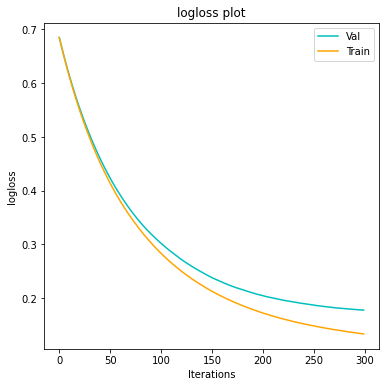

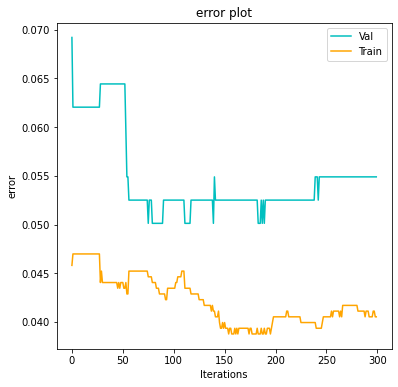

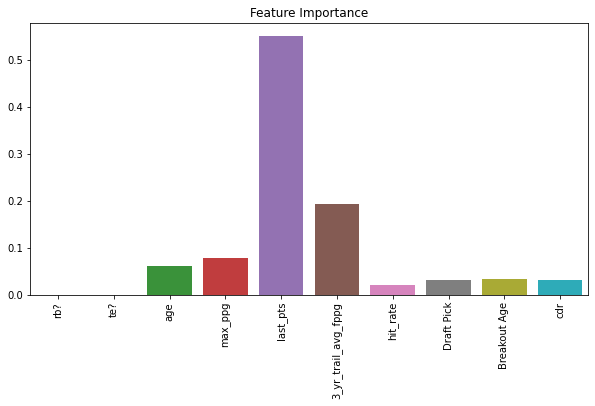

In [191]:
fitXgb(xgb2, training_data)

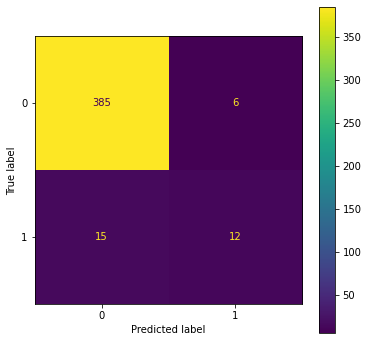

In [192]:
plot_confusion_matrix(xgb2,X_test,
                     Y_test,
                     values_format='d')

## Score 2022

In [193]:
df_2022_X_id

,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr,id,year
0,1,0,24.1,10.9176,10.9176,7.290600,0.0,2.30,19.3,34.8,A.J. Dillon,2022.0
1,1,0,27.5,19.7000,15.2667,17.819867,1.0,5.39,18.8,47.0,Aaron Jones,2022.0
2,1,0,29.4,NaN,NaN,NaN,NaN,6.30,NaN,3.9,Aaron Ripkowski,2022.0
3,1,0,37.2,9.8000,6.6500,8.077067,0.0,1.07,19.5,42.7,Adrian Peterson,2022.0
4,1,0,36.2,NaN,NaN,NaN,NaN,7.40,18.5,46.3,Ahmad Bradshaw,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Seth Green,NaN
146,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.9,Stone Smartt,NaN
147,0,1,22.2,NaN,NaN,NaN,NaN,5.27,NaN,12.7,Teagan Quitoriano,NaN
148,0,1,22.5,NaN,NaN,NaN,NaN,2.23,20.8,46.3,Trey McBride,NaN


In [195]:
j_scores_2022 = pd.DataFrame(xgb2.predict_proba(df_2022_X)).set_index(df_2022_X_id['id']).sort_values(
    1, axis=0, ascending=False)
j_scores_2022.to_csv('j_scores_final_2022.csv')

In [199]:
j_scores_2022.head(60)

,0,1
id,,
Deebo Samuel,0.376664,0.623336
Derrick Henry,0.377931,0.622069
Tyreek Hill,0.383736,0.616264
Justin Jefferson,0.385003,0.614997
Christian McCaffrey,0.385003,0.614997
Alvin Kamara,0.387014,0.612986
Chris Godwin,0.387014,0.612986
Jonathan Taylor,0.388816,0.611184
Davante Adams,0.390254,0.609746


In [157]:
rb_adp = pd.read_csv('rb_adp.csv')
wr_adp = pd.read_csv('wr_adp.csv')
te_adp = pd.read_csv('te_adp.csv')

adp_df = rb_adp.append(wr_adp.append(te_adp))
adp_df

,Full Name,Position,ADP
0,A.J. Dillon,RB,72.1
1,Aaron Green,RB,-
2,Aaron Jones,RB,19.7
3,Aaron Ripkowski,RB,-
4,Abram Smith,RB,215.8
...,...,...,...
499,Zach Ertz,TE,109.8
500,Zach Gentry,TE,216
501,Zach Miller,TE,-
502,Zach Miller,TE,-


In [80]:
winner_df = j_scores_2022.reset_index().merge(adp_df[['Full Name','ADP']], left_on='id',right_on='Full Name')
winner_df.to_csv('winner_df_3.0.csv')

In [81]:
df_2022_id.to_csv('df_2022_id.csv')

## Backtest

### 2021

In [140]:
X_2021 = df_2021.drop(columns=['y'])
X_2021

,rb?,te?,age,max_ppg,last_pts,3_yr_trail_avg_fppg,hit_rate,Draft Pick,Breakout Age,cdr
0,1,0,23.1,3.6636,3.6636,3.663600,0.000000,2.30,19.3,34.8
1,1,0,26.5,19.7000,18.4929,17.497633,0.666667,5.39,18.8,47.0
3,1,0,36.2,11.8000,7.7812,9.793733,0.000000,1.07,19.5,42.7
8,1,0,26.8,10.9000,7.0333,8.966650,0.000000,5.34,19.0,29.9
9,1,0,22.9,6.6846,6.6846,5.992300,0.000000,3.38,19.2,28.7
...,...,...,...,...,...,...,...,...,...,...
1242,0,1,28.4,11.5000,8.5467,8.248900,0.000000,4.12,22.7,15.6
1243,0,1,28.6,4.1900,4.1900,2.596667,0.000000,3.21,20.9,11.5
1248,0,1,24.9,12.3000,3.8188,8.339600,0.000000,4.20,NaN,10.3
1251,0,1,30.5,17.5000,7.0455,12.915167,0.333333,2.03,21.8,31.8


In [141]:
id_2021 = full_data[['Full Name','Fantasy Points Per Game (2021)']].dropna(subset=['Fantasy Points Per Game (2021)'])
id_2021

,Full Name,Fantasy Points Per Game (2021)
0,A.J. Dillon,10.9176
1,Aaron Jones,15.2667
3,Adrian Peterson,6.6500
8,Alex Collins,6.2545
9,Alexander Mattison,7.8688
...,...,...
1242,Tyler Higbee,9.8000
1243,Tyler Kroft,4.3667
1248,Will Dissly,3.3400
1251,Zach Ertz,10.6294


In [142]:
j_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(X_2021)).set_index(id_2021['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2021 = j_scores_2021.reset_index().merge(fp_2021[['Full Name','fpts_2021']],on='Full Name',how='left')
j_scores_2021.to_csv('j_scores_2021_hermes.csv')
j_scores_2021.head(20)

,Full Name,0,1,fpts_2021
0,Dalvin Cook,0.103619,0.896381,206.2996
1,Travis Kelce,0.110784,0.889216,262.8000
2,Christian McCaffrey,0.137908,0.862092,127.5001
3,Mike Evans,0.138605,0.861395,262.4992
4,Tyreek Hill,0.138844,0.861156,296.5004
5,Aaron Jones,0.143905,0.856095,229.0005
6,Stefon Diggs,0.144330,0.855670,285.4997
7,Alvin Kamara,0.145522,0.854478,234.6994
8,Davante Adams,0.154706,0.845294,344.3008
9,Robert Woods,0.174684,0.825316,137.1996


In [143]:
j_scores_2021_check = j_scores_2021.reset_index()
j_scores_2021_check

,index,Full Name,0,1,fpts_2021
0,0,Dalvin Cook,0.103619,0.896381,206.2996
1,1,Travis Kelce,0.110784,0.889216,262.8000
2,2,Christian McCaffrey,0.137908,0.862092,127.5001
3,3,Mike Evans,0.138605,0.861395,262.4992
4,4,Tyreek Hill,0.138844,0.861156,296.5004
...,...,...,...,...,...
551,551,Nick Vannett,0.998154,0.001846,28.3003
552,552,Zach Gentry,0.998154,0.001846,35.7000
553,553,Brandon Bolden,0.998176,0.001824,124.1000
554,554,Travis Benjamin,0.998176,0.001824,-2.0000


In [144]:
X_2020 = df_2020.drop(columns=['y'])
X_2020

id_2020 = full_data[['Full Name','Fantasy Points Per Game (2020)']].dropna(subset=['Fantasy Points Per Game (2020)'])
id_2020

j_scores_2020 = pd.DataFrame(clf_xgb2.predict_proba(X_2020)).set_index(id_2020['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2020 = j_scores_2020.reset_index().merge(fp_2020[['Full Name','fpts_2020']],on='Full Name',how='left')
j_scores_2020.to_csv('j_scores_2020_hermes.csv')

j_scores_2020.head(20)

,Full Name,0,1,fpts_2020
0,Dalvin Cook,0.065179,0.934821,337.8004
1,Christian McCaffrey,0.120315,0.879685,90.3999
2,Aaron Jones,0.120480,0.879520,258.9006
3,Keenan Allen,0.135766,0.864234,245.0994
4,Austin Ekeler,0.175809,0.824191,165.3000
5,Travis Kelce,0.194107,0.805893,312.7605
6,Robert Woods,0.212016,0.787984,245.0992
7,Josh Jacobs,0.212368,0.787632,231.3000
8,Derrick Henry,0.227598,0.772402,333.1008
9,Chris Carson,0.256457,0.743543,187.8000


[CV] END gamma=0.5, learning_rate=0.01, max_depth=6, reg_lambda=10.0, scale_pos_weight=1; total time=   1.9s
[CV] END gamma=0.5, learning_rate=0.01, max_depth=7, reg_lambda=10.0, scale_pos_weight=1; total time=   1.9s
[CV] END gamma=0.75, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.6s
[CV] END gamma=0.75, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.6s
[CV] END gamma=0.75, learning_rate=0.01, max_depth=6, reg_lambda=10.0, scale_pos_weight=1; total time=   1.5s
[CV] END gamma=0.75, learning_rate=0.01, max_depth=6, reg_lambda=10.0, scale_pos_weight=1; total time=   1.5s
[CV] END gamma=0.75, learning_rate=0.01, max_depth=7, reg_lambda=10.0, scale_pos_weight=1; total time=   1.5s
[CV] END gamma=0.75, learning_rate=0.01, max_depth=6, reg_lambda=10.0, scale_pos_weight=1; total time=   1.6s
[CV] END gamma=0.75, learning_rate=0.01, max_depth=7, reg_lambda=10.0, scale_pos_weight=1; total time=   1.6s
[CV] END gam

In [145]:
X_2019 = df_2019.drop(columns=['y'])
X_2019

id_2019 = full_data[['Full Name','Fantasy Points Per Game (2019)']].dropna(subset=['Fantasy Points Per Game (2019)'])
id_2019

j_scores_2019 = pd.DataFrame(clf_xgb2.predict_proba(X_2019)).set_index(id_2019['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2019 = j_scores_2019.reset_index().merge(fp_2019[['Full Name','fpts_2019']],on='Full Name',how='left')
j_scores_2019.to_csv('j_scores_2019_hermes.csv')

j_scores_2019.head(20)

,Full Name,0,1,fpts_2019
0,Davante Adams,0.062784,0.937216,211.2
1,Michael Thomas,0.070148,0.929852,374.4
2,Julio Jones,0.089063,0.910937,274.5
3,Melvin Gordon,0.118417,0.881583,181.2
4,Christian McCaffrey,0.146370,0.853630,468.8
5,Antonio Brown,0.146602,0.853398,16.1
6,Alvin Kamara,0.159059,0.840941,249.2
7,Tyreek Hill,0.159656,0.840344,188.4
8,Ezekiel Elliott,0.161124,0.838876,312.0
9,Saquon Barkley,0.161444,0.838556,244.4


In [146]:
X_2018 = df_2018.drop(columns=['y'])
X_2018

id_2018 = full_data[['Full Name','Fantasy Points Per Game (2018)']].dropna(subset=['Fantasy Points Per Game (2018)'])
id_2018

j_scores_2018 = pd.DataFrame(clf_xgb2.predict_proba(X_2018)).set_index(id_2018['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2018 = j_scores_2018.reset_index().merge(fp_2018[['Full Name','fpts_2018']],on='Full Name',how='left')
j_scores_2018.to_csv('j_scores_2018_hermes.csv')

j_scores_2018.head(20)

,Full Name,0,1,fpts_2018
0,DeAndre Hopkins,0.110494,0.889506,332.8
1,Michael Thomas,0.132618,0.867382,315.2
2,Antonio Brown,0.136321,0.863679,324.0
3,Alvin Kamara,0.142754,0.857246,348.0
4,Keenan Allen,0.154853,0.845147,258.0
5,Ezekiel Elliott,0.156828,0.843172,327.0
6,Julio Jones,0.173479,0.826521,326.4
7,Cooper Kupp,0.217280,0.782720,135.2
8,Melvin Gordon,0.249052,0.750948,271.2
9,Davante Adams,0.262546,0.737454,327.0


In [147]:
X_2017 = df_2017.drop(columns=['y'])
X_2017

id_2017 = full_data[['Full Name','Fantasy Points Per Game (2017)']].dropna(subset=['Fantasy Points Per Game (2017)'])
id_2017

j_scores_2017 = pd.DataFrame(clf_xgb2.predict_proba(X_2017)).set_index(id_2017['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2017 = j_scores_2017.reset_index().merge(fp_2017[['Full Name','fpts_2017']],on='Full Name',how='left')
j_scores_2017.to_csv('j_scores_2017_hermes.csv')

j_scores_2017.head(20)

,Full Name,0,1,fpts_2017
0,Le'Veon Bell,0.101645,0.898355,342.0
1,Ezekiel Elliott,0.114394,0.885606,203.0
2,Antonio Brown,0.125034,0.874966,308.0
3,David Johnson,0.139751,0.860249,13.0
4,LeSean McCoy,0.182422,0.817578,264.0
5,Leonard Fournette,0.182682,0.817318,230.1
6,Mark Ingram,0.187005,0.812995,278.4
7,Melvin Gordon,0.197455,0.802545,288.0
8,Michael Thomas,0.213827,0.786173,259.2
9,Julio Jones,0.253901,0.746099,251.2
